In [2]:
OUTPUT_PATH = 'output\\'
DETAILED_OUTPUT_PATH = OUTPUT_PATH + 'detailed\\'
OUTPUT_RESULTS_TXT_FILE = OUTPUT_PATH + 'general\\' + 'clusters.txt'
OUTPUT_RESULTS_EXCEL_FILE = OUTPUT_PATH + 'general\\' + 'clusters.csv'

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.cluster import KMeans
from matplotlib.image import imread
import cv2
import numpy as np


# Our Import Statements

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import ceil
from pathlib import Path
from seaborn import heatmap
from skimage.transform import rescale
from sklearn.metrics import confusion_matrix
from numpy import expand_dims
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import csv, math

from tensorflow.random import set_seed
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import regularizers
from keras.layers import Dropout

from tensorflow import random
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

set_seed(4)



def padding(image, shape):
    
    def seperate_pad_width(width):
        return (width // 2, ceil(width / 2))
    
    padding_axis = [seperate_pad_width(abs(image.shape[0] - shape[0])),
                    seperate_pad_width(abs(image.shape[1] - shape[1]))]
    image = np.pad(image, (padding_axis[0], padding_axis[1], (0,0)), constant_values = 0)
    
    return image

def resample(image, shape_read_file, shape_with_padding):
   
    ratio = min(shape_read_file[0] / image.shape[0], shape_read_file[1] / image.shape[1])
    image = rescale(image, ratio, order = 1, preserve_range = True, multichannel = True)
    
    image = padding(image, shape_with_padding) # * shape    
    
    return image

def read_file(path, shape_read_file, shape_with_padding, is_gray=False, is_gonna_be_resampled=True):
    X, Y = [], []
    file = open(path, 'r')
    file.readline() # ignore  header
    
    for line in file:
        temp = line[ :-1].split('#')
        
        image_height = int(temp[3])
        image_width = int(temp[4])
        
        if is_gray:
            image = temp[-1].split(';')
        else:
            image = [(ord(i) & 1) * 255 for i in temp[-1]]
        image = np.array(image, dtype = 'uint8')
        
        image.resize(image_height, image_width, 1)
        if is_gonna_be_resampled:
            image = resample(image, shape_read_file, shape_with_padding)
            
        label = int(temp[0])
        
        X.append(image)
        Y.append(label)
        
    image_count = len(Y)
    if not is_gonna_be_resampled:
        width = max(len(im[0]) for im in X)
        height = max(len(im) for im in X)
        #print(width, height)
        for i in range(len(X)):
            X[i] = resample(X[i], (width, height, 1), (width, height, 1))
    
    X = np.array(X, dtype = 'uint8')
    Y = to_categorical(Y, dtype = 'uint8') # num_classes = 10,  *
    return X,Y

def read_preapare_db(path, shape_read_file, shape_with_padding):
    is_gray = False #'gray' in str(path)
    X, Y = read_file(path, shape_read_file, shape_with_padding, is_gray)
    #X = vpadding(X, shape)
    X = X.astype('float32')
    X /= 255
    return X,Y

def read_preapare_db_original_size(path, shape_read_file=(20,20,1), shape_with_padding=(32,32,1)):
    is_gray = False #'gray' in str(path)
    X, Y = read_file(path, shape_read_file, shape_with_padding, is_gray, is_gonna_be_resampled=False)
    #X = vpadding(X, shape)
    X = X.astype('float32')
    X /= 255
    return X,Y

def read_prepare_db_pdc(path, shape_read_file, shape_with_padding, is_gray=False):
    X, Y = [], []
    file = open(path, 'r')
    file.readline() # ignore  header
    
    for line in file:
        temp = line[ :-1].split('#')
        
        image_height = int(temp[3])
        image_width = int(temp[4])
        
        image = temp[-1].split(';')
        """
        if is_gray:
            image = temp[-1].split(';')
        else:
            image = [(ord(i) & 1) * 255 for i in temp[-1]]
        """
        try:
            image = np.array(image, dtype = 'float32')
        except ValueError as e:
            print(temp[-1])
        
        #image = np.array(image, dtype = 'float32')
        
        #image.resize(image_height, image_width, 1)
        #image = resample(image, shape_read_file, shape_with_padding)
        
        label = int(temp[0])
        
        X.append(image)
        Y.append(label)
        
    #image_count = len(Y)
    X = np.array(X, dtype = 'float32')
    Y = to_categorical(Y, dtype = 'uint8') # num_classes = 10, 
    return X,Y

def augment(x_train_original, y_train_original, n, is_shuffled = True):
    datagen = ImageDataGenerator(featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
      width_shift_range=0,
      height_shift_range=0,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest')

    """
    horizontal_flip=True,

    """
    it = datagen.flow(x_train_original, y_train_original, batch_size=14000, shuffle=is_shuffled, seed=0) #x_train_32x32 #.reshape(14000, 32, 32, 1)
    x, y = x_train_original, y_train_original #it.next()
    for i in range(n-1):
        temp_x, temp_y = it.next()
        x = np.concatenate((x, temp_x), axis=0)
        y = np.concatenate((y, temp_y), axis=0) #
    #data = np.concatenate((it.next(), it.next()), axis=0)
    #for i in range(n-2):
     #   data = np.concatenate((data, it.next()), axis=0)
    #plt.imshow(resample(data[13999*3], (20, 20, 1), (32, 32, 1)).reshape(32, 32),cmap='Greys')
    return x, y #data

def extract_spec_size(x_train_original, shape_read_file, shape_with_padding):
    x_train_new = list()
    for i in range(len(x_train_original)):
        x_train_new.append(resample(x_train_original[i], shape_read_file, shape_with_padding))
    x_train_new = np.array(x_train_new, dtype = 'float32')
    return x_train_new

# =============== AUGMENT SIZE ===============
#aug_size = 2 #2, 3, 4
# =============== AUGMENT SIZE ===============

# PREPARE 32x32, 20x20 from AUGMENTED

# AUGMENTED Train PDC

# PREPARED PDC files for {seed = 0}
aug_switch = {
    2:'datasets/GENERATED_HandChars_28k_32x32_Train_PDC4428_saved.txt',
    3:'datasets/GENERATED_HandChars_42k_32x32_Train_PDC4428_saved.txt',
    5:'datasets/GENERATED_HandChars_70k_32x32_Train_PDC4428_saved.txt'
}

In [3]:
def find_horizontal_hist_for_an_image(image, threshold_value):
    w = image.shape[1]
    h = image.shape[0]
    
    hist = [0] * h
    for row in range(h):
        for col in range(w):
            if image[row][col] > threshold_value:
                hist[row] += 1
    return hist

def find_vertical_hist_for_an_image(image, threshold_value):
    w = image.shape[1]
    h = image.shape[0]
    
    hist = [0] * w
    for col in range(w):
        for row in range(h):
            if image[row][col] > threshold_value:
                hist[col] += 1
    return hist

def find_hist_for_an_image(image, threshold_value = 0.5):
    return find_horizontal_hist_for_an_image(image, threshold_value) + find_vertical_hist_for_an_image(image, threshold_value)
    
def find_hist_for_images(images):
    hists = []
    for image in images:
        hists.append(find_hist_for_an_image(image))
    return np.array(hists)

In [4]:
image_read_shape = (20, 20, 1)

In [5]:
x_test, y_test = read_preapare_db(Path('datasets/HandChars_100_Test.txt').absolute(), image_read_shape, image_read_shape)
x_test_hist = find_hist_for_images(x_test)
x_test = x_test.reshape(x_test.shape[0], -1)

x_train_original, y_train_original = read_preapare_db_original_size(Path('datasets/HandChars_500_woI_Train.txt').absolute())

In [7]:
EPOCHS = 200
callback = EarlyStopping(monitor='loss', min_delta=0.01, patience=5)

results_df = pd.DataFrame(columns=['Seed', 'Pooling2D', 'Model', 'Param-Count', 'Epochs',
                                   'Accuracy-Train', 'Loss-Train', 'Accuracy-Test', 'Loss-Test'])

#x_train_original, y_train_original = read_preapare_db_original_size(Path('datasets/HandChars_500_woI_Train.txt').absolute())
for aug_size in (1, 2, 3, 4, 5): #2, 3, 5
    x_train, y_train = augment(x_train_original, y_train_original, n=aug_size, is_shuffled = False) # n * 14000
    print('\nAUGMENTATION DONE', str(x_train.shape[0]))
    print()
    
    x_train = extract_spec_size(x_train, image_read_shape, image_read_shape)

    x_train_hist = find_hist_for_images(x_train)
    x_train = x_train.reshape(x_train.shape[0], -1)
    
    for seed in range(5): #range()
        
        # Pixel-1
        keras.backend.clear_session()    
        model_pixels_50_50 = Sequential(name = 'Pixels-{0}-19-120-28'.format(x_train.shape[1]))

        model_pixels_50_50.add(layers.Dense(19, input_shape = (x_train.shape[1],), activation='relu'))
        model_pixels_50_50.add(layers.Dense(120, activation='relu'))
        model_pixels_50_50.add(layers.Dense(28, activation='softmax'))

        model_pixels_50_50.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics = ['accuracy'])
        history = model_pixels_50_50.fit(x_train, y_train, epochs = EPOCHS, shuffle = True, callbacks=[callback], verbose=0) #callbacks=[callback],

        loss_train_pixels, acc_train_pixels = model_pixels_50_50.evaluate(x_train, y_train, verbose=0)
        loss_test_pixels, acc_test_pixels = model_pixels_50_50.evaluate(x_test, y_test, verbose=0)

        results_df.loc[len(results_df)] = [str(seed), str('-'), str(model_pixels_50_50.name),
                                           str(model_pixels_50_50.count_params()), len(history.history['loss']),
                                           acc_train_pixels, loss_train_pixels,
                                           acc_test_pixels, loss_test_pixels]        
        print(results_df.loc[len(results_df)-1,:].tolist())
        
        
        # Pixel-2
        keras.backend.clear_session()    
        model_pixels_50 = Sequential(name = 'Pixels-{0}-19-28'.format(x_train.shape[1]))

        model_pixels_50.add(layers.Dense(19, input_shape = (x_train.shape[1],), activation='relu'))
        model_pixels_50.add(layers.Dense(28, activation='softmax'))

        model_pixels_50.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics = ['accuracy'])
        history = model_pixels_50.fit(x_train, y_train, epochs = EPOCHS, shuffle = True, callbacks=[callback], verbose=0) #callbacks=[callback],

        loss_train, acc_train = model_pixels_50.evaluate(x_train, y_train, verbose=0)
        loss_test, acc_test = model_pixels_50.evaluate(x_test, y_test, verbose=0)

        results_df.loc[len(results_df)] = [str(seed), str('-'), str(model_pixels_50.name),
                                           str(model_pixels_50.count_params()), len(history.history['loss']),
                                           acc_train, loss_train,
                                           acc_test, loss_test]        
        print(results_df.loc[len(results_df)-1,:].tolist())
        
        # Hist-1
        keras.backend.clear_session()    
        model_hist_50_50 = Sequential(name = 'Hist-{0}-217-45-28'.format(x_train_hist.shape[1]))

        model_hist_50_50.add(layers.Dense(217, input_shape = (x_train_hist.shape[1],), activation='relu'))
        model_hist_50_50.add(layers.Dense(45, activation='relu'))
        model_hist_50_50.add(layers.Dense(28, activation='softmax'))

        model_hist_50_50.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics = ['accuracy'])
        history = model_hist_50_50.fit(x_train_hist, y_train, epochs = EPOCHS, shuffle = True, callbacks=[callback], verbose=0) #callbacks=[callback],

        loss_train, acc_train = model_hist_50_50.evaluate(x_train_hist, y_train, verbose=0)
        loss_test, acc_test = model_hist_50_50.evaluate(x_test_hist, y_test, verbose=0)

        results_df.loc[len(results_df)] = [str(seed), str('-'), str(model_hist_50_50.name),
                                           str(model_hist_50_50.count_params()), len(history.history['loss']),
                                           acc_train, loss_train,
                                           acc_test, loss_test]        
        print(results_df.loc[len(results_df)-1,:].tolist())
        
        
        # Hist-2
        keras.backend.clear_session()    
        model_hist_50 = Sequential(name = 'Hist-{0}-217-28'.format(x_train_hist.shape[1]))

        model_hist_50.add(layers.Dense(217, input_shape = (x_train_hist.shape[1],), activation='relu'))
        model_hist_50.add(layers.Dense(28, activation='softmax'))

        model_hist_50.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics = ['accuracy'])
        history = model_hist_50.fit(x_train_hist, y_train, epochs = EPOCHS, shuffle = True, callbacks=[callback], verbose=0) #callbacks=[callback],

        loss_train, acc_train = model_hist_50.evaluate(x_train_hist, y_train, verbose=0)
        loss_test, acc_test = model_hist_50.evaluate(x_test_hist, y_test, verbose=0)

        results_df.loc[len(results_df)] = [str(seed), str('-'), str(model_hist_50.name),
                                           str(model_hist_50.count_params()), len(history.history['loss']),
                                           acc_train, loss_train,
                                           acc_test, loss_test]        
        print(results_df.loc[len(results_df)-1,:].tolist())
        
        results_df.to_csv(OUTPUT_PATH + 'Results_train-' + str(aug_size * 14) +'k_pixels-hist.csv', index = False)


AUGMENTATION DONE 14000

['0', '-', 'Pixels-400-19-120-28', '13407', 46, 0.9940714240074158, 0.025904543697834015, 0.7825000286102295, 2.0342164039611816]
['0', '-', 'Pixels-400-19-28', '8179', 56, 0.9588571190834045, 0.15766477584838867, 0.746071457862854, 1.6307833194732666]
['0', '-', 'Hist-40-217-45-28', '19995', 71, 0.9579285979270935, 0.12888801097869873, 0.6025000214576721, 3.8233447074890137]
['0', '-', 'Hist-40-217-28', '15001', 75, 0.9228571653366089, 0.23229537904262543, 0.5996428728103638, 3.106868028640747]
['1', '-', 'Pixels-400-19-120-28', '13407', 49, 0.9899285435676575, 0.03375759348273277, 0.7774999737739563, 2.0936496257781982]
['1', '-', 'Pixels-400-19-28', '8179', 51, 0.9523571133613586, 0.1775961071252823, 0.743571400642395, 1.5617810487747192]
['1', '-', 'Hist-40-217-45-28', '19995', 76, 0.9514285922050476, 0.14123935997486115, 0.5899999737739563, 3.8400802612304688]
['1', '-', 'Hist-40-217-28', '15001', 95, 0.9507142901420593, 0.15405435860157013, 0.58928573131

C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



AUGMENTATION DONE 28000

['0', '-', 'Pixels-400-19-120-28', '13407', 49, 0.9850000143051147, 0.04355587437748909, 0.8096428513526917, 1.886847972869873]
['0', '-', 'Pixels-400-19-28', '8179', 53, 0.9266428351402283, 0.24748273193836212, 0.7810714244842529, 1.3165178298950195]


KeyboardInterrupt: 

In [90]:
keras.backend.clear_session()    
model_pixels_50_50 = Sequential(name = 'Pixels-{0}-50-50-28'.format(x_train.shape[1]))

model_pixels_50_50.add(layers.Dense(19, input_shape = (1032,), activation='relu'))
model_pixels_50_50.add(layers.Dense(120, activation='relu'))
model_pixels_50_50.add(layers.Dense(28, activation='softmax'))

model_pixels_50_50.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics = ['accuracy'])

model_pixels_50_50.summary()

Model: "Pixels-32-50-50-28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 19)                19627     
_________________________________________________________________
dense_1 (Dense)              (None, 120)               2400      
_________________________________________________________________
dense_2 (Dense)              (None, 28)                3388      
Total params: 25,415
Trainable params: 25,415
Non-trainable params: 0
_________________________________________________________________


In [89]:
model_hist_50_50 = Sequential(name = 'Hist-{0}-50-50-28'.format(x_train_hist.shape[1]))

model_hist_50_50.add(layers.Dense(217, input_shape = (64,), activation='relu'))
model_hist_50_50.add(layers.Dense(45, activation='relu'))
model_hist_50_50.add(layers.Dense(28, activation='softmax'))

model_hist_50_50.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics = ['accuracy'])

model_hist_50_50.summary()

Model: "Hist-64-50-50-28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 217)               14105     
_________________________________________________________________
dense_10 (Dense)             (None, 45)                9810      
_________________________________________________________________
dense_11 (Dense)             (None, 28)                1288      
Total params: 25,203
Trainable params: 25,203
Non-trainable params: 0
_________________________________________________________________


## 20X20

In [ ]:
EPOCHS = 200
callback = EarlyStopping(monitor='loss', min_delta=0.01, patience=5)

results_df = pd.DataFrame(columns=['Seed', 'Pooling2D', 'Model', 'Param-Count', 'Epochs',
                                   'Accuracy-Train', 'Loss-Train', 'Accuracy-Test', 'Loss-Test'])

#x_train_original, y_train_original = read_preapare_db_original_size(Path('datasets/HandChars_500_woI_Train.txt').absolute())
for aug_size in (1, 2, 3, 4, 5): #2, 3, 5
    x_train, y_train = augment(x_train_original, y_train_original, n=aug_size, is_shuffled = False) # n * 14000
    print('\nAUGMENTATION DONE', str(x_train.shape[0]))
    print()
    
    x_train = extract_spec_size(x_train, image_read_shape, image_read_shape)

    x_train_hist = find_hist_for_images(x_train)
    x_train = x_train.reshape(x_train.shape[0], -1)
    
    for seed in range(5): #range()
        
        # Pixel-1
        keras.backend.clear_session()    
        model_pixels_50_50 = Sequential(name = 'Pixels-{0}-19-120-28'.format(x_train.shape[1]))

        model_pixels_50_50.add(layers.Dense(48, input_shape = (x_train.shape[1],), activation='relu'))
        model_pixels_50_50.add(layers.Dense(80, activation='relu'))
        model_pixels_50_50.add(layers.Dense(28, activation='softmax'))

        model_pixels_50_50.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics = ['accuracy'])
        history = model_pixels_50_50.fit(x_train, y_train, epochs = EPOCHS, shuffle = True, callbacks=[callback], verbose=0) #callbacks=[callback],

        loss_train_pixels, acc_train_pixels = model_pixels_50_50.evaluate(x_train, y_train, verbose=0)
        loss_test_pixels, acc_test_pixels = model_pixels_50_50.evaluate(x_test, y_test, verbose=0)

        results_df.loc[len(results_df)] = [str(seed), str('-'), str(model_pixels_50_50.name),
                                           str(model_pixels_50_50.count_params()), len(history.history['loss']),
                                           acc_train_pixels, loss_train_pixels,
                                           acc_test_pixels, loss_test_pixels]        
        print(results_df.loc[len(results_df)-1,:].tolist())
        
        
        # Pixel-2
        keras.backend.clear_session()    
        model_pixels_50 = Sequential(name = 'Pixels-{0}-19-28'.format(x_train.shape[1]))

        model_pixels_50.add(layers.Dense(48, input_shape = (x_train.shape[1],), activation='relu'))
        model_pixels_50.add(layers.Dense(28, activation='softmax'))

        model_pixels_50.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics = ['accuracy'])
        history = model_pixels_50.fit(x_train, y_train, epochs = EPOCHS, shuffle = True, callbacks=[callback], verbose=0) #callbacks=[callback],

        loss_train, acc_train = model_pixels_50.evaluate(x_train, y_train, verbose=0)
        loss_test, acc_test = model_pixels_50.evaluate(x_test, y_test, verbose=0)

        results_df.loc[len(results_df)] = [str(seed), str('-'), str(model_pixels_50.name),
                                           str(model_pixels_50.count_params()), len(history.history['loss']),
                                           acc_train, loss_train,
                                           acc_test, loss_test]        
        print(results_df.loc[len(results_df)-1,:].tolist())
        
        # Hist-1
        keras.backend.clear_session()    
        model_hist_50_50 = Sequential(name = 'Hist-{0}-217-45-28'.format(x_train_hist.shape[1]))

        model_hist_50_50.add(layers.Dense(290, input_shape = (x_train_hist.shape[1],), activation='relu'))
        model_hist_50_50.add(layers.Dense(42, activation='relu'))
        model_hist_50_50.add(layers.Dense(28, activation='softmax'))

        model_hist_50_50.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics = ['accuracy'])
        history = model_hist_50_50.fit(x_train_hist, y_train, epochs = EPOCHS, shuffle = True, callbacks=[callback], verbose=0) #callbacks=[callback],

        loss_train, acc_train = model_hist_50_50.evaluate(x_train_hist, y_train, verbose=0)
        loss_test, acc_test = model_hist_50_50.evaluate(x_test_hist, y_test, verbose=0)

        results_df.loc[len(results_df)] = [str(seed), str('-'), str(model_hist_50_50.name),
                                           str(model_hist_50_50.count_params()), len(history.history['loss']),
                                           acc_train, loss_train,
                                           acc_test, loss_test]        
        print(results_df.loc[len(results_df)-1,:].tolist())
        
        
        # Hist-2
        keras.backend.clear_session()    
        model_hist_50 = Sequential(name = 'Hist-{0}-217-28'.format(x_train_hist.shape[1]))

        model_hist_50.add(layers.Dense(290, input_shape = (x_train_hist.shape[1],), activation='relu'))
        model_hist_50.add(layers.Dense(28, activation='softmax'))

        model_hist_50.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics = ['accuracy'])
        history = model_hist_50.fit(x_train_hist, y_train, epochs = EPOCHS, shuffle = True, callbacks=[callback], verbose=0) #callbacks=[callback],

        loss_train, acc_train = model_hist_50.evaluate(x_train_hist, y_train, verbose=0)
        loss_test, acc_test = model_hist_50.evaluate(x_test_hist, y_test, verbose=0)

        results_df.loc[len(results_df)] = [str(seed), str('-'), str(model_hist_50.name),
                                           str(model_hist_50.count_params()), len(history.history['loss']),
                                           acc_train, loss_train,
                                           acc_test, loss_test]        
        print(results_df.loc[len(results_df)-1,:].tolist())
        
        results_df.to_csv(OUTPUT_PATH + 'Results_20x20_train-' + str(aug_size * 14) +'k_pixels-hist.csv', index = False)


AUGMENTATION DONE 14000

['0', '-', 'Pixels-400-19-120-28', '25436', 29, 0.9919999837875366, 0.029010144993662834, 0.7842857241630554, 1.8244383335113525]
['0', '-', 'Pixels-400-19-28', '20620', 56, 0.9988571405410767, 0.018289972096681595, 0.768928587436676, 1.9682343006134033]
['0', '-', 'Hist-40-217-45-28', '25316', 68, 0.962071418762207, 0.11773771792650223, 0.6053571701049805, 3.780099391937256]
['0', '-', 'Hist-40-217-28', '20038', 83, 0.960357129573822, 0.12168341875076294, 0.6032142639160156, 3.7234911918640137]
['1', '-', 'Pixels-400-19-120-28', '25436', 34, 0.9936428666114807, 0.02238844335079193, 0.7946428656578064, 1.9452251195907593]
['1', '-', 'Pixels-400-19-28', '20620', 48, 0.9983571171760559, 0.0194272268563509, 0.7760714292526245, 1.7829458713531494]
['1', '-', 'Hist-40-217-45-28', '25316', 73, 0.9545000195503235, 0.1388854682445526, 0.6032142639160156, 3.7787129878997803]
['1', '-', 'Hist-40-217-28', '20038', 78, 0.956928551197052, 0.13732801377773285, 0.61571431159

In [47]:
keras.backend.clear_session()    
model_pixels_50_50 = Sequential(name = 'Pixels-{0}-50-50-28'.format(x_train.shape[1]))

model_pixels_50_50.add(layers.Dense(48, input_shape = (x_train.shape[1],), activation='relu'))
model_pixels_50_50.add(layers.Dense(80, activation='relu'))
model_pixels_50_50.add(layers.Dense(28, activation='softmax'))

model_pixels_50_50.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics = ['accuracy'])

model_pixels_50_50.summary()

Model: "Pixels-400-50-50-28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 48)                19248     
_________________________________________________________________
dense_1 (Dense)              (None, 28)                1372      
Total params: 20,620
Trainable params: 20,620
Non-trainable params: 0
_________________________________________________________________


In [50]:
model_hist_50_50 = Sequential(name = 'Hist-{0}-50-50-28'.format(x_train_hist.shape[1]))

model_hist_50_50.add(layers.Dense(290, input_shape = (x_train_hist.shape[1],), activation='relu'))
model_hist_50_50.add(layers.Dense(42, activation='relu'))
model_hist_50_50.add(layers.Dense(28, activation='softmax'))

model_hist_50_50.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics = ['accuracy'])

model_hist_50_50.summary()

Model: "Hist-40-50-50-28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 290)               11890     
_________________________________________________________________
dense_8 (Dense)              (None, 42)                12222     
_________________________________________________________________
dense_9 (Dense)              (None, 28)                1204      
Total params: 25,316
Trainable params: 25,316
Non-trainable params: 0
_________________________________________________________________


In [2]:
aug_size = 1

print('AUGMENTATION STARTING...')
x_train_original, y_train_original = read_preapare_db_original_size(Path('datasets/HandChars_500_woI_Train.txt').absolute())
print('DATA READ!')
x_train_original, y_train_original = augment(x_train_original, y_train_original, n=aug_size, is_shuffled = False) # n * 14000
print('AUGMENTATION DONE:', str(x_train_original.shape[0]))
#x_train_pdc, y_train_pdc = read_prepare_db_pdc(Path(aug_switch.get(aug_size, '')).absolute(), (0, 256, 1), (0, 256, 1))

y_train = y_train_original
#x_train_32x32 = extract_spec_size(x_train_original, (20, 20, 1), (32, 32, 1))
x_train_20x20 = extract_spec_size(x_train_original, (20, 20, 1), (20, 20, 1))

x_train_20x20 = x_train_20x20.reshape(x_train_20x20.shape[0], 400)

AUGMENTATION STARTING...
DATA READ!
AUGMENTATION DONE: 14000


In [36]:
data = x_train_20x20
y_data = y_train

In [4]:
data.shape

(14000, 400)

In [15]:
num_of_classes = len(np.unique(np.argmax(data_y, axis = 1)))

In [52]:
C = [0] * num_of_classes

for class_index in range(num_of_classes):
    y_pred = np.argmax(y_data, axis = 1)
    
    temp = [0] * data.shape[1]
    for image in data[y_pred == i]:
        for j in range(image.shape[0]):
            temp[j] += image[j]
    C[class_index] = temp

for i in range(num_of_classes): # of classes
    for j in range(len(C[i])):
        y_pred = np.argmax(y_data, axis = 1)
        C[i][j] /= len(y_pred[y_pred == i]) # num of samples in a class
C = np.array(C)

In [55]:
C[0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.03001097e-07, 5.14392529e-05, 6.27962967e-04,
       2.91990391e-03, 9.96728109e-03, 1.61733501e-02, 3.39999631e-02,
       7.03671923e-02, 1.24271444e-01, 2.11047395e-01, 2.99331634e-01,
       2.98447216e-01, 2.40827468e-01, 1.70623302e-01, 8.43335077e-02,
       3.24637471e-02, 1.29359948e-02, 7.61163633e-03, 1.79266808e-03,
       0.00000000e+00, 3.98781663e-06, 4.28090929e-04, 2.43771104e-03,
       4.59081725e-03, 1.35542738e-02, 2.95936530e-02, 6.11182601e-02,
       1.18064902e-01, 2.15381552e-01, 3.47927400e-01, 4.56642042e-01,
       4.37933529e-01, 3.53794138e-01, 2.34138369e-01, 1.23346898e-01,
      

In [62]:
def minkowski(X, Y, alpha = 2):
    sum = 0
    for i in range(len(X)):
        sum += abs((X[i] - Y[i]) ** alpha)
    return math.sqrt(sum)

def change_feature_to_cluster_distances(data, C):
    data2 = []
    
    for sample_index in range(len(data)):
        X = []
        for cluster_index in range(len(C)):
            X.append(minkowski(data[sample_index], C[cluster_index]))
        data2.append(X)
        print(sample_index)
    return np.array(data2)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066


3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706


5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348


6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991


8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634


10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
1023

11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
1160

12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
1297

In [64]:
#X_prime = change_feature_to_cluster_distances(data, C)

y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [67]:
x_train_20x20 = X_prime

In [75]:
x_train_20x20

array([[4.84061744, 4.84061744, 4.84061744, ..., 4.84061744, 4.84061744,
        4.84061744],
       [3.9024644 , 3.9024644 , 3.9024644 , ..., 3.9024644 , 3.9024644 ,
        3.9024644 ],
       [4.50867719, 4.50867719, 4.50867719, ..., 4.50867719, 4.50867719,
        4.50867719],
       ...,
       [6.10650506, 6.10650506, 6.10650506, ..., 6.10650506, 6.10650506,
        6.10650506],
       [5.33757574, 5.33757574, 5.33757574, ..., 5.33757574, 5.33757574,
        5.33757574],
       [6.17348198, 6.17348198, 6.17348198, ..., 6.17348198, 6.17348198,
        6.17348198]])

In [79]:
y_test

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [71]:
y_test = y_test_20x20

In [73]:
x_test_20x20 = change_feature_to_cluster_distances(x_test_20x20, C)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097


In [74]:
EPOCHS = 200
callback = EarlyStopping(monitor='loss', min_delta=0.01, patience=5)

#x_test_20x20 = change_feature_to_cluster_distances(x_test_20x20, C)
results_df = pd.DataFrame(columns=['Seed', 'Pooling2D', 'Model', 'Param-Count',
                                   'Accuracy-Train', 'Loss-Train', 'Accuracy-Test', 'Loss-Test'])
for aug_size in (1,): #2, 3, 5
    results_df = pd.DataFrame(columns=['Seed', 'Pooling2D', 'Model', 'Param-Count',
                                   'Accuracy-Train', 'Loss-Train', 'Accuracy-Test', 'Loss-Test'])
    y_train = y_data
    
    for seed in (42,): #range()
        
        #x_test_20x20 = change_feature_to_cluster_distances(x_test_20x20, C)
        
        keras.backend.clear_session()    
        model_pixels_50_50 = Sequential(name = 'Pixels-400-50-50-28')

        model_pixels_50_50.add(layers.Dense(50, input_shape = (28,), activation='relu'))
        model_pixels_50_50.add(layers.Dense(50, activation='relu'))
        model_pixels_50_50.add(layers.Dense(28, activation='softmax'))

        model_pixels_50_50.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics = ['accuracy'])
        model_pixels_50_50.fit(x_train_20x20, y_train, epochs = EPOCHS, shuffle = True, callbacks=[callback], verbose=0) #callbacks=[callback],

        loss_train_pixels_50_50, acc_train_pixels_50_50 = model_pixels_50_50.evaluate(x_train_20x20, y_train, verbose=0)
        loss_test_pixels_50_50, acc_test_pixels_50_50 = model_pixels_50_50.evaluate(x_test_20x20, y_test, verbose=0)

        results_df.loc[len(results_df)] = [str(seed), str('-'), str(model_pixels_50_50.name),
                                           str(model_pixels_50_50.count_params()),
                                           acc_train_pixels_50_50, loss_train_pixels_50_50,
                                           acc_test_pixels_50_50, loss_test_pixels_50_50]        
        print(results_df.loc[len(results_df)-1,:].tolist())

['42', '-', 'Pixels-400-50-50-28', '5428', 0.0925714299082756, 3.1456589698791504, 0.0357142873108387, 1297.72509765625]


In [66]:
EPOCHS = 200
callback = EarlyStopping(monitor='loss', min_delta=0.01, patience=5)

x_test_20x20 = change_feature_to_cluster_distances(x_test_20x20, C)
results_df = pd.DataFrame(columns=['Seed', 'Pooling2D', 'Model', 'Param-Count',
                                   'Accuracy-Train', 'Loss-Train', 'Accuracy-Test', 'Loss-Test'])
for aug_size in (1,): #2, 3, 5
    results_df = pd.DataFrame(columns=['Seed', 'Pooling2D', 'Model', 'Param-Count',
                                   'Accuracy-Train', 'Loss-Train', 'Accuracy-Test', 'Loss-Test'])
    y_train = y_data
    
    for seed in (42,): #range()
        
        x_test_20x20 = change_feature_to_cluster_distances(x_test_20x20, C)
        
        keras.backend.clear_session()    
        model_pixels_50_50 = Sequential(name = 'Pixels-400-50-50-28')

        model_pixels_50_50.add(layers.Dense(50, input_shape = (28,), activation='relu'))
        model_pixels_50_50.add(layers.Dense(50, activation='relu'))
        model_pixels_50_50.add(layers.Dense(28, activation='softmax'))

        model_pixels_50_50.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics = ['accuracy'])
        model_pixels_50_50.fit(x_train_20x20, y_train, epochs = EPOCHS, shuffle = True, callbacks=[callback], verbose=0) #callbacks=[callback],

        loss_train_pixels_50_50, acc_train_pixels_50_50 = model_pixels_50_50.evaluate(x_train_20x20, y_train, verbose=0)
        loss_test_pixels_50_50, acc_test_pixels_50_50 = model_pixels_50_50.evaluate(x_test_20x20, y_test, verbose=0)

        results_df.loc[len(results_df)] = [str(seed), str('-'), str(model_pixels_50_50.name),
                                           str(model_pixels_50_50.count_params()),
                                           acc_train_pixels_50_50, loss_train_pixels_50_50,
                                           acc_test_pixels_50_50, loss_test_pixels_50_50]        
        print(results_df.loc[len(results_df)-1,:].tolist())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063


1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216


2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799


ValueError: in user code:

    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:795 train_step
        y_pred = self(x, training=True)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:251 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer Pixels-400-50-50-28 is incompatible with the layer: expected axis -1 of input shape to have value 28 but received input with shape (None, 400)


In [63]:
# 100 Test
#x_test_32x32, y_test = read_preapare_db(Path('datasets/HandChars_100_Test.txt').absolute(), (20, 20, 1), (32, 32, 1))
x_test_20x20, y_test_20x20 = read_preapare_db(Path('datasets/HandChars_100_Test.txt').absolute(), (20, 20, 1), (20, 20, 1))
#x_test_14x14, _ = read_preapare_db(Path('datasets/HandChars_100_Test.txt').absolute(), (10, 10, 1), (14, 14, 1))
#x_test_pdc, y_test_pdc = read_prepare_db_pdc(Path('datasets/HandChars32_100_Test_PDC4428.txt').absolute(), (0, 256, 1), (0, 256, 1))

x_test_20x20 = x_test_20x20.reshape(x_test_20x20.shape[0], 400)

# For all ks

# AUGMENT and PREPARE all datasets



In [ ]:
EPOCHS = 200
callback = EarlyStopping(monitor='loss', min_delta=0.01, patience=5)

for aug_size in (2, 3, 5):
    results_df = pd.DataFrame(columns=['Seed', 'Pooling2D', 'Model', 'Param-Count',
                                   'Accuracy-Train', 'Loss-Train', 'Accuracy-Test', 'Loss-Test'])
    print('AUGMENTATION STARTING...')
    x_train_original, y_train_original = read_preapare_db_original_size(Path('datasets/HandChars_500_woI_Train.txt').absolute())
    print('DATA READ!')
    x_train_original, y_train_original = augment(x_train_original, y_train_original, n=aug_size, is_shuffled = False) # n * 14000
    print('AUGMENTATION DONE', str(x_train_original.shape[0]))
    x_train_pdc, y_train_pdc = read_prepare_db_pdc(Path(aug_switch.get(aug_size, '')).absolute(), (0, 256, 1), (0, 256, 1))
    
    y_train = y_train_original
    x_train_32x32 = extract_spec_size(x_train_original, (20, 20, 1), (32, 32, 1))
    x_train_20x20 = extract_spec_size(x_train_original, (20, 20, 1), (20, 20, 1))

    x_train_20x20 = x_train_20x20.reshape(x_train_20x20.shape[0], 400)
    print('SIZES DONE!')
    
    for seed in range(5):
        # pixels 1
        keras.backend.clear_session()    
        model_pixels_50_50 = Sequential(name = 'Pixels-400-50-50-28')

        model_pixels_50_50.add(layers.Dense(50, input_shape = (400,), activation='relu'))
        model_pixels_50_50.add(layers.Dense(50, activation='relu'))
        model_pixels_50_50.add(layers.Dense(28, activation='softmax'))

        model_pixels_50_50.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics = ['accuracy'])
        model_pixels_50_50.fit(x_train_20x20, y_train, epochs = EPOCHS, shuffle = True, callbacks=[callback], verbose=0) #callbacks=[callback],

        loss_train_pixels_50_50, acc_train_pixels_50_50 = model_pixels_50_50.evaluate(x_train_20x20, y_train, verbose=0)
        loss_test_pixels_50_50, acc_test_pixels_50_50 = model_pixels_50_50.evaluate(x_test_20x20, y_test, verbose=0)

        results_df.loc[len(results_df)] = [str(seed), str('-'), str(model_pixels_50_50.name),
                                           str(model_pixels_50_50.count_params()),
                                           acc_train_pixels_50_50, loss_train_pixels_50_50,
                                           acc_test_pixels_50_50, loss_test_pixels_50_50]        
        print(results_df.loc[len(results_df)-1,:].tolist())

        #pixels 2
        keras.backend.clear_session()    
        model_pixels_50 = Sequential(name = 'Pixels-400-50-28')

        model_pixels_50.add(layers.Dense(50, input_shape = (400,), activation='relu'))
        model_pixels_50.add(layers.Dense(28, activation='softmax'))

        model_pixels_50.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics = ['accuracy'])
        model_pixels_50.fit(x_train_20x20, y_train, epochs = EPOCHS, shuffle = True, callbacks=[callback], verbose=0) #callbacks=[callback],

        loss_train_pixels_50_50, acc_train_pixels_50_50 = model_pixels_50.evaluate(x_train_20x20, y_train, verbose=0)
        loss_test_pixels_50_50, acc_test_pixels_50_50 = model_pixels_50.evaluate(x_test_20x20, y_test, verbose=0)

        results_df.loc[len(results_df)] = [str(seed), str('-'), str(model_pixels_50.name),
                                           str(model_pixels_50.count_params()),
                                           acc_train_pixels_50_50, loss_train_pixels_50_50,
                                           acc_test_pixels_50_50, loss_test_pixels_50_50]        
        print(results_df.loc[len(results_df)-1,:].tolist())

        #pdc 1
        keras.backend.clear_session()
        model_pdc_50_50 = Sequential(name = 'PDC-256-50-50-28')

        model_pdc_50_50.add(layers.Dense(50, input_shape = (256,), activation='relu'))
        model_pdc_50_50.add(layers.Dense(50, activation='relu'))
        model_pdc_50_50.add(layers.Dense(28, activation='softmax'))

        model_pdc_50_50.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics = ['accuracy'])
        model_pdc_50_50.fit(x_train_pdc, y_train_pdc, epochs = EPOCHS, shuffle = True, callbacks=[callback], verbose=0) #callbacks=[callback],

        loss_train_pdc_50_50, acc_train_pdc_50_50 = model_pdc_50_50.evaluate(x_train_pdc, y_train_pdc, verbose=0)
        loss_test_pdc_50_50, acc_test_pdc_50_50 = model_pdc_50_50.evaluate(x_test_pdc, y_test_pdc, verbose=0)

        results_df.loc[len(results_df)] = [str(seed), str('-'), str(model_pdc_50_50.name),
                                           str(model_pdc_50_50.count_params()),
                                           acc_train_pdc_50_50, loss_train_pdc_50_50,
                                           acc_test_pdc_50_50, loss_test_pdc_50_50]        
        print(results_df.loc[len(results_df)-1,:].tolist())

        #pdc 2
        keras.backend.clear_session()
        model_pdc_50 = Sequential(name = 'PDC-256-50-28')

        model_pdc_50.add(layers.Dense(50, input_shape = (256,), activation='relu'))
        model_pdc_50.add(layers.Dense(28, activation='softmax'))

        model_pdc_50.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics = ['accuracy'])
        model_pdc_50.fit(x_train_pdc, y_train_pdc, epochs = EPOCHS, shuffle = True, callbacks=[callback], verbose=0) #callbacks=[callback],

        loss_train_pdc_50, acc_train_pdc_50 = model_pdc_50.evaluate(x_train_pdc, y_train_pdc, verbose=0)
        loss_test_pdc_50, acc_test_pdc_50 = model_pdc_50.evaluate(x_test_pdc, y_test_pdc, verbose=0)

        results_df.loc[len(results_df)] = [str(seed), str('-'), str(model_pdc_50.name),
                                           str(model_pdc_50.count_params()),
                                           acc_train_pdc_50, loss_train_pdc_50,
                                           acc_test_pdc_50, loss_test_pdc_50]        
        print(results_df.loc[len(results_df)-1,:].tolist())

        results_df.to_csv(r'Results_train-' + str(aug_size * 14) +'k_all-conv-pixels-pdc-added.csv', index = False)

## TEST

In [2]:
aug_size = 1

print('AUGMENTATION STARTING...')
x_train_original, y_train_original = read_preapare_db_original_size(Path('datasets/HandChars_500_woI_Train.txt').absolute())
print('DATA READ!')
x_train_original, y_train_original = augment(x_train_original, y_train_original, n=aug_size, is_shuffled = False) # n * 14000
print('AUGMENTATION DONE:', str(x_train_original.shape[0]))
#x_train_pdc, y_train_pdc = read_prepare_db_pdc(Path(aug_switch.get(aug_size, '')).absolute(), (0, 256, 1), (0, 256, 1))

y_train = y_train_original
#x_train_32x32 = extract_spec_size(x_train_original, (20, 20, 1), (32, 32, 1))
x_train_20x20 = extract_spec_size(x_train_original, (20, 20, 1), (20, 20, 1))

x_train_20x20 = x_train_20x20.reshape(x_train_20x20.shape[0], 400)

AUGMENTATION STARTING...
DATA READ!
AUGMENTATION DONE: 14000


In [6]:
# 100 Test
#x_test_32x32, y_test = read_preapare_db(Path('datasets/HandChars_100_Test.txt').absolute(), (20, 20, 1), (32, 32, 1))
x_test_20x20, y_test_20x20 = read_preapare_db(Path('datasets/HandChars_100_Test.txt').absolute(), (20, 20, 1), (20, 20, 1))
#x_test_14x14, _ = read_preapare_db(Path('datasets/HandChars_100_Test.txt').absolute(), (10, 10, 1), (14, 14, 1))
#x_test_pdc, y_test_pdc = read_prepare_db_pdc(Path('datasets/HandChars32_100_Test_PDC4428.txt').absolute(), (0, 256, 1), (0, 256, 1))

x_test_20x20 = x_test_20x20.reshape(x_test_20x20.shape[0], 400)

In [ ]:
#X = x_train_20x20
#Y = y_train

X = x_test_20x20
Y = y_test

label_map = 'ABCÇDEƏFGHIJKQLMNOPRSŞTUVXYZ'
def save_a_dict(dictionary, file_name):    
    with open(file_name, 'w', encoding="utf-8") as csvfile: # utf??
        csvwriter = csv.writer(csvfile) 
        for key, val in dictionary.items():
            csvwriter.writerow([key, val]) 

uniques_sum = 0
uniques_count = 0
uniques_min = len(Y + 1)
uniques_max = -1

def reset_uniques_measures():
    global uniques_sum
    global uniques_count
    global uniques_min
    global uniques_max
    
    uniques_sum = 0
    uniques_count = 0
    uniques_min = len(Y + 1)
    uniques_max = -1
    
def find_count_of_each_letter_class(indices_cluster, y = Y, lb = None, is_details_printed = False):
    global label_map
    global uniques_sum
    global uniques_count
    global uniques_min
    global uniques_max
    
    y_in_cluster = np.argmax(Y, axis = 1)[indices_cluster]
    unique, counts = np.unique(y_in_cluster, return_counts=True)
    
    new_unique = []
    for i in range(len(unique)):
        new_unique.append(label_map[unique[i]])
    new_unique = np.array(new_unique, dtype='str')
    
    if is_details_printed:
        print(str(lb) + '. Types -', len(unique))
    with open(OUTPUT_RESULTS_TXT_FILE, 'a') as f:
        f.write(str(lb) + '. Types - ' + str(len(unique)))
        f.write('\n')
    uniques_sum += len(unique)
    uniques_count += 1
    
    if len(unique) < uniques_min:
        uniques_min = len(unique)
    if len(unique) > uniques_max:
        uniques_max = len(unique)
    #print(dict(zip(new_unique, counts))) 
    #save_a_dict(dict(zip(new_unique, counts)), OUTPUT_PATH + str(lb) + '.csv')

import os
if os.path.exists(OUTPUT_RESULTS_TXT_FILE):
    os.remove(OUTPUT_RESULTS_TXT_FILE)

results_df = pd.DataFrame(columns=['Cl-Count', 'Min', 'Average', 'Max'])
print(['Cl-Count', 'Min', 'Average', 'Max'])
for cluster_count in range(225, 449): #  28, 225
    ##print('CLUSTER COUNT:', cluster_count); print()
    
    with open(OUTPUT_RESULTS_TXT_FILE, 'a') as f:
        f.write('CLUSTER COUNT: ' + str(cluster_count))
        f.write('\n\n')
        
    kmeans = KMeans(n_clusters = cluster_count, random_state=42)
    X_digits_dist = kmeans.fit_transform(X)

    indices_clusters = []
    for cluster_index in range(cluster_count):
        logical_list_cluster_i = (kmeans.labels_ == cluster_index)
        
        for i in range(len(logical_list_cluster_i)):

            if logical_list_cluster_i[i] == True:
                if len(indices_clusters) < cluster_index + 1:
                    indices_clusters.append([])
                indices_clusters[cluster_index].append(i)

    for i in range(len(indices_clusters)):
        find_count_of_each_letter_class(indices_clusters[i], y = Y, lb = i + 1, is_details_printed = False)
    
    #print()
    ##print('Min:', uniques_min)
    ##print('Average:', round(uniques_sum / uniques_count))
    ##print('Max:', uniques_max)
    
    results_df.loc[len(results_df)] = [str(cluster_count), str(uniques_min), str(round(uniques_sum / uniques_count)), str(uniques_max),]
    print(results_df.loc[len(results_df)-1,:].tolist())
    
    reset_uniques_measures()
    #print('------------------------------------')
    #print()
    
    with open(OUTPUT_RESULTS_TXT_FILE, 'a') as f:
        f.write('\n')
        f.write('------------------------------------\n')
    results_df.to_csv(OUTPUT_RESULTS_EXCEL_FILE, index = False)

['Cl-Count', 'Min', 'Average', 'Max']
['225', '1', '3', '13']
['226', '1', '4', '15']
['227', '1', '3', '15']
['228', '1', '4', '15']
['229', '1', '3', '17']
['230', '1', '3', '18']
['231', '1', '3', '18']
['232', '1', '3', '14']
['233', '1', '3', '12']
['234', '1', '3', '13']
['235', '1', '3', '14']
['236', '1', '3', '15']
['237', '1', '3', '16']
['238', '1', '3', '14']
['239', '1', '3', '15']
['240', '1', '3', '15']
['241', '1', '3', '11']
['242', '1', '3', '16']
['243', '1', '3', '15']
['244', '1', '3', '14']
['245', '1', '3', '13']
['246', '1', '3', '15']
['247', '1', '3', '15']
['248', '1', '3', '13']
['249', '1', '3', '14']
['250', '1', '3', '15']
['251', '1', '3', '13']
['252', '1', '3', '14']
['253', '1', '3', '14']
['254', '1', '3', '16']
['255', '1', '3', '14']
['256', '1', '3', '13']
['257', '1', '3', '13']
['258', '1', '3', '16']
['259', '1', '3', '13']
['260', '1', '3', '15']
['261', '1', '3', '15']
['262', '1', '3', '14']
['263', '1', '3', '13']
['264', '1', '3', '16']
['

In [9]:
kmeans = KMeans(n_clusters=28, random_state=42)
X_digits_dist = kmeans.fit_transform(x_train_20x20)
#representative_digit_idx = np.argmin(X_digits_dist, axis=0)
#X_representative_digits = X_train[representative_digit_idx]

In [10]:
kmeans.labels_

array([ 6, 13,  3, ...,  5, 27, 26])

In [11]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 240,
 1: 548,
 2: 452,
 3: 472,
 4: 426,
 5: 579,
 6: 731,
 7: 495,
 8: 620,
 9: 420,
 10: 315,
 11: 895,
 12: 407,
 13: 429,
 14: 421,
 15: 275,
 16: 520,
 17: 622,
 18: 630,
 19: 719,
 20: 313,
 21: 603,
 22: 504,
 23: 590,
 24: 473,
 25: 526,
 26: 445,
 27: 330}

In [12]:
class_index = 0

x_train_20x20[kmeans.labels_ == class_index].shape

(240, 400)

In [13]:
x_train_20x20.shape

(14000, 400)

In [14]:
showing_x_train_20x20 = x_train_20x20.reshape(x_train_20x20.shape[0], 20, 20)

In [25]:
showing_x_train_20x20.shape

(14000, 20, 20)

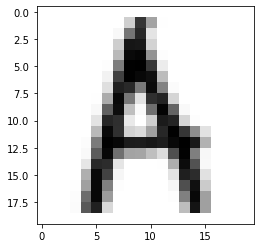

In [29]:
display_image(showing_x_train_20x20[0])

In [93]:
y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [94]:
import csv

label_map = 'ABCÇDEƏFGHIJKQLMNOPRSŞTUVXYZ'

def save_a_dict(dictionary, file_name):
    #w = csv.writer(open("file_name", "w", encoding="utf-8"))
    #for key, val in dictionary.items():
        #w.writerow([key, val])
        
    with open(file_name, 'w', encoding="utf-8") as csvfile: 
        csvwriter = csv.writer(csvfile) 
        for key, val in dictionary.items():
            csvwriter.writerow([key, val]) 

def find_count_of_each_letter_class(indices_cluster, y = y_train, lb = None):
    global label_map
    
    y_in_cluster = np.argmax(y_train, axis = 1)[indices_cluster]
    unique, counts = np.unique(y_in_cluster, return_counts=True)
    
    new_unique = []
    for i in range(len(unique)):
        new_unique.append(label_map[unique[i]])
    new_unique = np.array(new_unique, dtype='str')
    print(dict(zip(new_unique, counts)))
    save_a_dict(dict(zip(new_unique, counts)), OUTPUT_PATH + str(lb) + '.csv')
    return -1

indices_clusters = []
for cluster_index in range(28):
    logical_list_cluster_i = (kmeans.labels_ == cluster_index)
    #print(len(logical_list_cluster_i))
    for i in range(len(logical_list_cluster_i)):
        
        if logical_list_cluster_i[i] == True:
            if len(indices_clusters) < cluster_index + 1:
                indices_clusters.append([])
            indices_clusters[cluster_index].append(i)
            #print(indices_clusters[cluster_index])
            #print(i, logical_list_cluster_i[i])
            
for i in range(len(indices_clusters)):
    #print(len(indices_cluster))
    find_count_of_each_letter_class(indices_clusters[i], y = y_train, lb = i + 1)
    

{'A': 1, 'B': 5, 'D': 99, 'E': 5, 'Ə': 11, 'H': 1, 'I': 2, 'J': 5, 'K': 2, 'Q': 6, 'L': 2, 'R': 4, 'S': 3, 'Ş': 1, 'T': 1, 'U': 2, 'Z': 90}
{'B': 12, 'C': 45, 'Ç': 39, 'D': 73, 'Ə': 6, 'G': 57, 'J': 1, 'N': 168, 'O': 2, 'P': 124, 'R': 2, 'Ş': 1, 'U': 18}
{'A': 4, 'B': 13, 'D': 2, 'E': 1, 'Ə': 1, 'H': 229, 'J': 1, 'K': 4, 'Q': 2, 'L': 32, 'M': 67, 'P': 4, 'R': 9, 'S': 1, 'U': 70, 'V': 3, 'Y': 9}
{'A': 25, 'D': 2, 'H': 1, 'J': 2, 'K': 21, 'Q': 4, 'M': 3, 'R': 5, 'T': 1, 'U': 2, 'V': 4, 'X': 368, 'Y': 16, 'Z': 18}
{'A': 9, 'B': 2, 'Ç': 1, 'Ə': 1, 'F': 2, 'G': 1, 'H': 72, 'J': 6, 'K': 13, 'L': 28, 'M': 206, 'O': 7, 'P': 7, 'R': 7, 'U': 19, 'V': 25, 'X': 2, 'Y': 14, 'Z': 4}
{'A': 4, 'D': 2, 'Ə': 4, 'F': 1, 'I': 309, 'J': 35, 'Q': 7, 'S': 11, 'Ş': 11, 'T': 161, 'U': 1, 'V': 1, 'X': 4, 'Y': 5, 'Z': 23}
{'A': 69, 'B': 75, 'C': 3, 'Ç': 2, 'D': 21, 'E': 47, 'Ə': 2, 'F': 68, 'G': 3, 'H': 49, 'K': 55, 'Q': 10, 'L': 21, 'M': 61, 'N': 10, 'O': 101, 'P': 7, 'R': 91, 'S': 3, 'Ş': 2, 'T': 11, 'U': 7, '

Letter-1_1.png
Letter-1_2.png
Letter-1_3.png
Letter-1_4.png
Letter-1_5.png
Letter-1_6.png
Letter-1_7.png
Letter-1_8.png
Letter-1_9.png
Letter-1_10.png
Letter-1_11.png
Letter-1_12.png
Letter-1_13.png
Letter-1_14.png
Letter-1_15.png
Letter-1_16.png
Letter-1_17.png
Letter-1_18.png
Letter-1_19.png
Letter-1_20.png
Letter-1_21.png
Letter-1_22.png
Letter-1_23.png
Letter-1_24.png
Letter-1_25.png
Letter-1_26.png
Letter-1_27.png
Letter-1_28.png
Letter-1_29.png
Letter-1_30.png
Letter-1_31.png
Letter-1_32.png
Letter-1_33.png
Letter-1_34.png
Letter-1_35.png
Letter-1_36.png
Letter-1_37.png
Letter-1_38.png
Letter-1_39.png
Letter-1_40.png
Letter-1_41.png
Letter-1_42.png
Letter-1_43.png
Letter-1_44.png
Letter-1_45.png
Letter-1_46.png
Letter-1_47.png
Letter-1_48.png
Letter-1_49.png
Letter-1_50.png
Letter-1_51.png
Letter-1_52.png
Letter-1_53.png
Letter-1_54.png
Letter-1_55.png
Letter-1_56.png
Letter-1_57.png
Letter-1_58.png
Letter-1_59.png
Letter-1_60.png
Letter-1_61.png
Letter-1_62.png
Letter-1_63.png
L

Letter-2_256.png
Letter-2_257.png
Letter-2_258.png
Letter-2_259.png
Letter-2_260.png
Letter-2_261.png
Letter-2_262.png
Letter-2_263.png
Letter-2_264.png
Letter-2_265.png
Letter-2_266.png
Letter-2_267.png
Letter-2_268.png
Letter-2_269.png
Letter-2_270.png
Letter-2_271.png
Letter-2_272.png
Letter-2_273.png
Letter-2_274.png
Letter-2_275.png
Letter-2_276.png
Letter-2_277.png
Letter-2_278.png
Letter-2_279.png
Letter-2_280.png
Letter-2_281.png
Letter-2_282.png
Letter-2_283.png
Letter-2_284.png
Letter-2_285.png
Letter-2_286.png
Letter-2_287.png
Letter-2_288.png
Letter-2_289.png
Letter-2_290.png
Letter-2_291.png
Letter-2_292.png
Letter-2_293.png
Letter-2_294.png
Letter-2_295.png
Letter-2_296.png
Letter-2_297.png
Letter-2_298.png
Letter-2_299.png
Letter-2_300.png
Letter-2_301.png
Letter-2_302.png
Letter-2_303.png
Letter-2_304.png
Letter-2_305.png
Letter-2_306.png
Letter-2_307.png
Letter-2_308.png
Letter-2_309.png
Letter-2_310.png
Letter-2_311.png
Letter-2_312.png
Letter-2_313.png
Letter-2_314.p

Letter-3_198.png
Letter-3_199.png
Letter-3_200.png
Letter-3_201.png
Letter-3_202.png
Letter-3_203.png
Letter-3_204.png
Letter-3_205.png
Letter-3_206.png
Letter-3_207.png
Letter-3_208.png
Letter-3_209.png
Letter-3_210.png
Letter-3_211.png
Letter-3_212.png
Letter-3_213.png
Letter-3_214.png
Letter-3_215.png
Letter-3_216.png
Letter-3_217.png
Letter-3_218.png
Letter-3_219.png
Letter-3_220.png
Letter-3_221.png
Letter-3_222.png
Letter-3_223.png
Letter-3_224.png
Letter-3_225.png
Letter-3_226.png
Letter-3_227.png
Letter-3_228.png
Letter-3_229.png
Letter-3_230.png
Letter-3_231.png
Letter-3_232.png
Letter-3_233.png
Letter-3_234.png
Letter-3_235.png
Letter-3_236.png
Letter-3_237.png
Letter-3_238.png
Letter-3_239.png
Letter-3_240.png
Letter-3_241.png
Letter-3_242.png
Letter-3_243.png
Letter-3_244.png
Letter-3_245.png
Letter-3_246.png
Letter-3_247.png
Letter-3_248.png
Letter-3_249.png
Letter-3_250.png
Letter-3_251.png
Letter-3_252.png
Letter-3_253.png
Letter-3_254.png
Letter-3_255.png
Letter-3_256.p

Letter-4_235.png
Letter-4_236.png
Letter-4_237.png
Letter-4_238.png
Letter-4_239.png
Letter-4_240.png
Letter-4_241.png
Letter-4_242.png
Letter-4_243.png
Letter-4_244.png
Letter-4_245.png
Letter-4_246.png
Letter-4_247.png
Letter-4_248.png
Letter-4_249.png
Letter-4_250.png
Letter-4_251.png
Letter-4_252.png
Letter-4_253.png
Letter-4_254.png
Letter-4_255.png
Letter-4_256.png
Letter-4_257.png
Letter-4_258.png
Letter-4_259.png
Letter-4_260.png
Letter-4_261.png
Letter-4_262.png
Letter-4_263.png
Letter-4_264.png
Letter-4_265.png
Letter-4_266.png
Letter-4_267.png
Letter-4_268.png
Letter-4_269.png
Letter-4_270.png
Letter-4_271.png
Letter-4_272.png
Letter-4_273.png
Letter-4_274.png
Letter-4_275.png
Letter-4_276.png
Letter-4_277.png
Letter-4_278.png
Letter-4_279.png
Letter-4_280.png
Letter-4_281.png
Letter-4_282.png
Letter-4_283.png
Letter-4_284.png
Letter-4_285.png
Letter-4_286.png
Letter-4_287.png
Letter-4_288.png
Letter-4_289.png
Letter-4_290.png
Letter-4_291.png
Letter-4_292.png
Letter-4_293.p

Letter-5_252.png
Letter-5_253.png
Letter-5_254.png
Letter-5_255.png
Letter-5_256.png
Letter-5_257.png
Letter-5_258.png
Letter-5_259.png
Letter-5_260.png
Letter-5_261.png
Letter-5_262.png
Letter-5_263.png
Letter-5_264.png
Letter-5_265.png
Letter-5_266.png
Letter-5_267.png
Letter-5_268.png
Letter-5_269.png
Letter-5_270.png
Letter-5_271.png
Letter-5_272.png
Letter-5_273.png
Letter-5_274.png
Letter-5_275.png
Letter-5_276.png
Letter-5_277.png
Letter-5_278.png
Letter-5_279.png
Letter-5_280.png
Letter-5_281.png
Letter-5_282.png
Letter-5_283.png
Letter-5_284.png
Letter-5_285.png
Letter-5_286.png
Letter-5_287.png
Letter-5_288.png
Letter-5_289.png
Letter-5_290.png
Letter-5_291.png
Letter-5_292.png
Letter-5_293.png
Letter-5_294.png
Letter-5_295.png
Letter-5_296.png
Letter-5_297.png
Letter-5_298.png
Letter-5_299.png
Letter-5_300.png
Letter-5_301.png
Letter-5_302.png
Letter-5_303.png
Letter-5_304.png
Letter-5_305.png
Letter-5_306.png
Letter-5_307.png
Letter-5_308.png
Letter-5_309.png
Letter-5_310.p

Letter-6_315.png
Letter-6_316.png
Letter-6_317.png
Letter-6_318.png
Letter-6_319.png
Letter-6_320.png
Letter-6_321.png
Letter-6_322.png
Letter-6_323.png
Letter-6_324.png
Letter-6_325.png
Letter-6_326.png
Letter-6_327.png
Letter-6_328.png
Letter-6_329.png
Letter-6_330.png
Letter-6_331.png
Letter-6_332.png
Letter-6_333.png
Letter-6_334.png
Letter-6_335.png
Letter-6_336.png
Letter-6_337.png
Letter-6_338.png
Letter-6_339.png
Letter-6_340.png
Letter-6_341.png
Letter-6_342.png
Letter-6_343.png
Letter-6_344.png
Letter-6_345.png
Letter-6_346.png
Letter-6_347.png
Letter-6_348.png
Letter-6_349.png
Letter-6_350.png
Letter-6_351.png
Letter-6_352.png
Letter-6_353.png
Letter-6_354.png
Letter-6_355.png
Letter-6_356.png
Letter-6_357.png
Letter-6_358.png
Letter-6_359.png
Letter-6_360.png
Letter-6_361.png
Letter-6_362.png
Letter-6_363.png
Letter-6_364.png
Letter-6_365.png
Letter-6_366.png
Letter-6_367.png
Letter-6_368.png
Letter-6_369.png
Letter-6_370.png
Letter-6_371.png
Letter-6_372.png
Letter-6_373.p

Letter-7_225.png
Letter-7_226.png
Letter-7_227.png
Letter-7_228.png
Letter-7_229.png
Letter-7_230.png
Letter-7_231.png
Letter-7_232.png
Letter-7_233.png
Letter-7_234.png
Letter-7_235.png
Letter-7_236.png
Letter-7_237.png
Letter-7_238.png
Letter-7_239.png
Letter-7_240.png
Letter-7_241.png
Letter-7_242.png
Letter-7_243.png
Letter-7_244.png
Letter-7_245.png
Letter-7_246.png
Letter-7_247.png
Letter-7_248.png
Letter-7_249.png
Letter-7_250.png
Letter-7_251.png
Letter-7_252.png
Letter-7_253.png
Letter-7_254.png
Letter-7_255.png
Letter-7_256.png
Letter-7_257.png
Letter-7_258.png
Letter-7_259.png
Letter-7_260.png
Letter-7_261.png
Letter-7_262.png
Letter-7_263.png
Letter-7_264.png
Letter-7_265.png
Letter-7_266.png
Letter-7_267.png
Letter-7_268.png
Letter-7_269.png
Letter-7_270.png
Letter-7_271.png
Letter-7_272.png
Letter-7_273.png
Letter-7_274.png
Letter-7_275.png
Letter-7_276.png
Letter-7_277.png
Letter-7_278.png
Letter-7_279.png
Letter-7_280.png
Letter-7_281.png
Letter-7_282.png
Letter-7_283.p

Letter-7_707.png
Letter-7_708.png
Letter-7_709.png
Letter-7_710.png
Letter-7_711.png
Letter-7_712.png
Letter-7_713.png
Letter-7_714.png
Letter-7_715.png
Letter-7_716.png
Letter-7_717.png
Letter-7_718.png
Letter-7_719.png
Letter-7_720.png
Letter-7_721.png
Letter-7_722.png
Letter-7_723.png
Letter-7_724.png
Letter-7_725.png
Letter-7_726.png
Letter-7_727.png
Letter-7_728.png
Letter-7_729.png
Letter-7_730.png
Letter-7_731.png
Letter-8_1.png
Letter-8_2.png
Letter-8_3.png
Letter-8_4.png
Letter-8_5.png
Letter-8_6.png
Letter-8_7.png
Letter-8_8.png
Letter-8_9.png
Letter-8_10.png
Letter-8_11.png
Letter-8_12.png
Letter-8_13.png
Letter-8_14.png
Letter-8_15.png
Letter-8_16.png
Letter-8_17.png
Letter-8_18.png
Letter-8_19.png
Letter-8_20.png
Letter-8_21.png
Letter-8_22.png
Letter-8_23.png
Letter-8_24.png
Letter-8_25.png
Letter-8_26.png
Letter-8_27.png
Letter-8_28.png
Letter-8_29.png
Letter-8_30.png
Letter-8_31.png
Letter-8_32.png
Letter-8_33.png
Letter-8_34.png
Letter-8_35.png
Letter-8_36.png
Letter-8

Letter-8_466.png
Letter-8_467.png
Letter-8_468.png
Letter-8_469.png
Letter-8_470.png
Letter-8_471.png
Letter-8_472.png
Letter-8_473.png
Letter-8_474.png
Letter-8_475.png
Letter-8_476.png
Letter-8_477.png
Letter-8_478.png
Letter-8_479.png
Letter-8_480.png
Letter-8_481.png
Letter-8_482.png
Letter-8_483.png
Letter-8_484.png
Letter-8_485.png
Letter-8_486.png
Letter-8_487.png
Letter-8_488.png
Letter-8_489.png
Letter-8_490.png
Letter-8_491.png
Letter-8_492.png
Letter-8_493.png
Letter-8_494.png
Letter-8_495.png
Letter-9_1.png
Letter-9_2.png
Letter-9_3.png
Letter-9_4.png
Letter-9_5.png
Letter-9_6.png
Letter-9_7.png
Letter-9_8.png
Letter-9_9.png
Letter-9_10.png
Letter-9_11.png
Letter-9_12.png
Letter-9_13.png
Letter-9_14.png
Letter-9_15.png
Letter-9_16.png
Letter-9_17.png
Letter-9_18.png
Letter-9_19.png
Letter-9_20.png
Letter-9_21.png
Letter-9_22.png
Letter-9_23.png
Letter-9_24.png
Letter-9_25.png
Letter-9_26.png
Letter-9_27.png
Letter-9_28.png
Letter-9_29.png
Letter-9_30.png
Letter-9_31.png
Let

Letter-9_460.png
Letter-9_461.png
Letter-9_462.png
Letter-9_463.png
Letter-9_464.png
Letter-9_465.png
Letter-9_466.png
Letter-9_467.png
Letter-9_468.png
Letter-9_469.png
Letter-9_470.png
Letter-9_471.png
Letter-9_472.png
Letter-9_473.png
Letter-9_474.png
Letter-9_475.png
Letter-9_476.png
Letter-9_477.png
Letter-9_478.png
Letter-9_479.png
Letter-9_480.png
Letter-9_481.png
Letter-9_482.png
Letter-9_483.png
Letter-9_484.png
Letter-9_485.png
Letter-9_486.png
Letter-9_487.png
Letter-9_488.png
Letter-9_489.png
Letter-9_490.png
Letter-9_491.png
Letter-9_492.png
Letter-9_493.png
Letter-9_494.png
Letter-9_495.png
Letter-9_496.png
Letter-9_497.png
Letter-9_498.png
Letter-9_499.png
Letter-9_500.png
Letter-9_501.png
Letter-9_502.png
Letter-9_503.png
Letter-9_504.png
Letter-9_505.png
Letter-9_506.png
Letter-9_507.png
Letter-9_508.png
Letter-9_509.png
Letter-9_510.png
Letter-9_511.png
Letter-9_512.png
Letter-9_513.png
Letter-9_514.png
Letter-9_515.png
Letter-9_516.png
Letter-9_517.png
Letter-9_518.p

Letter-10_312.png
Letter-10_313.png
Letter-10_314.png
Letter-10_315.png
Letter-10_316.png
Letter-10_317.png
Letter-10_318.png
Letter-10_319.png
Letter-10_320.png
Letter-10_321.png
Letter-10_322.png
Letter-10_323.png
Letter-10_324.png
Letter-10_325.png
Letter-10_326.png
Letter-10_327.png
Letter-10_328.png
Letter-10_329.png
Letter-10_330.png
Letter-10_331.png
Letter-10_332.png
Letter-10_333.png
Letter-10_334.png
Letter-10_335.png
Letter-10_336.png
Letter-10_337.png
Letter-10_338.png
Letter-10_339.png
Letter-10_340.png
Letter-10_341.png
Letter-10_342.png
Letter-10_343.png
Letter-10_344.png
Letter-10_345.png
Letter-10_346.png
Letter-10_347.png
Letter-10_348.png
Letter-10_349.png
Letter-10_350.png
Letter-10_351.png
Letter-10_352.png
Letter-10_353.png
Letter-10_354.png
Letter-10_355.png
Letter-10_356.png
Letter-10_357.png
Letter-10_358.png
Letter-10_359.png
Letter-10_360.png
Letter-10_361.png
Letter-10_362.png
Letter-10_363.png
Letter-10_364.png
Letter-10_365.png
Letter-10_366.png
Letter-10_

Letter-12_41.png
Letter-12_42.png
Letter-12_43.png
Letter-12_44.png
Letter-12_45.png
Letter-12_46.png
Letter-12_47.png
Letter-12_48.png
Letter-12_49.png
Letter-12_50.png
Letter-12_51.png
Letter-12_52.png
Letter-12_53.png
Letter-12_54.png
Letter-12_55.png
Letter-12_56.png
Letter-12_57.png
Letter-12_58.png
Letter-12_59.png
Letter-12_60.png
Letter-12_61.png
Letter-12_62.png
Letter-12_63.png
Letter-12_64.png
Letter-12_65.png
Letter-12_66.png
Letter-12_67.png
Letter-12_68.png
Letter-12_69.png
Letter-12_70.png
Letter-12_71.png
Letter-12_72.png
Letter-12_73.png
Letter-12_74.png
Letter-12_75.png
Letter-12_76.png
Letter-12_77.png
Letter-12_78.png
Letter-12_79.png
Letter-12_80.png
Letter-12_81.png
Letter-12_82.png
Letter-12_83.png
Letter-12_84.png
Letter-12_85.png
Letter-12_86.png
Letter-12_87.png
Letter-12_88.png
Letter-12_89.png
Letter-12_90.png
Letter-12_91.png
Letter-12_92.png
Letter-12_93.png
Letter-12_94.png
Letter-12_95.png
Letter-12_96.png
Letter-12_97.png
Letter-12_98.png
Letter-12_99.p

Letter-12_502.png
Letter-12_503.png
Letter-12_504.png
Letter-12_505.png
Letter-12_506.png
Letter-12_507.png
Letter-12_508.png
Letter-12_509.png
Letter-12_510.png
Letter-12_511.png
Letter-12_512.png
Letter-12_513.png
Letter-12_514.png
Letter-12_515.png
Letter-12_516.png
Letter-12_517.png
Letter-12_518.png
Letter-12_519.png
Letter-12_520.png
Letter-12_521.png
Letter-12_522.png
Letter-12_523.png
Letter-12_524.png
Letter-12_525.png
Letter-12_526.png
Letter-12_527.png
Letter-12_528.png
Letter-12_529.png
Letter-12_530.png
Letter-12_531.png
Letter-12_532.png
Letter-12_533.png
Letter-12_534.png
Letter-12_535.png
Letter-12_536.png
Letter-12_537.png
Letter-12_538.png
Letter-12_539.png
Letter-12_540.png
Letter-12_541.png
Letter-12_542.png
Letter-12_543.png
Letter-12_544.png
Letter-12_545.png
Letter-12_546.png
Letter-12_547.png
Letter-12_548.png
Letter-12_549.png
Letter-12_550.png
Letter-12_551.png
Letter-12_552.png
Letter-12_553.png
Letter-12_554.png
Letter-12_555.png
Letter-12_556.png
Letter-12_

Letter-13_68.png
Letter-13_69.png
Letter-13_70.png
Letter-13_71.png
Letter-13_72.png
Letter-13_73.png
Letter-13_74.png
Letter-13_75.png
Letter-13_76.png
Letter-13_77.png
Letter-13_78.png
Letter-13_79.png
Letter-13_80.png
Letter-13_81.png
Letter-13_82.png
Letter-13_83.png
Letter-13_84.png
Letter-13_85.png
Letter-13_86.png
Letter-13_87.png
Letter-13_88.png
Letter-13_89.png
Letter-13_90.png
Letter-13_91.png
Letter-13_92.png
Letter-13_93.png
Letter-13_94.png
Letter-13_95.png
Letter-13_96.png
Letter-13_97.png
Letter-13_98.png
Letter-13_99.png
Letter-13_100.png
Letter-13_101.png
Letter-13_102.png
Letter-13_103.png
Letter-13_104.png
Letter-13_105.png
Letter-13_106.png
Letter-13_107.png
Letter-13_108.png
Letter-13_109.png
Letter-13_110.png
Letter-13_111.png
Letter-13_112.png
Letter-13_113.png
Letter-13_114.png
Letter-13_115.png
Letter-13_116.png
Letter-13_117.png
Letter-13_118.png
Letter-13_119.png
Letter-13_120.png
Letter-13_121.png
Letter-13_122.png
Letter-13_123.png
Letter-13_124.png
Letter

Letter-14_124.png
Letter-14_125.png
Letter-14_126.png
Letter-14_127.png
Letter-14_128.png
Letter-14_129.png
Letter-14_130.png
Letter-14_131.png
Letter-14_132.png
Letter-14_133.png
Letter-14_134.png
Letter-14_135.png
Letter-14_136.png
Letter-14_137.png
Letter-14_138.png
Letter-14_139.png
Letter-14_140.png
Letter-14_141.png
Letter-14_142.png
Letter-14_143.png
Letter-14_144.png
Letter-14_145.png
Letter-14_146.png
Letter-14_147.png
Letter-14_148.png
Letter-14_149.png
Letter-14_150.png
Letter-14_151.png
Letter-14_152.png
Letter-14_153.png
Letter-14_154.png
Letter-14_155.png
Letter-14_156.png
Letter-14_157.png
Letter-14_158.png
Letter-14_159.png
Letter-14_160.png
Letter-14_161.png
Letter-14_162.png
Letter-14_163.png
Letter-14_164.png
Letter-14_165.png
Letter-14_166.png
Letter-14_167.png
Letter-14_168.png
Letter-14_169.png
Letter-14_170.png
Letter-14_171.png
Letter-14_172.png
Letter-14_173.png
Letter-14_174.png
Letter-14_175.png
Letter-14_176.png
Letter-14_177.png
Letter-14_178.png
Letter-14_

Letter-15_157.png
Letter-15_158.png
Letter-15_159.png
Letter-15_160.png
Letter-15_161.png
Letter-15_162.png
Letter-15_163.png
Letter-15_164.png
Letter-15_165.png
Letter-15_166.png
Letter-15_167.png
Letter-15_168.png
Letter-15_169.png
Letter-15_170.png
Letter-15_171.png
Letter-15_172.png
Letter-15_173.png
Letter-15_174.png
Letter-15_175.png
Letter-15_176.png
Letter-15_177.png
Letter-15_178.png
Letter-15_179.png
Letter-15_180.png
Letter-15_181.png
Letter-15_182.png
Letter-15_183.png
Letter-15_184.png
Letter-15_185.png
Letter-15_186.png
Letter-15_187.png
Letter-15_188.png
Letter-15_189.png
Letter-15_190.png
Letter-15_191.png
Letter-15_192.png
Letter-15_193.png
Letter-15_194.png
Letter-15_195.png
Letter-15_196.png
Letter-15_197.png
Letter-15_198.png
Letter-15_199.png
Letter-15_200.png
Letter-15_201.png
Letter-15_202.png
Letter-15_203.png
Letter-15_204.png
Letter-15_205.png
Letter-15_206.png
Letter-15_207.png
Letter-15_208.png
Letter-15_209.png
Letter-15_210.png
Letter-15_211.png
Letter-15_

Letter-16_198.png
Letter-16_199.png
Letter-16_200.png
Letter-16_201.png
Letter-16_202.png
Letter-16_203.png
Letter-16_204.png
Letter-16_205.png
Letter-16_206.png
Letter-16_207.png
Letter-16_208.png
Letter-16_209.png
Letter-16_210.png
Letter-16_211.png
Letter-16_212.png
Letter-16_213.png
Letter-16_214.png
Letter-16_215.png
Letter-16_216.png
Letter-16_217.png
Letter-16_218.png
Letter-16_219.png
Letter-16_220.png
Letter-16_221.png
Letter-16_222.png
Letter-16_223.png
Letter-16_224.png
Letter-16_225.png
Letter-16_226.png
Letter-16_227.png
Letter-16_228.png
Letter-16_229.png
Letter-16_230.png
Letter-16_231.png
Letter-16_232.png
Letter-16_233.png
Letter-16_234.png
Letter-16_235.png
Letter-16_236.png
Letter-16_237.png
Letter-16_238.png
Letter-16_239.png
Letter-16_240.png
Letter-16_241.png
Letter-16_242.png
Letter-16_243.png
Letter-16_244.png
Letter-16_245.png
Letter-16_246.png
Letter-16_247.png
Letter-16_248.png
Letter-16_249.png
Letter-16_250.png
Letter-16_251.png
Letter-16_252.png
Letter-16_

Letter-17_386.png
Letter-17_387.png
Letter-17_388.png
Letter-17_389.png
Letter-17_390.png
Letter-17_391.png
Letter-17_392.png
Letter-17_393.png
Letter-17_394.png
Letter-17_395.png
Letter-17_396.png
Letter-17_397.png
Letter-17_398.png
Letter-17_399.png
Letter-17_400.png
Letter-17_401.png
Letter-17_402.png
Letter-17_403.png
Letter-17_404.png
Letter-17_405.png
Letter-17_406.png
Letter-17_407.png
Letter-17_408.png
Letter-17_409.png
Letter-17_410.png
Letter-17_411.png
Letter-17_412.png
Letter-17_413.png
Letter-17_414.png
Letter-17_415.png
Letter-17_416.png
Letter-17_417.png
Letter-17_418.png
Letter-17_419.png
Letter-17_420.png
Letter-17_421.png
Letter-17_422.png
Letter-17_423.png
Letter-17_424.png
Letter-17_425.png
Letter-17_426.png
Letter-17_427.png
Letter-17_428.png
Letter-17_429.png
Letter-17_430.png
Letter-17_431.png
Letter-17_432.png
Letter-17_433.png
Letter-17_434.png
Letter-17_435.png
Letter-17_436.png
Letter-17_437.png
Letter-17_438.png
Letter-17_439.png
Letter-17_440.png
Letter-17_

Letter-18_328.png
Letter-18_329.png
Letter-18_330.png
Letter-18_331.png
Letter-18_332.png
Letter-18_333.png
Letter-18_334.png
Letter-18_335.png
Letter-18_336.png
Letter-18_337.png
Letter-18_338.png
Letter-18_339.png
Letter-18_340.png
Letter-18_341.png
Letter-18_342.png
Letter-18_343.png
Letter-18_344.png
Letter-18_345.png
Letter-18_346.png
Letter-18_347.png
Letter-18_348.png
Letter-18_349.png
Letter-18_350.png
Letter-18_351.png
Letter-18_352.png
Letter-18_353.png
Letter-18_354.png
Letter-18_355.png
Letter-18_356.png
Letter-18_357.png
Letter-18_358.png
Letter-18_359.png
Letter-18_360.png
Letter-18_361.png
Letter-18_362.png
Letter-18_363.png
Letter-18_364.png
Letter-18_365.png
Letter-18_366.png
Letter-18_367.png
Letter-18_368.png
Letter-18_369.png
Letter-18_370.png
Letter-18_371.png
Letter-18_372.png
Letter-18_373.png
Letter-18_374.png
Letter-18_375.png
Letter-18_376.png
Letter-18_377.png
Letter-18_378.png
Letter-18_379.png
Letter-18_380.png
Letter-18_381.png
Letter-18_382.png
Letter-18_

Letter-19_168.png
Letter-19_169.png
Letter-19_170.png
Letter-19_171.png
Letter-19_172.png
Letter-19_173.png
Letter-19_174.png
Letter-19_175.png
Letter-19_176.png
Letter-19_177.png
Letter-19_178.png
Letter-19_179.png
Letter-19_180.png
Letter-19_181.png
Letter-19_182.png
Letter-19_183.png
Letter-19_184.png
Letter-19_185.png
Letter-19_186.png
Letter-19_187.png
Letter-19_188.png
Letter-19_189.png
Letter-19_190.png
Letter-19_191.png
Letter-19_192.png
Letter-19_193.png
Letter-19_194.png
Letter-19_195.png
Letter-19_196.png
Letter-19_197.png
Letter-19_198.png
Letter-19_199.png
Letter-19_200.png
Letter-19_201.png
Letter-19_202.png
Letter-19_203.png
Letter-19_204.png
Letter-19_205.png
Letter-19_206.png
Letter-19_207.png
Letter-19_208.png
Letter-19_209.png
Letter-19_210.png
Letter-19_211.png
Letter-19_212.png
Letter-19_213.png
Letter-19_214.png
Letter-19_215.png
Letter-19_216.png
Letter-19_217.png
Letter-19_218.png
Letter-19_219.png
Letter-19_220.png
Letter-19_221.png
Letter-19_222.png
Letter-19_

Letter-19_624.png
Letter-19_625.png
Letter-19_626.png
Letter-19_627.png
Letter-19_628.png
Letter-19_629.png
Letter-19_630.png
Letter-20_1.png
Letter-20_2.png
Letter-20_3.png
Letter-20_4.png
Letter-20_5.png
Letter-20_6.png
Letter-20_7.png
Letter-20_8.png
Letter-20_9.png
Letter-20_10.png
Letter-20_11.png
Letter-20_12.png
Letter-20_13.png
Letter-20_14.png
Letter-20_15.png
Letter-20_16.png
Letter-20_17.png
Letter-20_18.png
Letter-20_19.png
Letter-20_20.png
Letter-20_21.png
Letter-20_22.png
Letter-20_23.png
Letter-20_24.png
Letter-20_25.png
Letter-20_26.png
Letter-20_27.png
Letter-20_28.png
Letter-20_29.png
Letter-20_30.png
Letter-20_31.png
Letter-20_32.png
Letter-20_33.png
Letter-20_34.png
Letter-20_35.png
Letter-20_36.png
Letter-20_37.png
Letter-20_38.png
Letter-20_39.png
Letter-20_40.png
Letter-20_41.png
Letter-20_42.png
Letter-20_43.png
Letter-20_44.png
Letter-20_45.png
Letter-20_46.png
Letter-20_47.png
Letter-20_48.png
Letter-20_49.png
Letter-20_50.png
Letter-20_51.png
Letter-20_52.png

Letter-20_456.png
Letter-20_457.png
Letter-20_458.png
Letter-20_459.png
Letter-20_460.png
Letter-20_461.png
Letter-20_462.png
Letter-20_463.png
Letter-20_464.png
Letter-20_465.png
Letter-20_466.png
Letter-20_467.png
Letter-20_468.png
Letter-20_469.png
Letter-20_470.png
Letter-20_471.png
Letter-20_472.png
Letter-20_473.png
Letter-20_474.png
Letter-20_475.png
Letter-20_476.png
Letter-20_477.png
Letter-20_478.png
Letter-20_479.png
Letter-20_480.png
Letter-20_481.png
Letter-20_482.png
Letter-20_483.png
Letter-20_484.png
Letter-20_485.png
Letter-20_486.png
Letter-20_487.png
Letter-20_488.png
Letter-20_489.png
Letter-20_490.png
Letter-20_491.png
Letter-20_492.png
Letter-20_493.png
Letter-20_494.png
Letter-20_495.png
Letter-20_496.png
Letter-20_497.png
Letter-20_498.png
Letter-20_499.png
Letter-20_500.png
Letter-20_501.png
Letter-20_502.png
Letter-20_503.png
Letter-20_504.png
Letter-20_505.png
Letter-20_506.png
Letter-20_507.png
Letter-20_508.png
Letter-20_509.png
Letter-20_510.png
Letter-20_

Letter-21_199.png
Letter-21_200.png
Letter-21_201.png
Letter-21_202.png
Letter-21_203.png
Letter-21_204.png
Letter-21_205.png
Letter-21_206.png
Letter-21_207.png
Letter-21_208.png
Letter-21_209.png
Letter-21_210.png
Letter-21_211.png
Letter-21_212.png
Letter-21_213.png
Letter-21_214.png
Letter-21_215.png
Letter-21_216.png
Letter-21_217.png
Letter-21_218.png
Letter-21_219.png
Letter-21_220.png
Letter-21_221.png
Letter-21_222.png
Letter-21_223.png
Letter-21_224.png
Letter-21_225.png
Letter-21_226.png
Letter-21_227.png
Letter-21_228.png
Letter-21_229.png
Letter-21_230.png
Letter-21_231.png
Letter-21_232.png
Letter-21_233.png
Letter-21_234.png
Letter-21_235.png
Letter-21_236.png
Letter-21_237.png
Letter-21_238.png
Letter-21_239.png
Letter-21_240.png
Letter-21_241.png
Letter-21_242.png
Letter-21_243.png
Letter-21_244.png
Letter-21_245.png
Letter-21_246.png
Letter-21_247.png
Letter-21_248.png
Letter-21_249.png
Letter-21_250.png
Letter-21_251.png
Letter-21_252.png
Letter-21_253.png
Letter-21_

Letter-22_348.png
Letter-22_349.png
Letter-22_350.png
Letter-22_351.png
Letter-22_352.png
Letter-22_353.png
Letter-22_354.png
Letter-22_355.png
Letter-22_356.png
Letter-22_357.png
Letter-22_358.png
Letter-22_359.png
Letter-22_360.png
Letter-22_361.png
Letter-22_362.png
Letter-22_363.png
Letter-22_364.png
Letter-22_365.png
Letter-22_366.png
Letter-22_367.png
Letter-22_368.png
Letter-22_369.png
Letter-22_370.png
Letter-22_371.png
Letter-22_372.png
Letter-22_373.png
Letter-22_374.png
Letter-22_375.png
Letter-22_376.png
Letter-22_377.png
Letter-22_378.png
Letter-22_379.png
Letter-22_380.png
Letter-22_381.png
Letter-22_382.png
Letter-22_383.png
Letter-22_384.png
Letter-22_385.png
Letter-22_386.png
Letter-22_387.png
Letter-22_388.png
Letter-22_389.png
Letter-22_390.png
Letter-22_391.png
Letter-22_392.png
Letter-22_393.png
Letter-22_394.png
Letter-22_395.png
Letter-22_396.png
Letter-22_397.png
Letter-22_398.png
Letter-22_399.png
Letter-22_400.png
Letter-22_401.png
Letter-22_402.png
Letter-22_

Letter-23_207.png
Letter-23_208.png
Letter-23_209.png
Letter-23_210.png
Letter-23_211.png
Letter-23_212.png
Letter-23_213.png
Letter-23_214.png
Letter-23_215.png
Letter-23_216.png
Letter-23_217.png
Letter-23_218.png
Letter-23_219.png
Letter-23_220.png
Letter-23_221.png
Letter-23_222.png
Letter-23_223.png
Letter-23_224.png
Letter-23_225.png
Letter-23_226.png
Letter-23_227.png
Letter-23_228.png
Letter-23_229.png
Letter-23_230.png
Letter-23_231.png
Letter-23_232.png
Letter-23_233.png
Letter-23_234.png
Letter-23_235.png
Letter-23_236.png
Letter-23_237.png
Letter-23_238.png
Letter-23_239.png
Letter-23_240.png
Letter-23_241.png
Letter-23_242.png
Letter-23_243.png
Letter-23_244.png
Letter-23_245.png
Letter-23_246.png
Letter-23_247.png
Letter-23_248.png
Letter-23_249.png
Letter-23_250.png
Letter-23_251.png
Letter-23_252.png
Letter-23_253.png
Letter-23_254.png
Letter-23_255.png
Letter-23_256.png
Letter-23_257.png
Letter-23_258.png
Letter-23_259.png
Letter-23_260.png
Letter-23_261.png
Letter-23_

Letter-24_165.png
Letter-24_166.png
Letter-24_167.png
Letter-24_168.png
Letter-24_169.png
Letter-24_170.png
Letter-24_171.png
Letter-24_172.png
Letter-24_173.png
Letter-24_174.png
Letter-24_175.png
Letter-24_176.png
Letter-24_177.png
Letter-24_178.png
Letter-24_179.png
Letter-24_180.png
Letter-24_181.png
Letter-24_182.png
Letter-24_183.png
Letter-24_184.png
Letter-24_185.png
Letter-24_186.png
Letter-24_187.png
Letter-24_188.png
Letter-24_189.png
Letter-24_190.png
Letter-24_191.png
Letter-24_192.png
Letter-24_193.png
Letter-24_194.png
Letter-24_195.png
Letter-24_196.png
Letter-24_197.png
Letter-24_198.png
Letter-24_199.png
Letter-24_200.png
Letter-24_201.png
Letter-24_202.png
Letter-24_203.png
Letter-24_204.png
Letter-24_205.png
Letter-24_206.png
Letter-24_207.png
Letter-24_208.png
Letter-24_209.png
Letter-24_210.png
Letter-24_211.png
Letter-24_212.png
Letter-24_213.png
Letter-24_214.png
Letter-24_215.png
Letter-24_216.png
Letter-24_217.png
Letter-24_218.png
Letter-24_219.png
Letter-24_

Letter-25_33.png
Letter-25_34.png
Letter-25_35.png
Letter-25_36.png
Letter-25_37.png
Letter-25_38.png
Letter-25_39.png
Letter-25_40.png
Letter-25_41.png
Letter-25_42.png
Letter-25_43.png
Letter-25_44.png
Letter-25_45.png
Letter-25_46.png
Letter-25_47.png
Letter-25_48.png
Letter-25_49.png
Letter-25_50.png
Letter-25_51.png
Letter-25_52.png
Letter-25_53.png
Letter-25_54.png
Letter-25_55.png
Letter-25_56.png
Letter-25_57.png
Letter-25_58.png
Letter-25_59.png
Letter-25_60.png
Letter-25_61.png
Letter-25_62.png
Letter-25_63.png
Letter-25_64.png
Letter-25_65.png
Letter-25_66.png
Letter-25_67.png
Letter-25_68.png
Letter-25_69.png
Letter-25_70.png
Letter-25_71.png
Letter-25_72.png
Letter-25_73.png
Letter-25_74.png
Letter-25_75.png
Letter-25_76.png
Letter-25_77.png
Letter-25_78.png
Letter-25_79.png
Letter-25_80.png
Letter-25_81.png
Letter-25_82.png
Letter-25_83.png
Letter-25_84.png
Letter-25_85.png
Letter-25_86.png
Letter-25_87.png
Letter-25_88.png
Letter-25_89.png
Letter-25_90.png
Letter-25_91.p

Letter-26_21.png
Letter-26_22.png
Letter-26_23.png
Letter-26_24.png
Letter-26_25.png
Letter-26_26.png
Letter-26_27.png
Letter-26_28.png
Letter-26_29.png
Letter-26_30.png
Letter-26_31.png
Letter-26_32.png
Letter-26_33.png
Letter-26_34.png
Letter-26_35.png
Letter-26_36.png
Letter-26_37.png
Letter-26_38.png
Letter-26_39.png
Letter-26_40.png
Letter-26_41.png
Letter-26_42.png
Letter-26_43.png
Letter-26_44.png
Letter-26_45.png
Letter-26_46.png
Letter-26_47.png
Letter-26_48.png
Letter-26_49.png
Letter-26_50.png
Letter-26_51.png
Letter-26_52.png
Letter-26_53.png
Letter-26_54.png
Letter-26_55.png
Letter-26_56.png
Letter-26_57.png
Letter-26_58.png
Letter-26_59.png
Letter-26_60.png
Letter-26_61.png
Letter-26_62.png
Letter-26_63.png
Letter-26_64.png
Letter-26_65.png
Letter-26_66.png
Letter-26_67.png
Letter-26_68.png
Letter-26_69.png
Letter-26_70.png
Letter-26_71.png
Letter-26_72.png
Letter-26_73.png
Letter-26_74.png
Letter-26_75.png
Letter-26_76.png
Letter-26_77.png
Letter-26_78.png
Letter-26_79.p

Letter-26_481.png
Letter-26_482.png
Letter-26_483.png
Letter-26_484.png
Letter-26_485.png
Letter-26_486.png
Letter-26_487.png
Letter-26_488.png
Letter-26_489.png
Letter-26_490.png
Letter-26_491.png
Letter-26_492.png
Letter-26_493.png
Letter-26_494.png
Letter-26_495.png
Letter-26_496.png
Letter-26_497.png
Letter-26_498.png
Letter-26_499.png
Letter-26_500.png
Letter-26_501.png
Letter-26_502.png
Letter-26_503.png
Letter-26_504.png
Letter-26_505.png
Letter-26_506.png
Letter-26_507.png
Letter-26_508.png
Letter-26_509.png
Letter-26_510.png
Letter-26_511.png
Letter-26_512.png
Letter-26_513.png
Letter-26_514.png
Letter-26_515.png
Letter-26_516.png
Letter-26_517.png
Letter-26_518.png
Letter-26_519.png
Letter-26_520.png
Letter-26_521.png
Letter-26_522.png
Letter-26_523.png
Letter-26_524.png
Letter-26_525.png
Letter-26_526.png
Letter-27_1.png
Letter-27_2.png
Letter-27_3.png
Letter-27_4.png
Letter-27_5.png
Letter-27_6.png
Letter-27_7.png
Letter-27_8.png
Letter-27_9.png
Letter-27_10.png
Letter-27_1

Letter-27_417.png
Letter-27_418.png
Letter-27_419.png
Letter-27_420.png
Letter-27_421.png
Letter-27_422.png
Letter-27_423.png
Letter-27_424.png
Letter-27_425.png
Letter-27_426.png
Letter-27_427.png
Letter-27_428.png
Letter-27_429.png
Letter-27_430.png
Letter-27_431.png
Letter-27_432.png
Letter-27_433.png
Letter-27_434.png
Letter-27_435.png
Letter-27_436.png
Letter-27_437.png
Letter-27_438.png
Letter-27_439.png
Letter-27_440.png
Letter-27_441.png
Letter-27_442.png
Letter-27_443.png
Letter-27_444.png
Letter-27_445.png
Letter-28_1.png
Letter-28_2.png
Letter-28_3.png
Letter-28_4.png
Letter-28_5.png
Letter-28_6.png
Letter-28_7.png
Letter-28_8.png
Letter-28_9.png
Letter-28_10.png
Letter-28_11.png
Letter-28_12.png
Letter-28_13.png
Letter-28_14.png
Letter-28_15.png
Letter-28_16.png
Letter-28_17.png
Letter-28_18.png
Letter-28_19.png
Letter-28_20.png
Letter-28_21.png
Letter-28_22.png
Letter-28_23.png
Letter-28_24.png
Letter-28_25.png
Letter-28_26.png
Letter-28_27.png
Letter-28_28.png
Letter-28_2

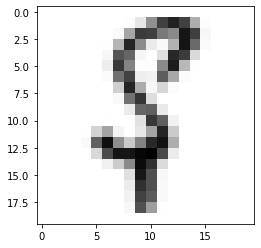

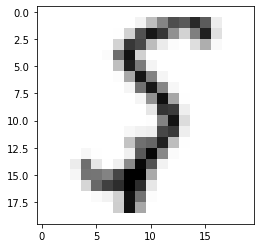

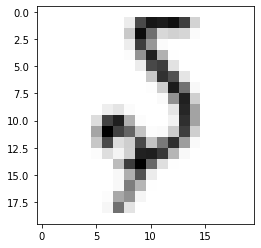

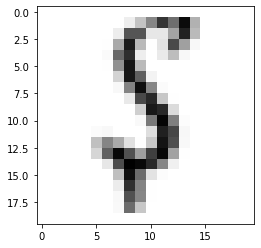

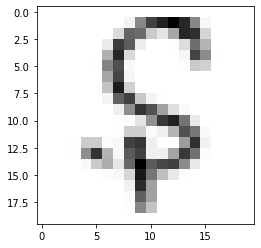

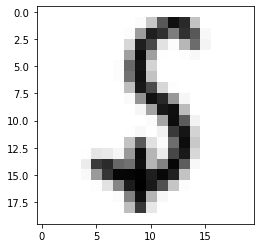

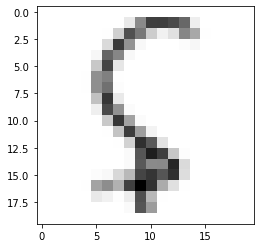

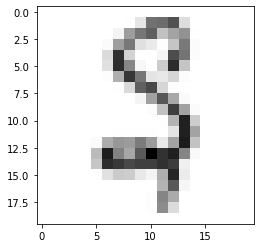

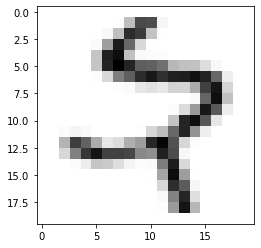

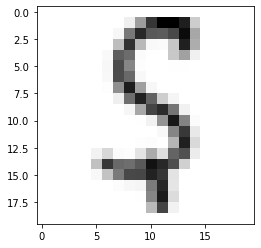

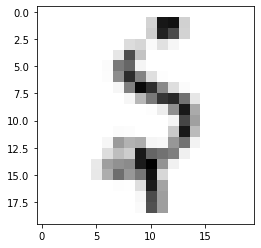

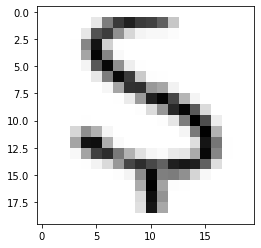

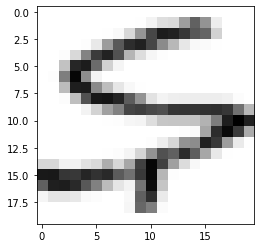

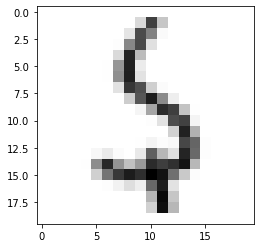

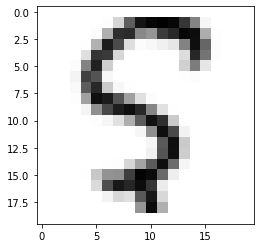

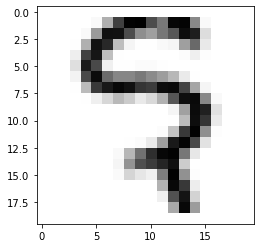

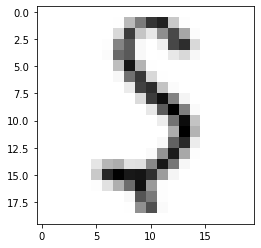

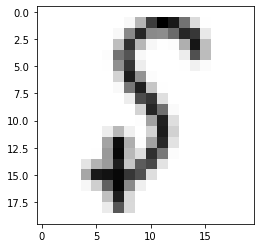

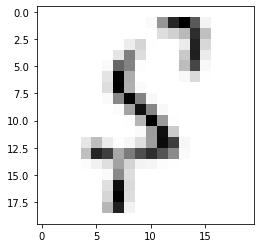

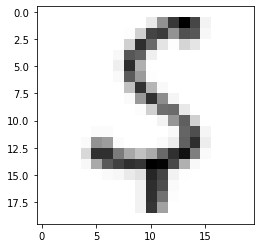

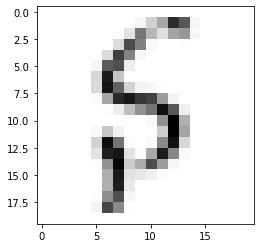

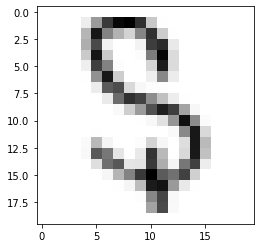

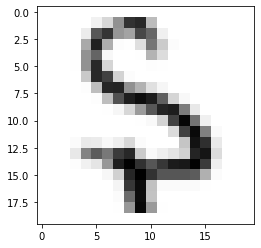

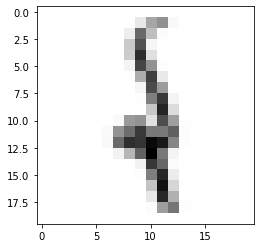

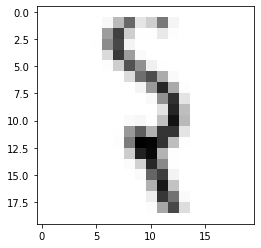

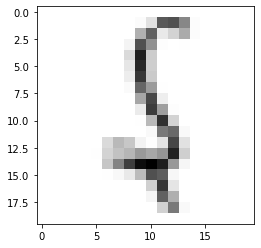

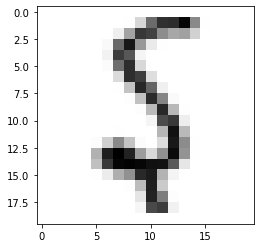

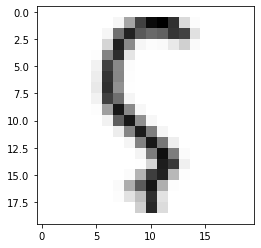

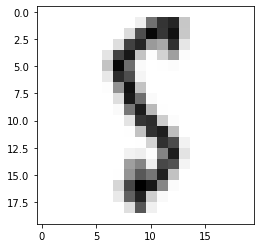

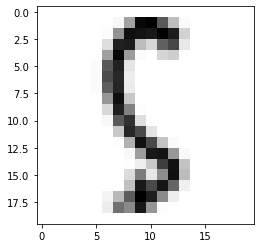

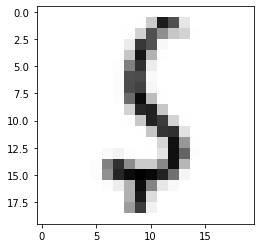

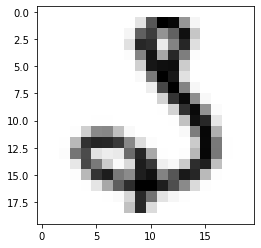

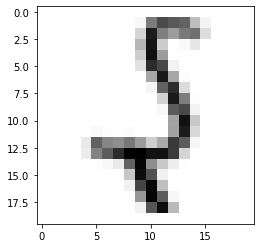

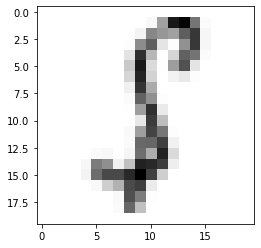

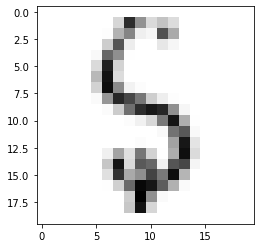

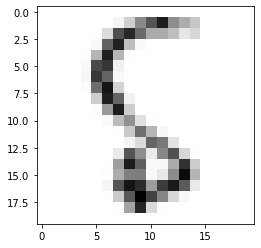

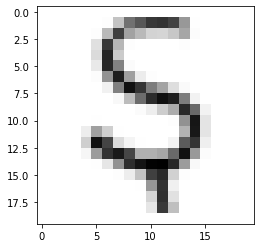

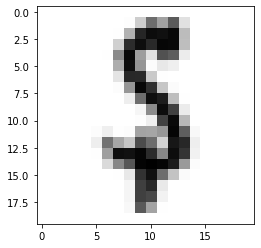

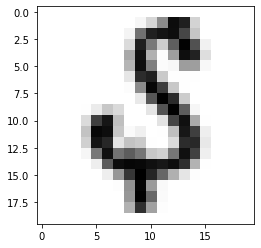

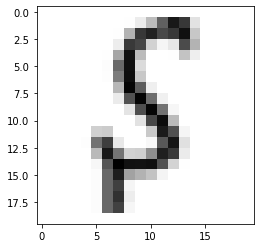

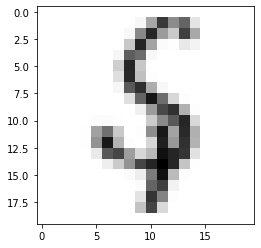

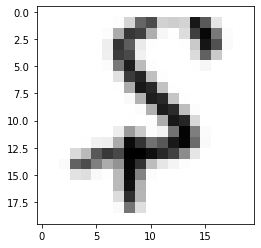

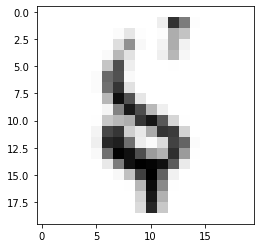

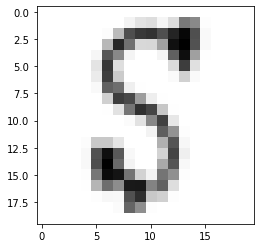

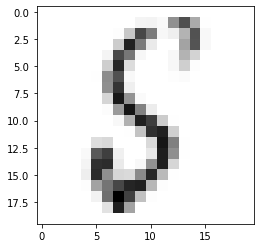

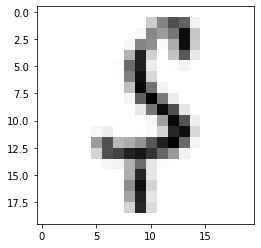

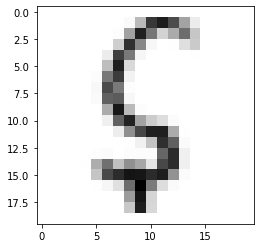

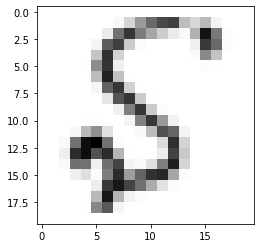

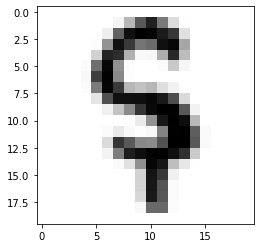

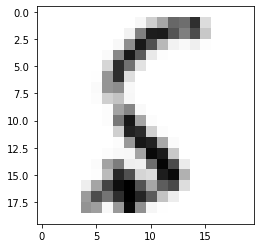

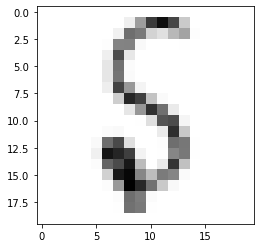

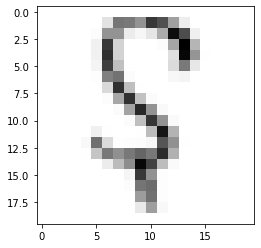

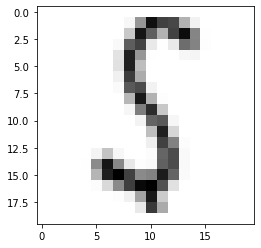

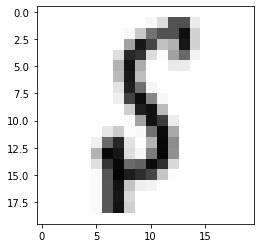

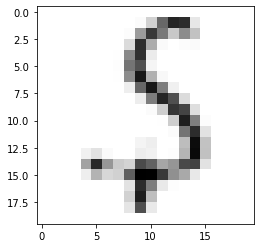

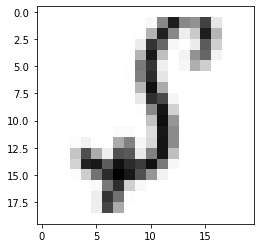

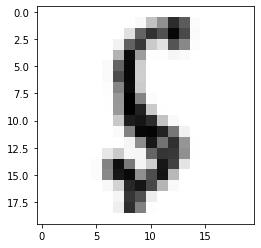

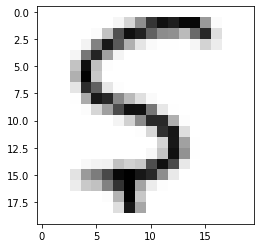

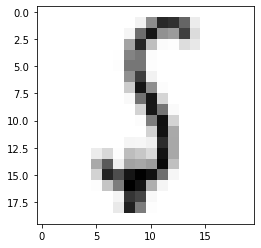

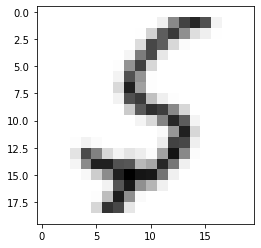

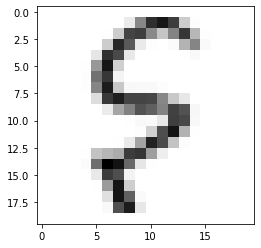

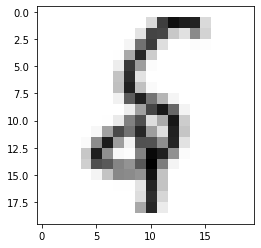

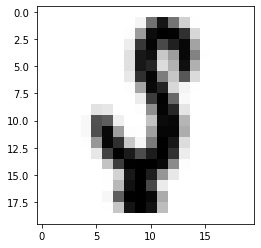

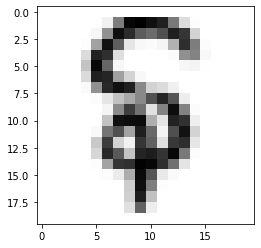

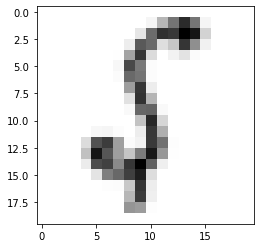

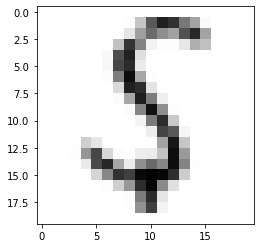

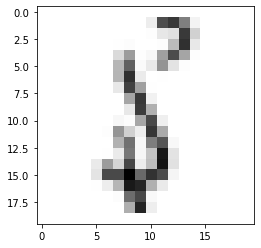

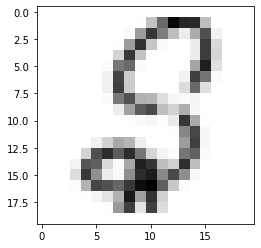

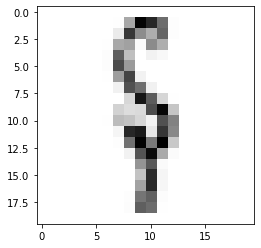

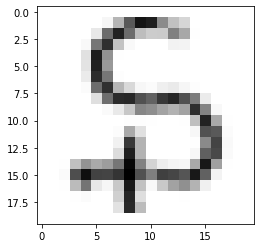

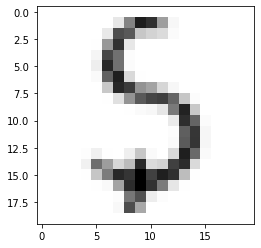

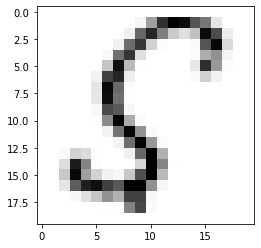

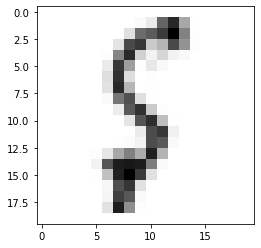

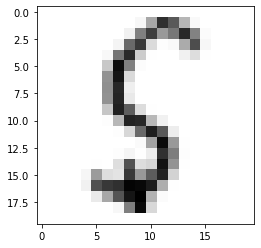

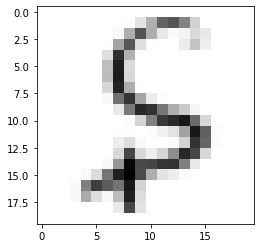

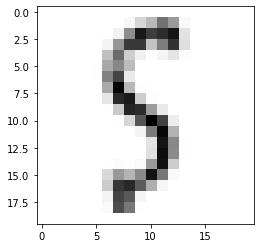

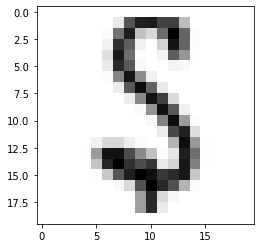

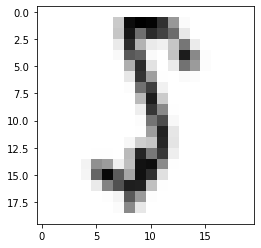

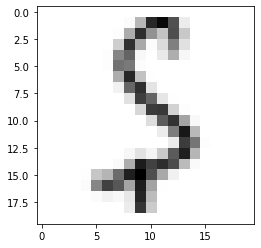

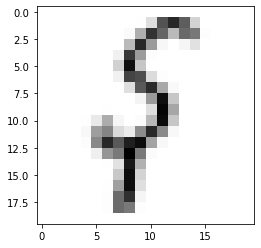

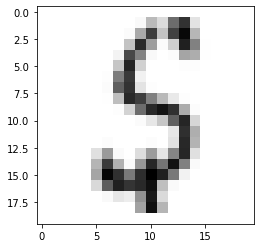

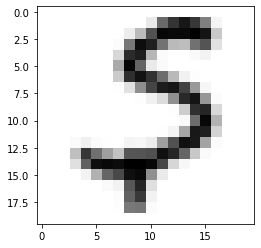

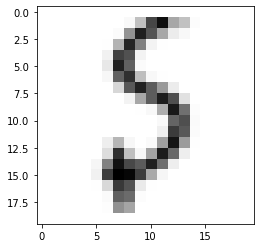

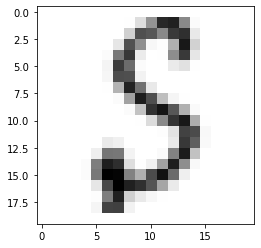

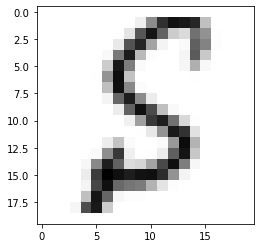

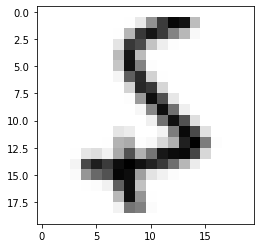

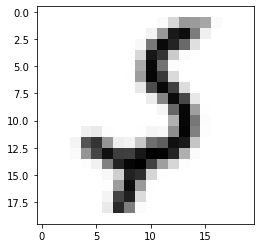

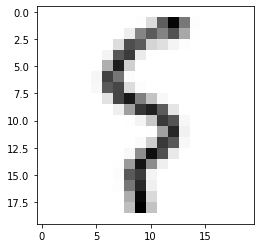

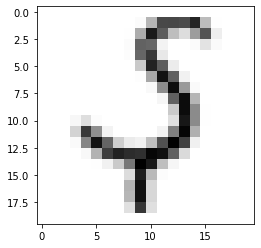

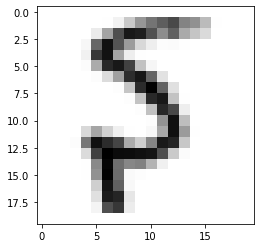

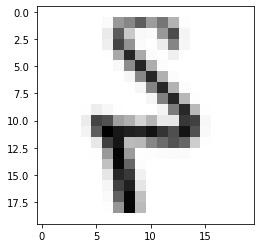

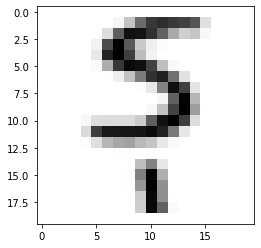

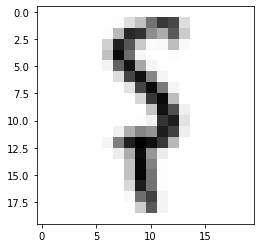

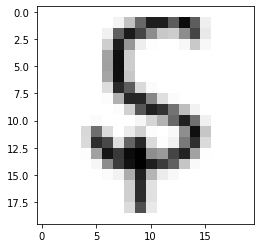

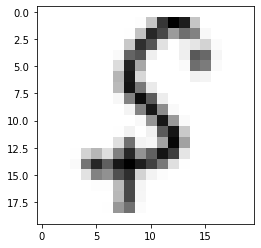

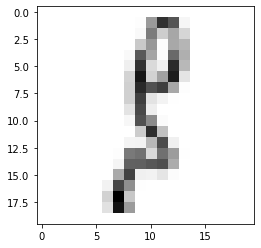

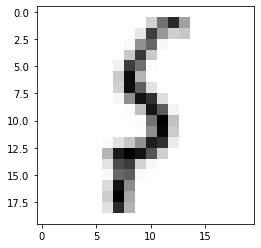

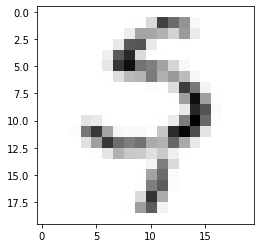

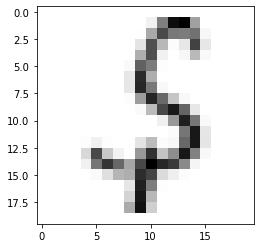

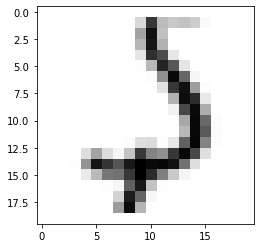

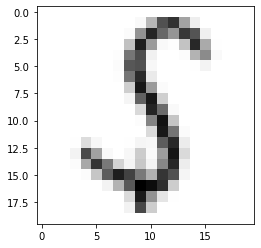

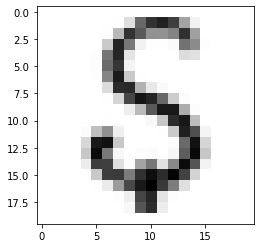

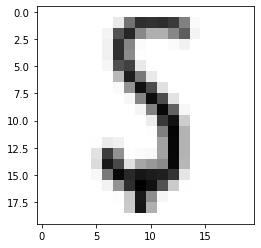

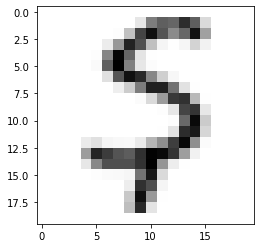

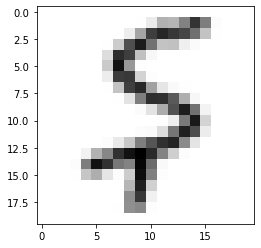

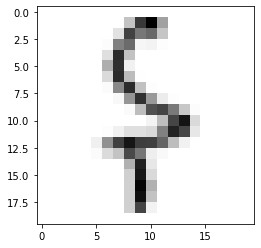

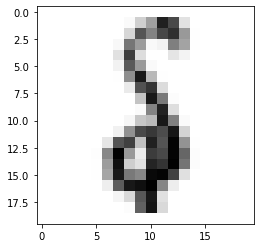

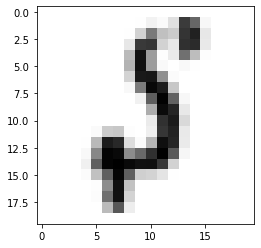

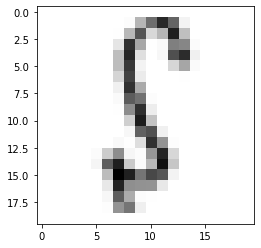

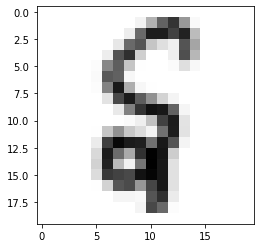

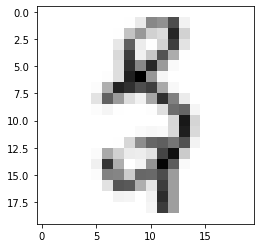

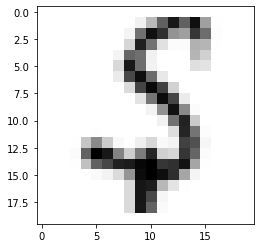

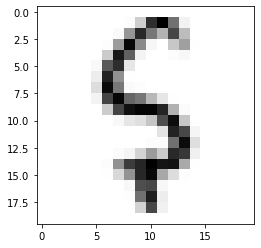

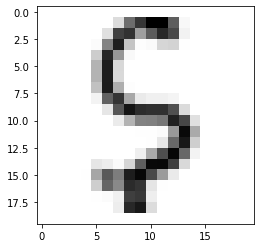

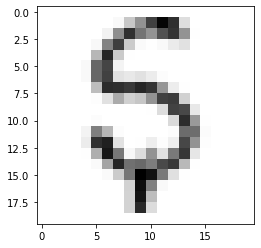

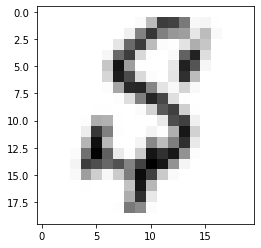

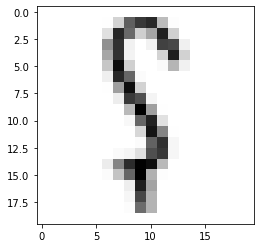

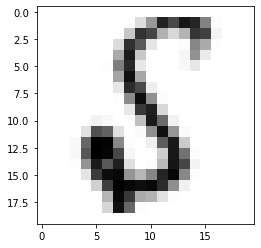

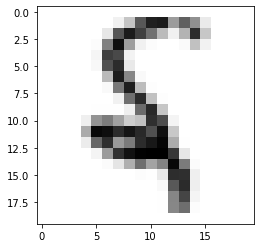

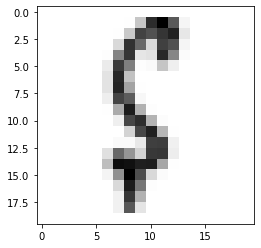

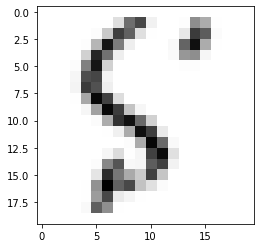

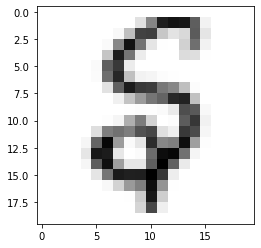

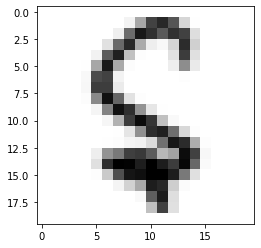

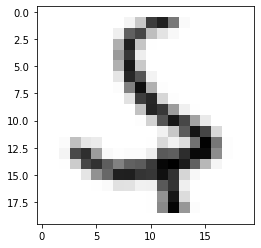

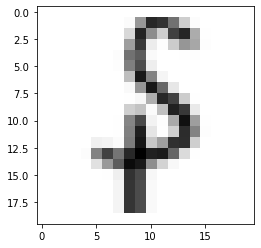

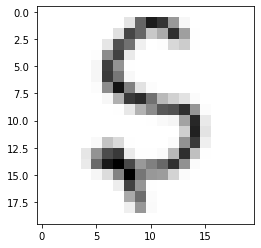

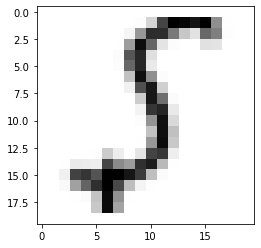

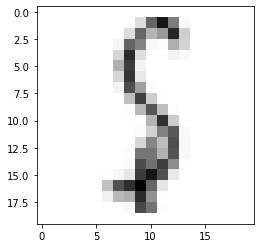

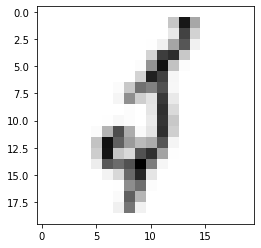

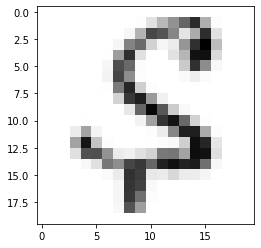

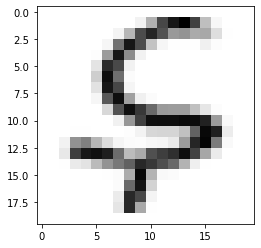

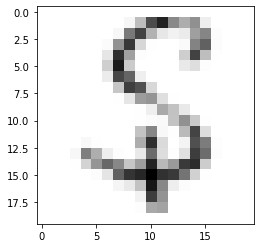

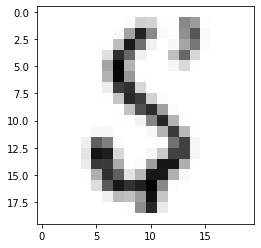

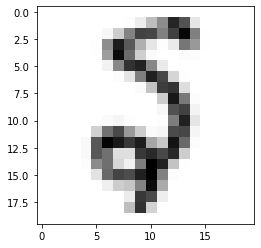

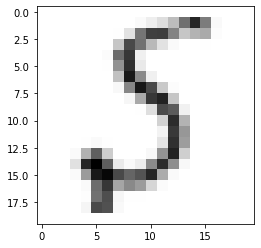

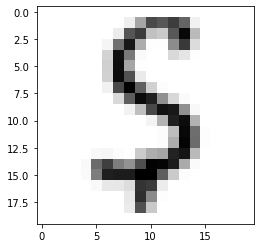

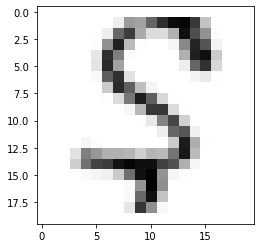

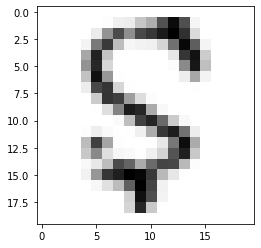

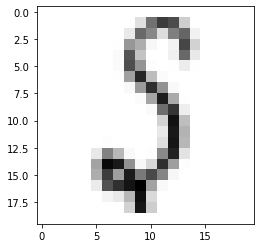

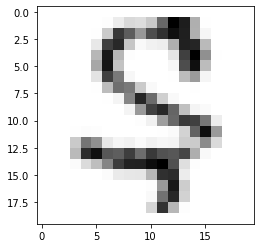

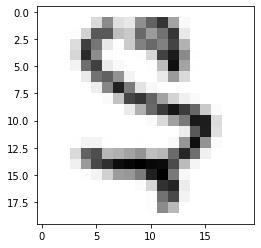

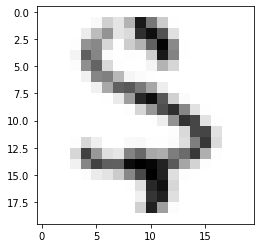

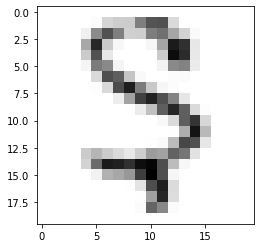

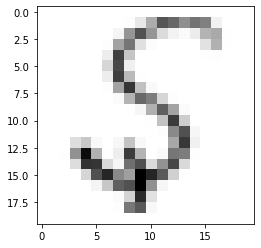

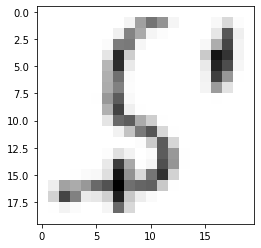

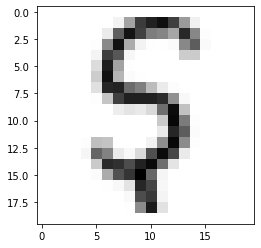

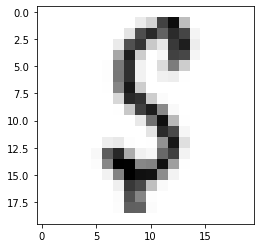

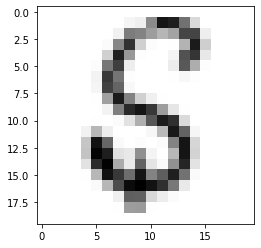

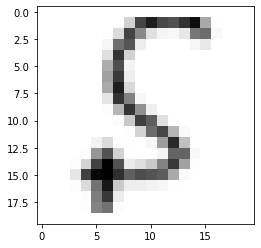

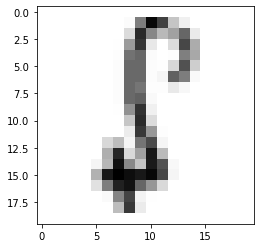

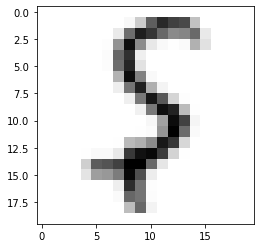

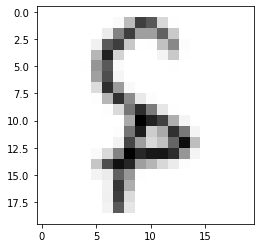

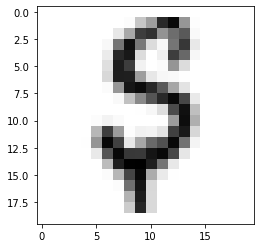

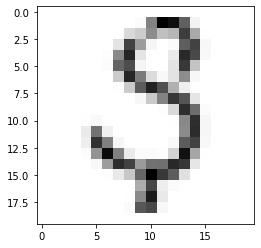

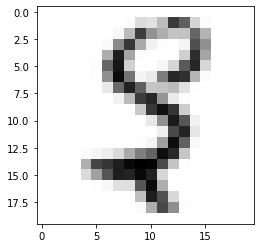

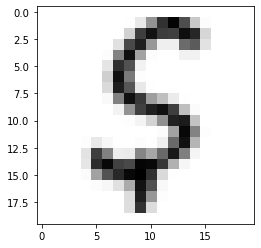

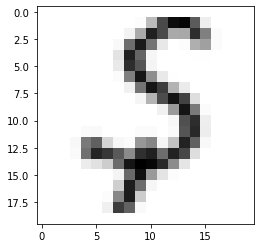

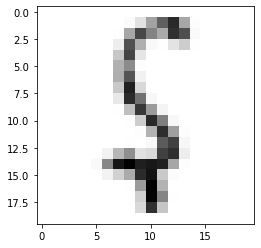

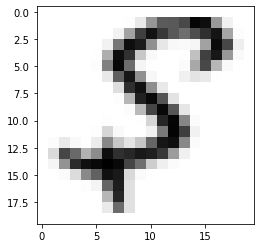

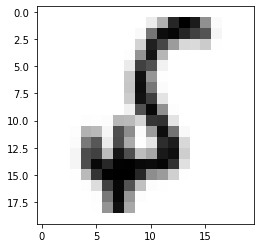

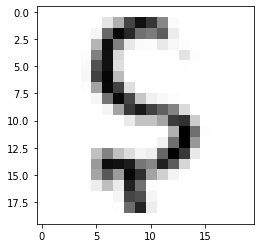

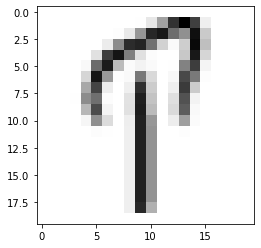

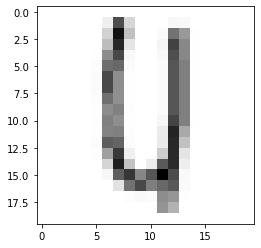

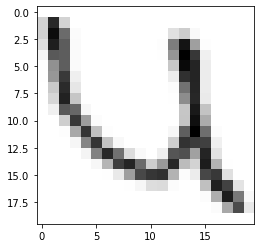

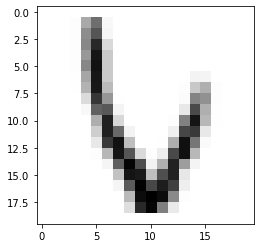

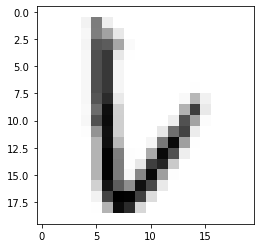

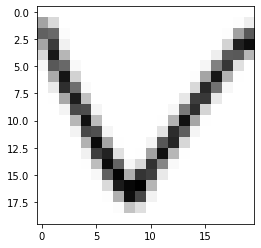

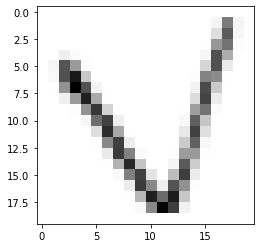

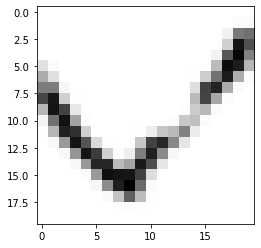

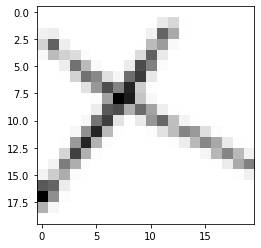

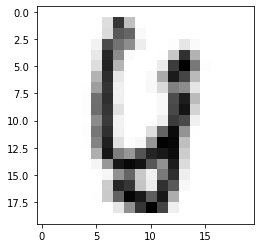

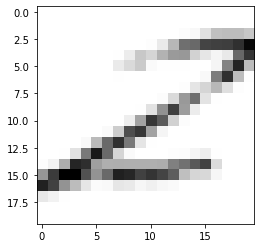

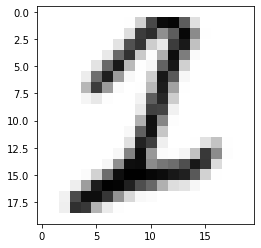

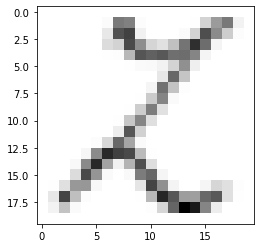

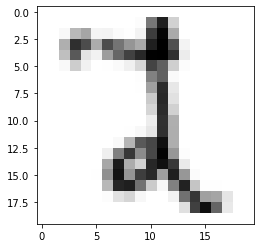

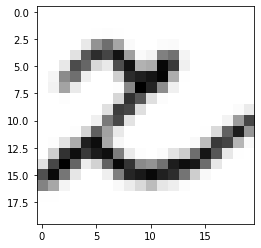

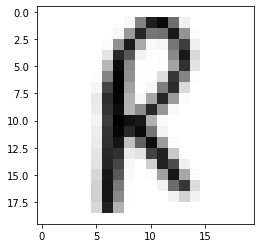

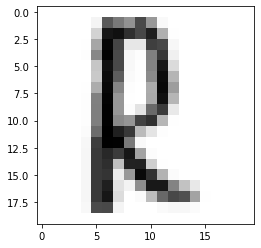

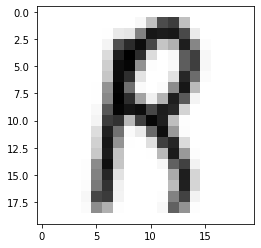

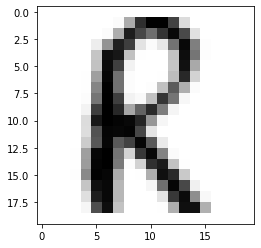

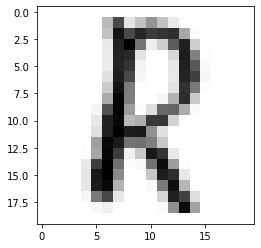

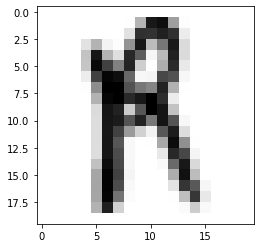

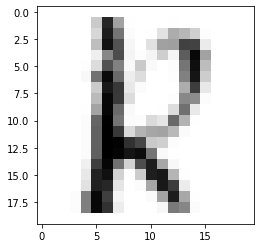

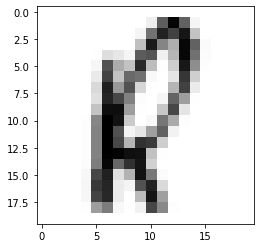

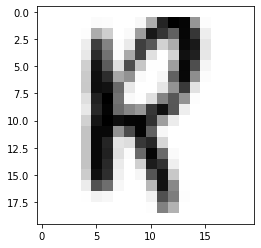

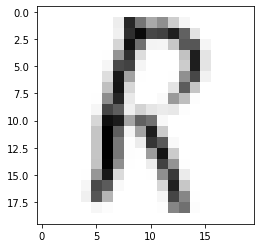

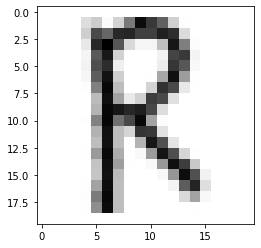

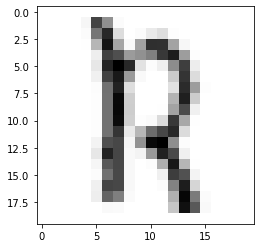

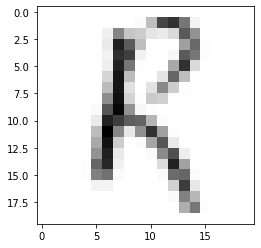

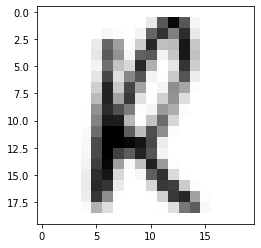

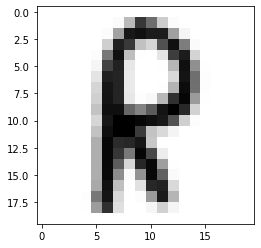

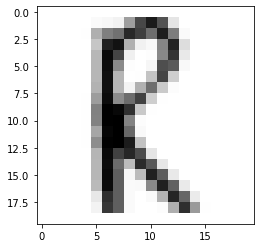

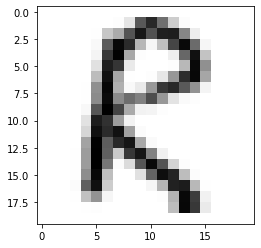

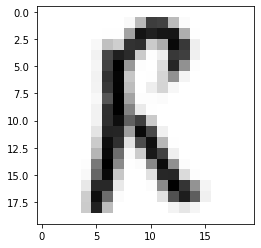

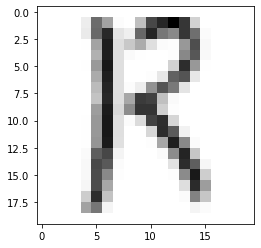

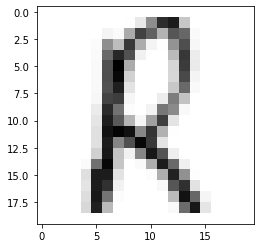

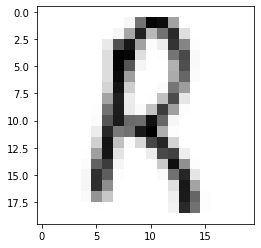

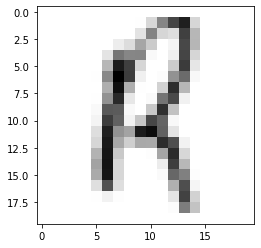

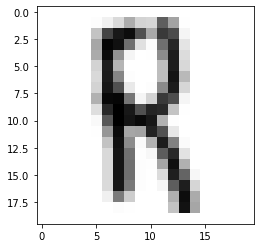

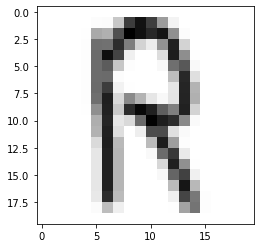

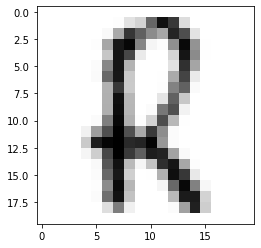

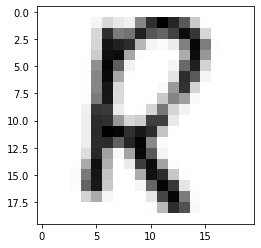

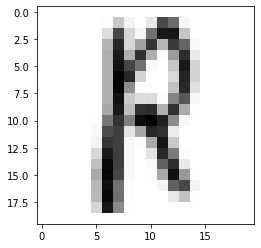

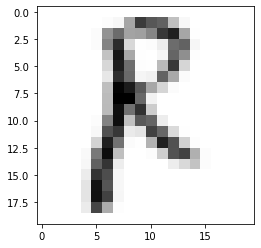

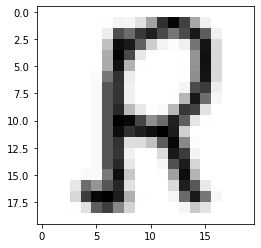

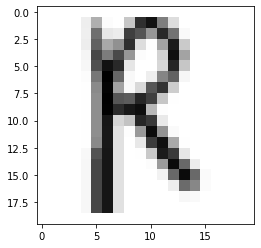

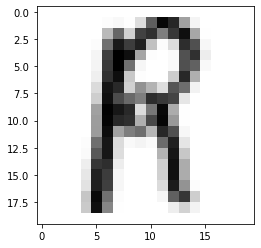

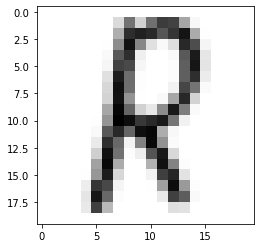

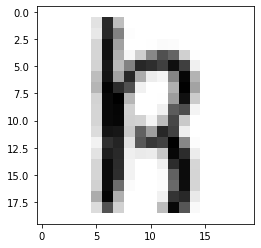

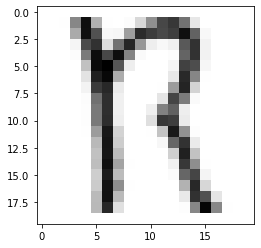

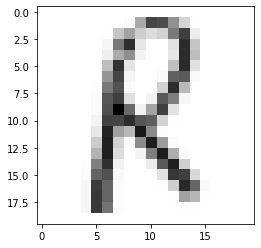

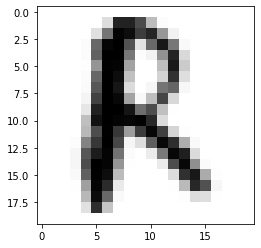

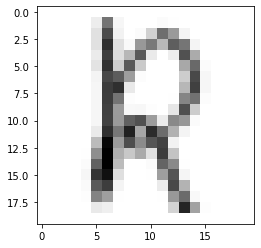

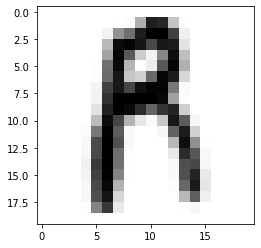

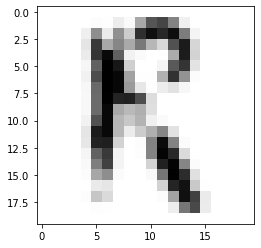

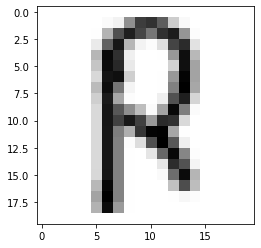

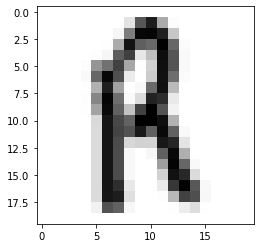

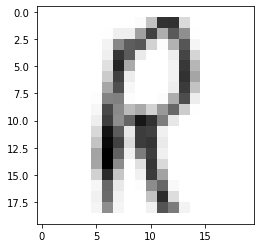

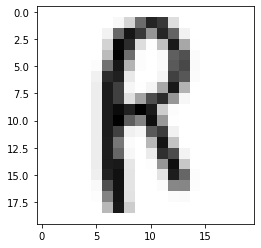

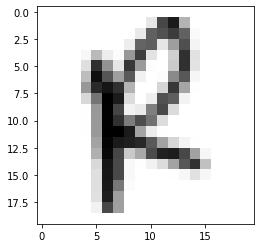

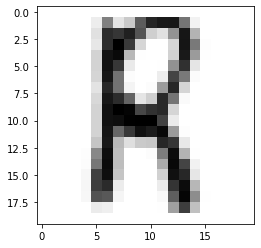

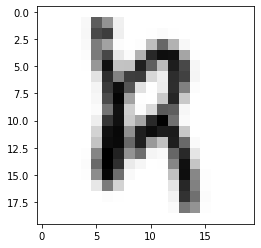

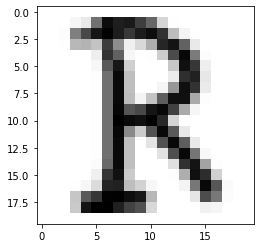

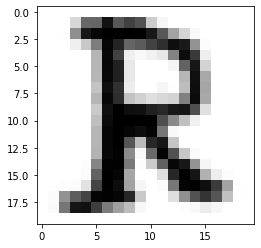

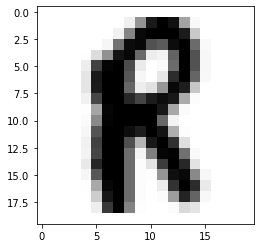

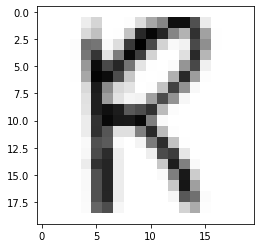

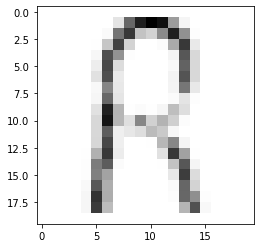

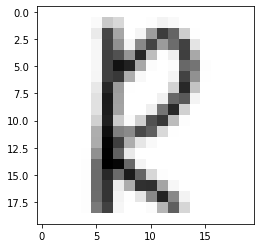

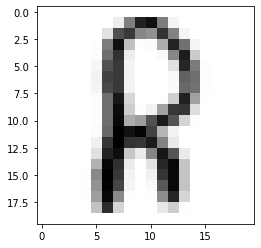

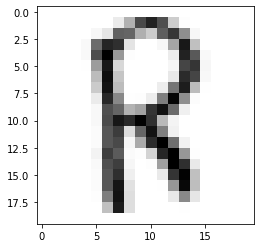

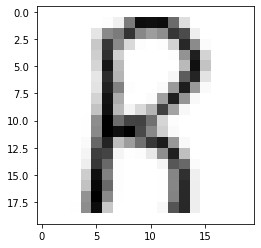

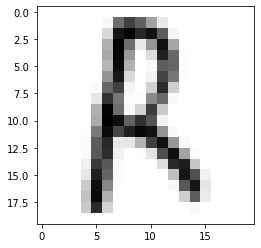

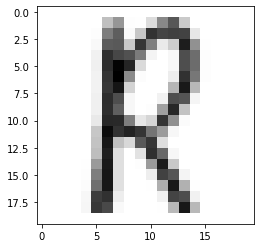

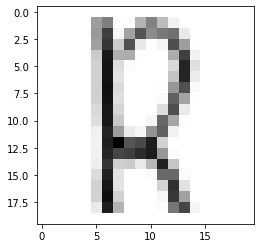

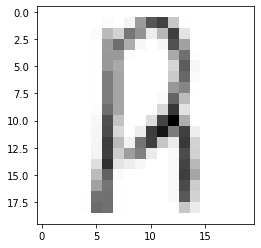

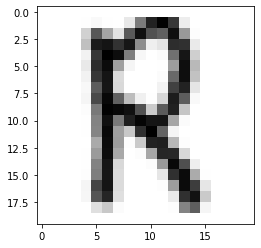

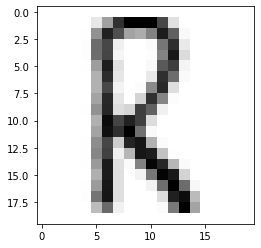

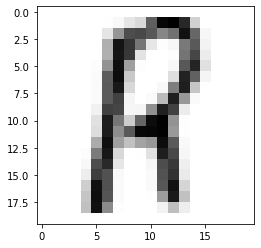

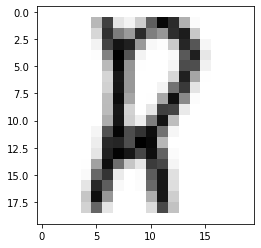

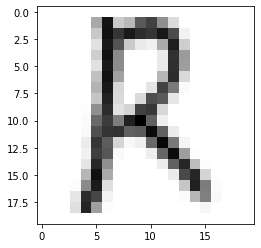

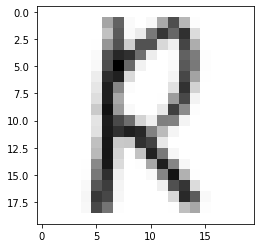

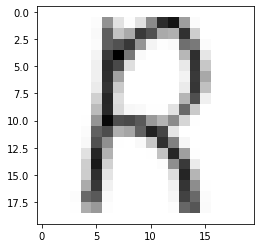

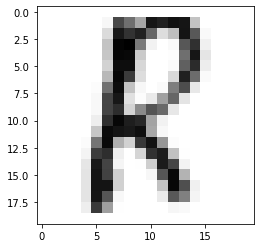

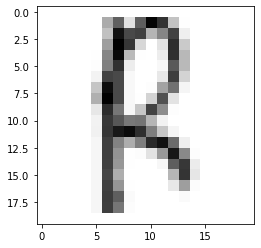

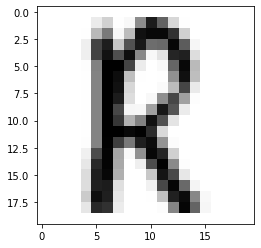

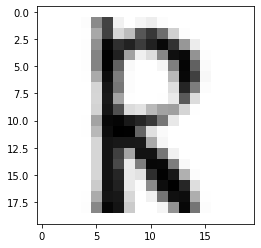

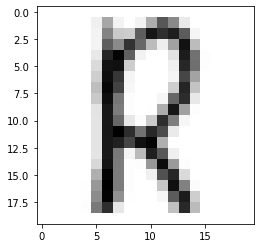

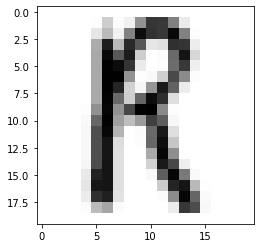

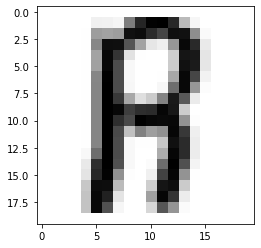

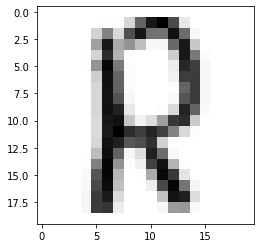

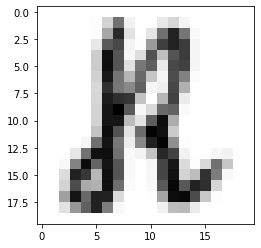

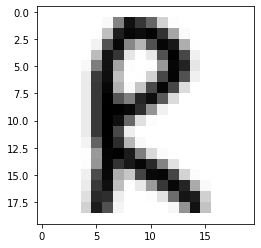

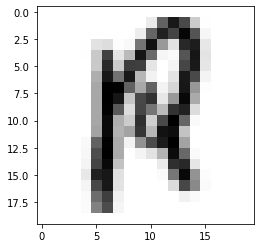

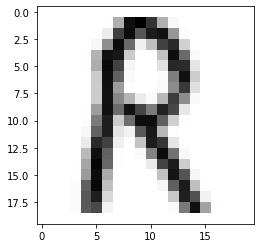

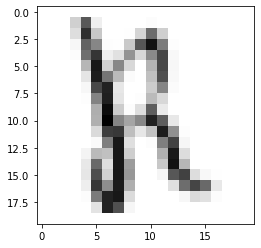

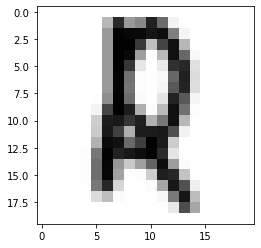

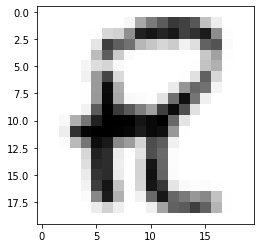

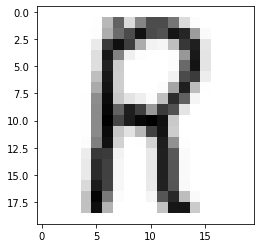

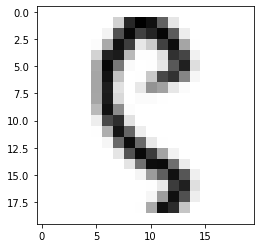

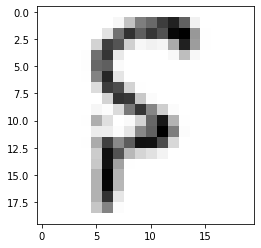

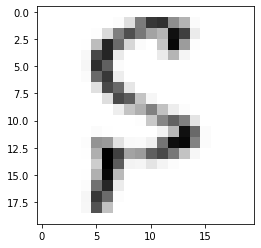

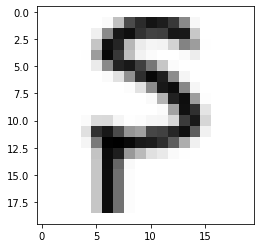

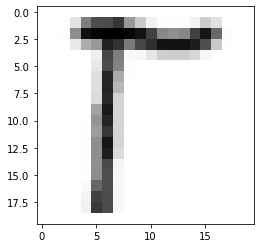

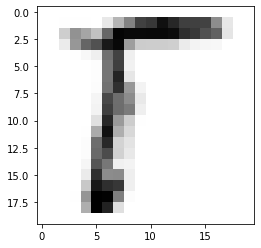

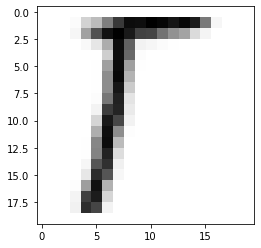

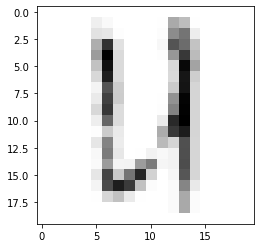

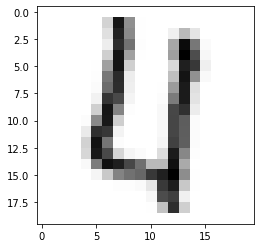

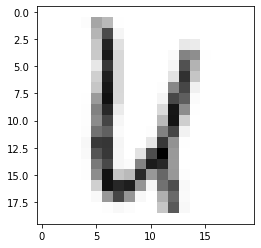

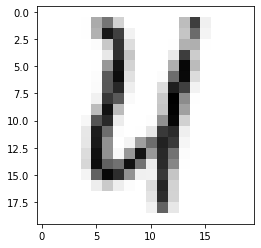

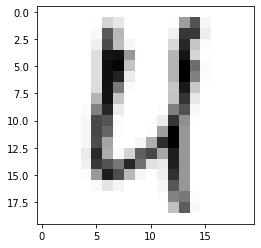

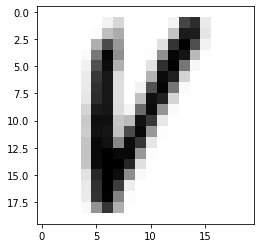

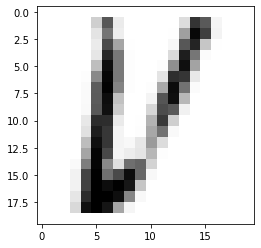

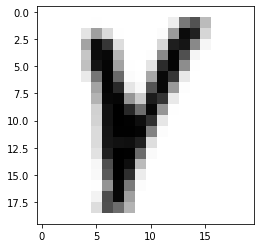

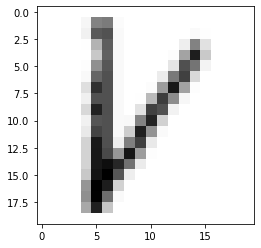

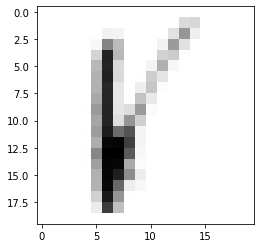

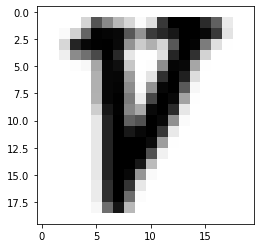

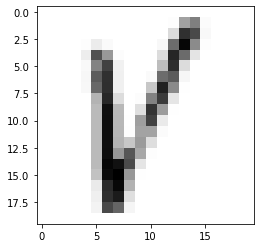

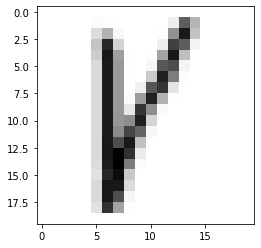

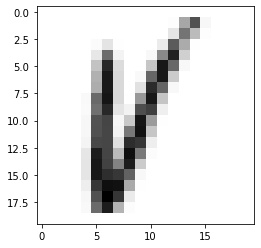

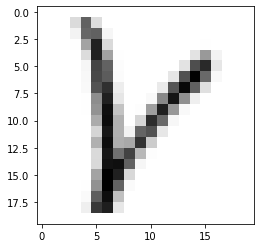

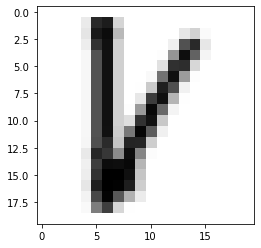

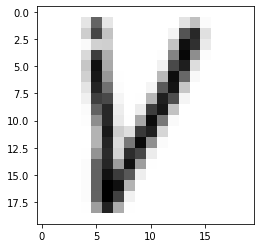

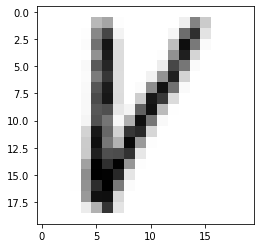

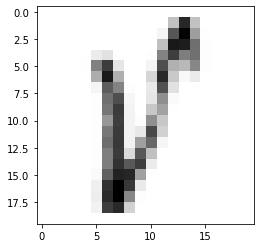

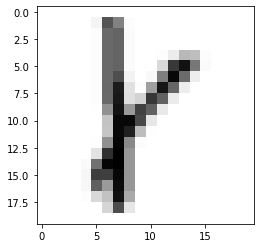

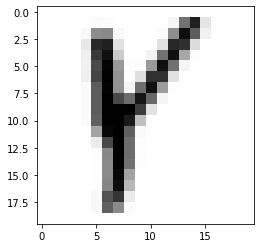

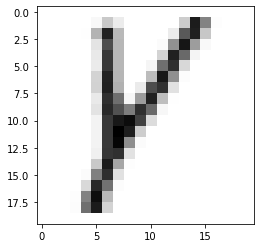

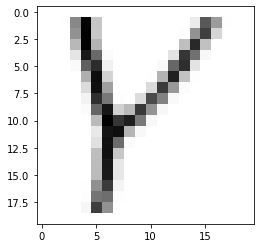

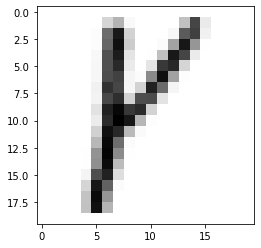

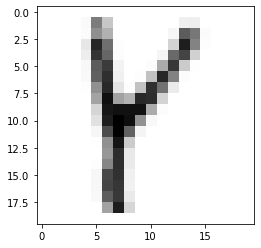

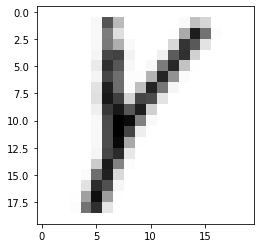

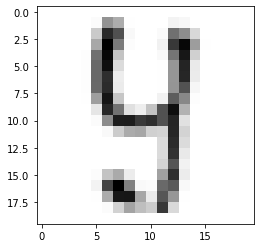

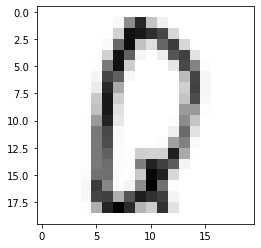

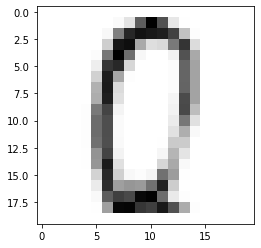

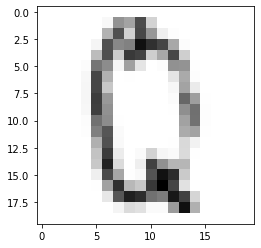

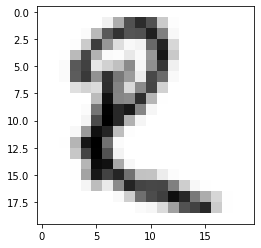

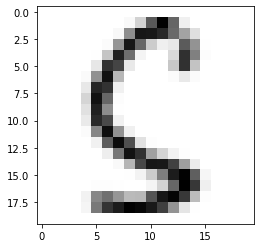

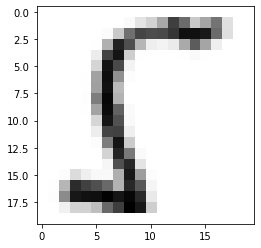

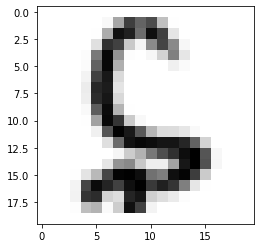

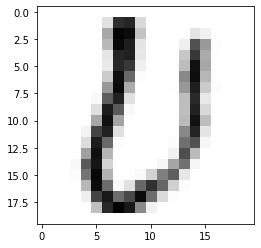

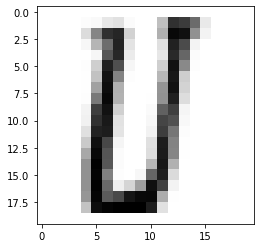

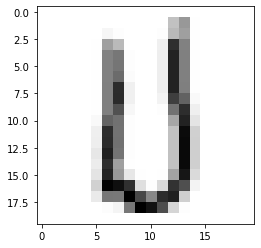

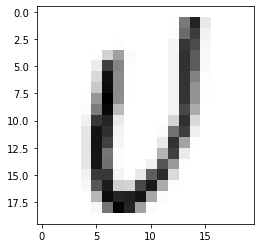

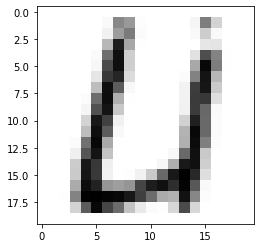

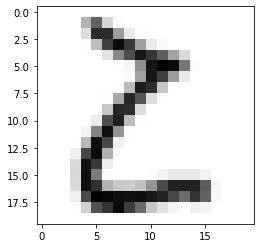

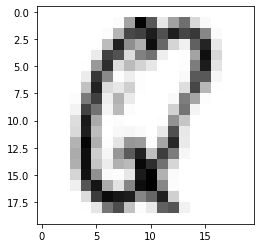

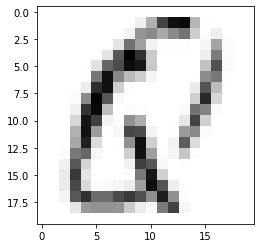

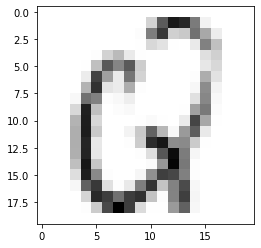

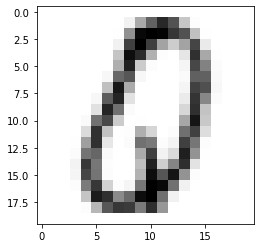

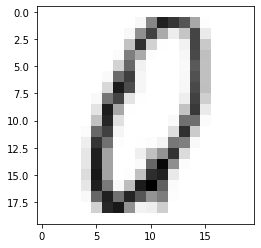

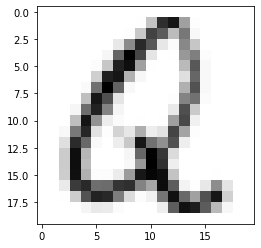

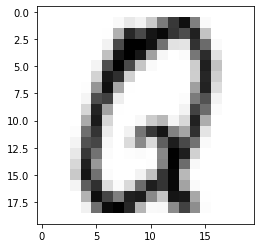

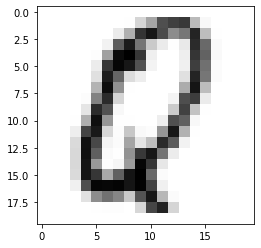

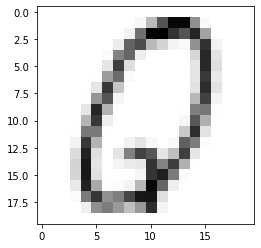

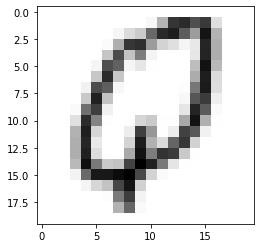

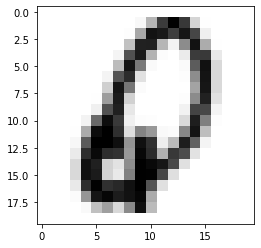

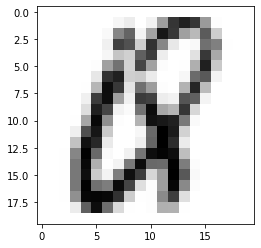

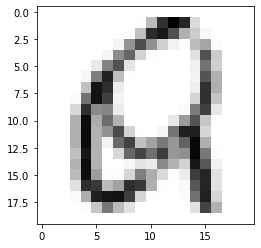

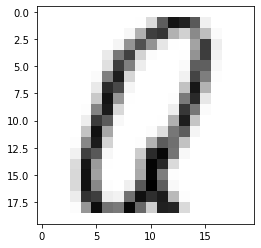

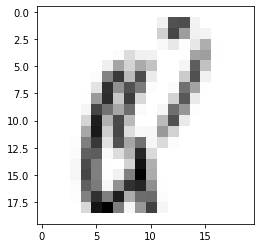

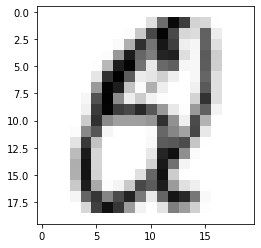

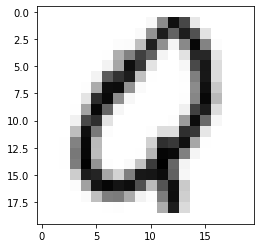

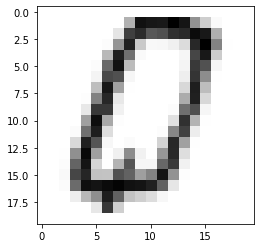

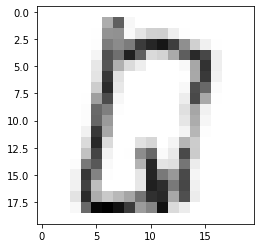

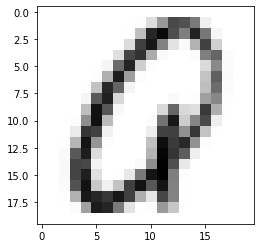

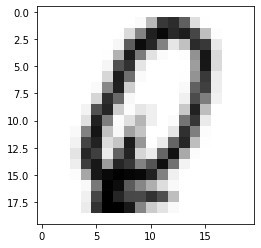

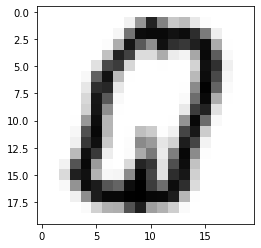

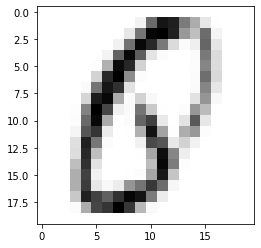

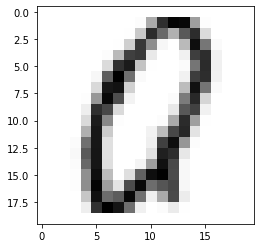

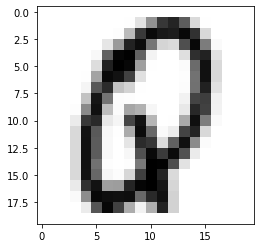

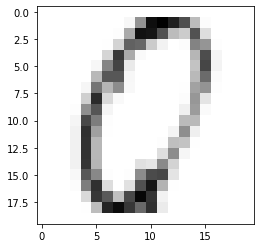

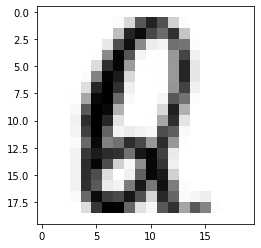

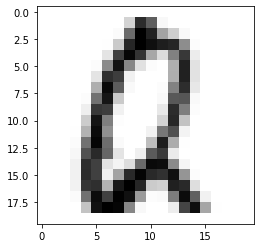

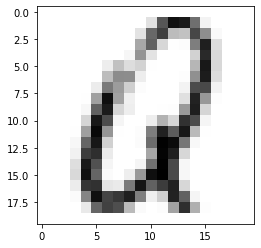

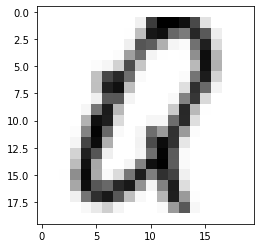

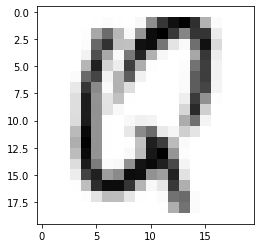

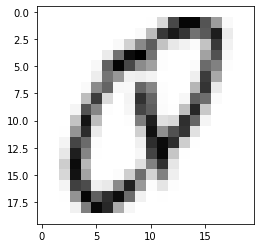

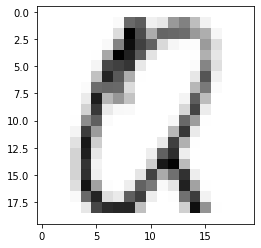

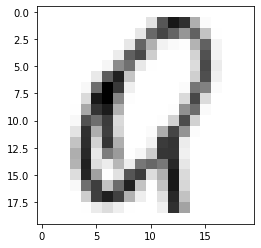

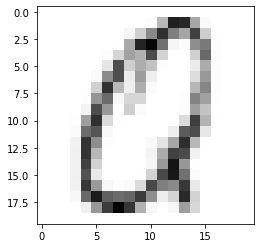

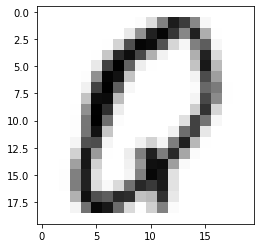

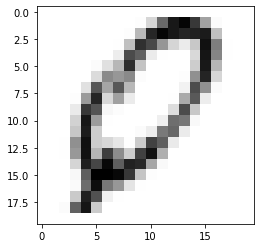

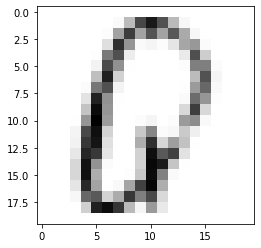

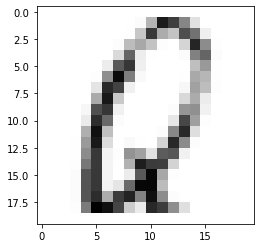

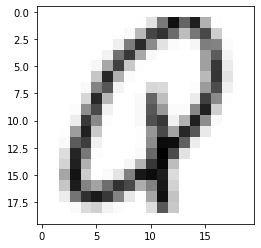

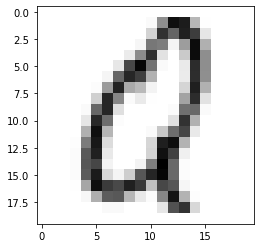

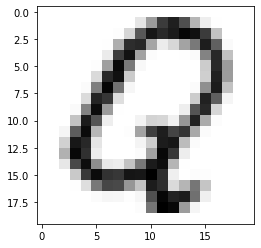

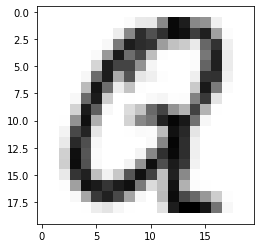

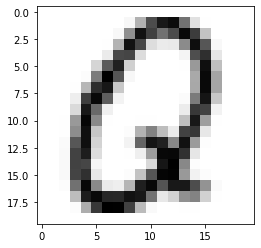

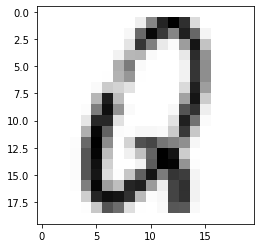

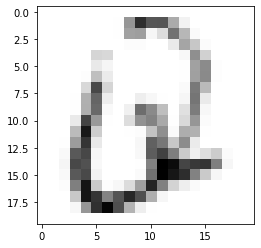

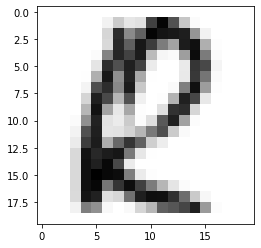

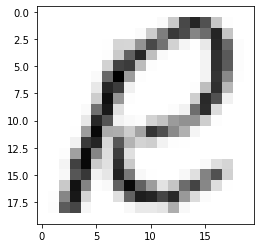

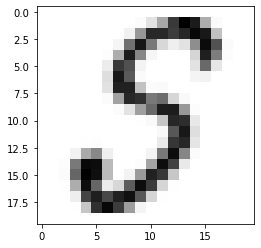

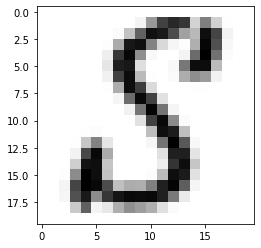

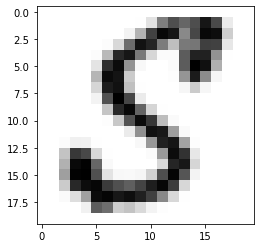

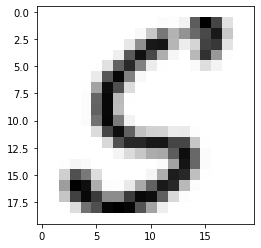

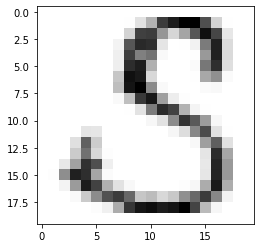

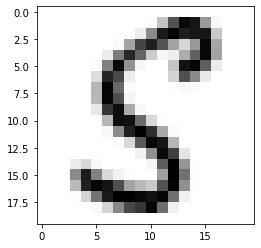

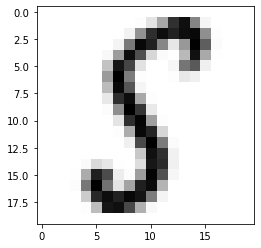

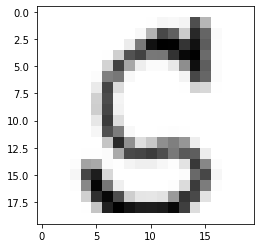

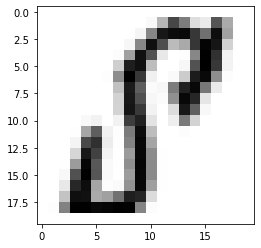

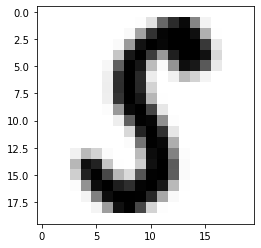

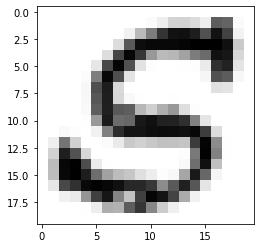

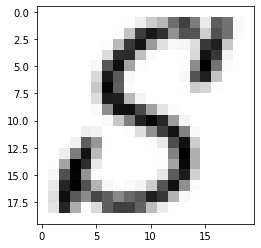

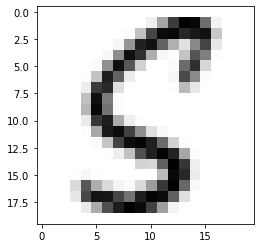

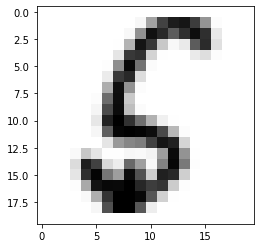

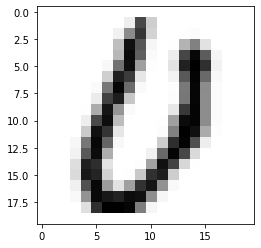

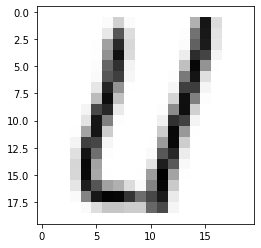

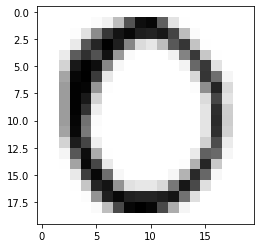

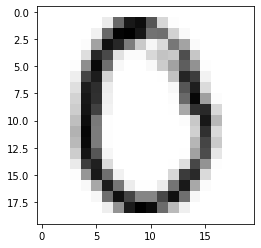

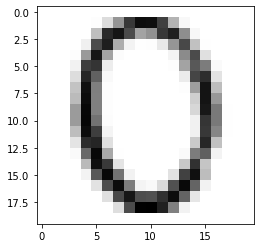

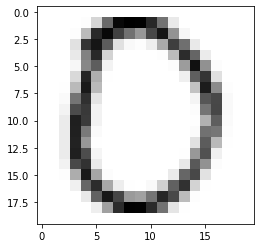

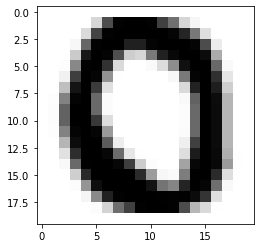

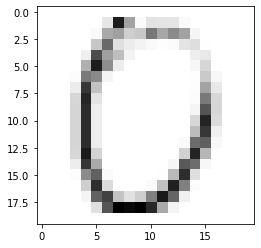

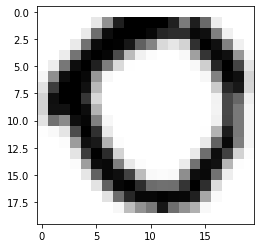

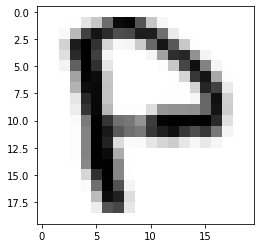

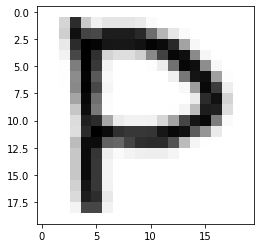

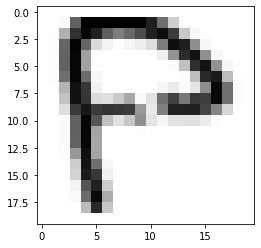

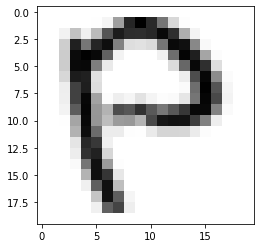

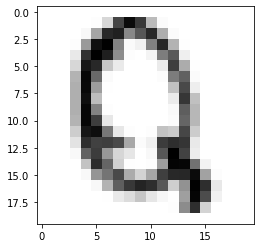

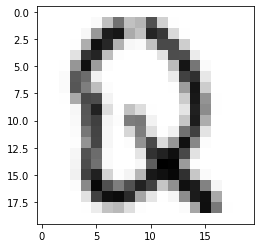

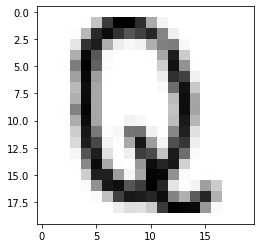

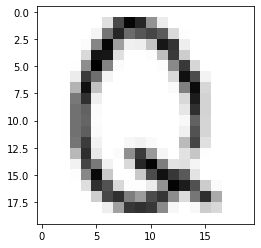

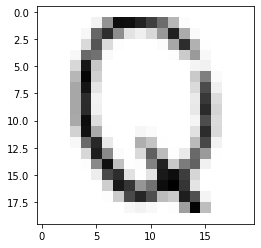

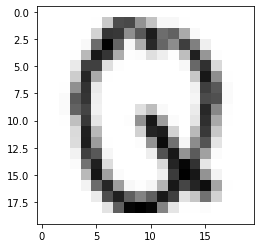

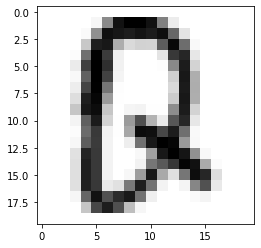

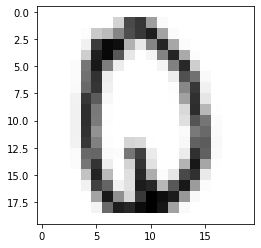

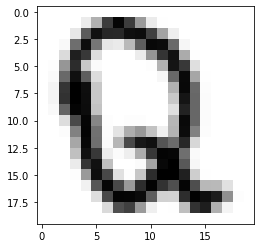

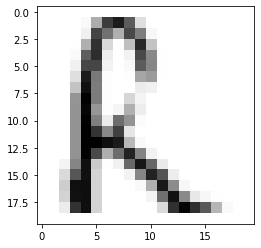

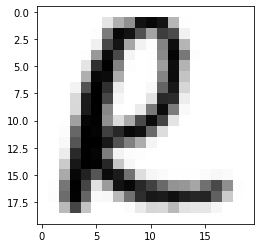

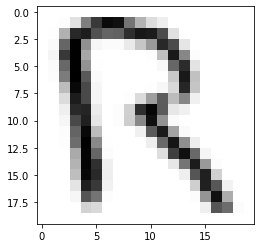

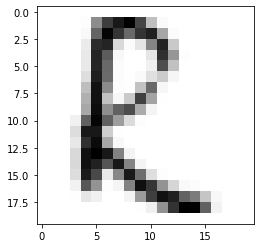

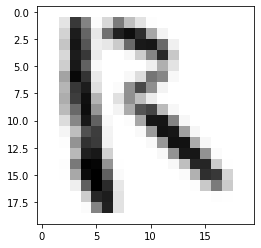

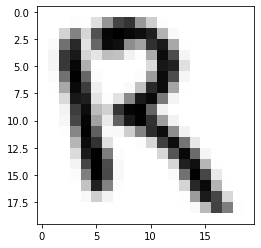

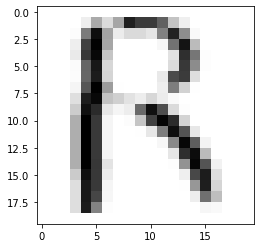

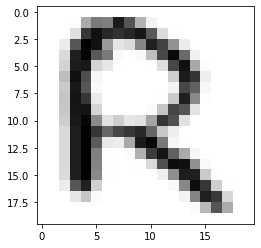

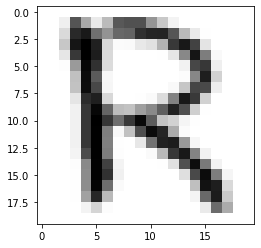

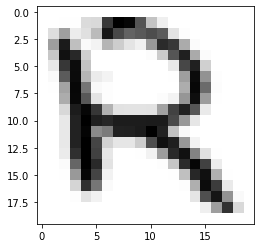

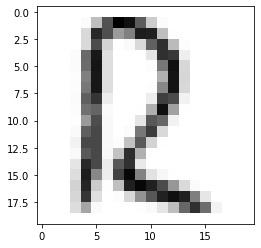

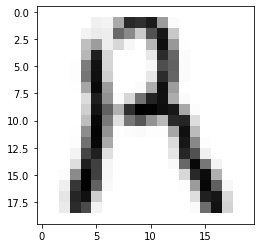

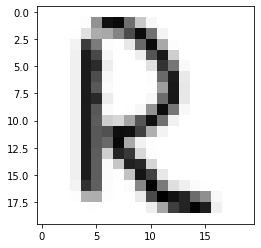

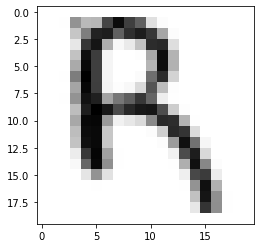

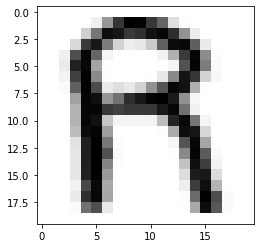

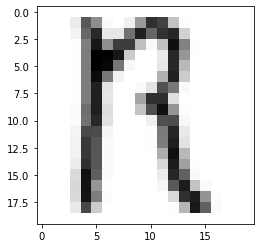

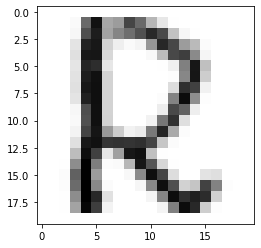

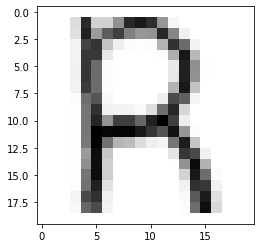

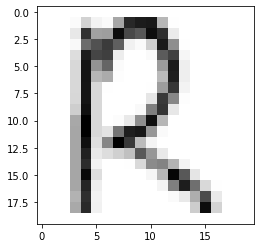

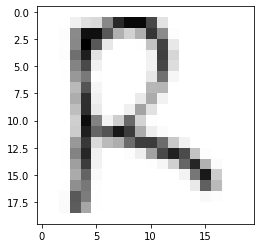

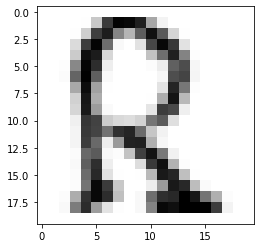

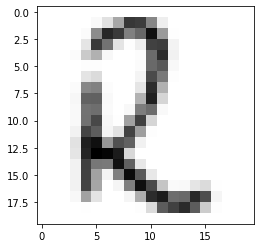

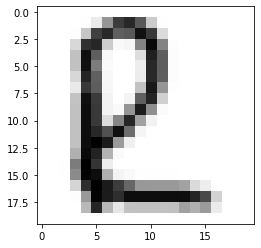

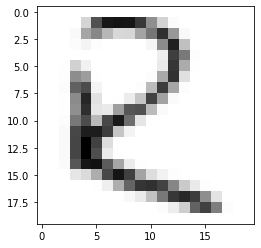

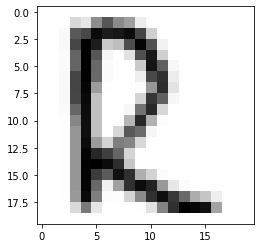

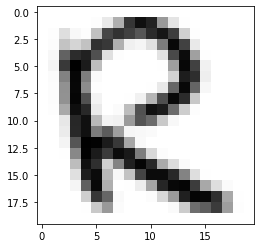

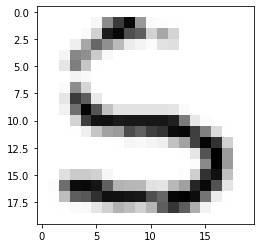

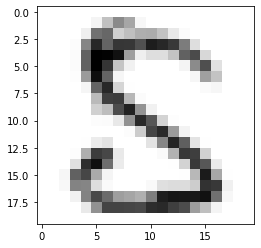

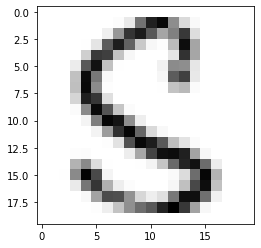

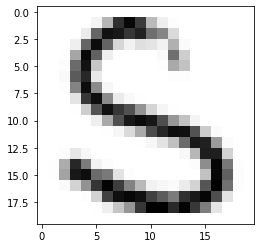

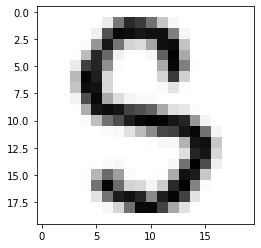

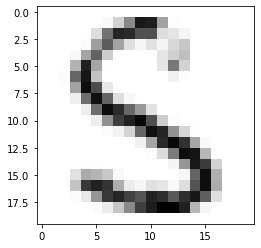

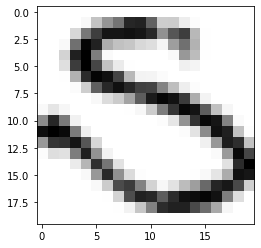

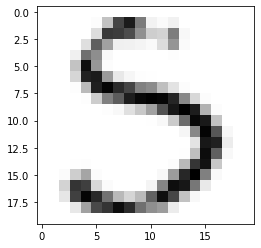

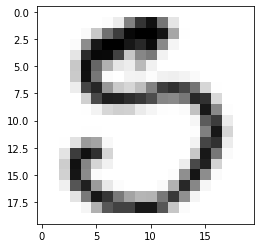

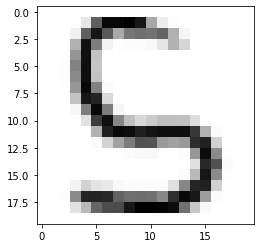

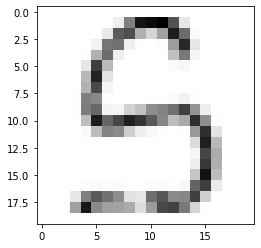

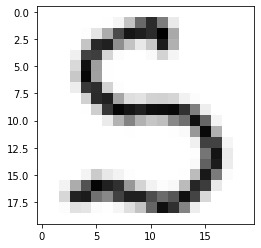

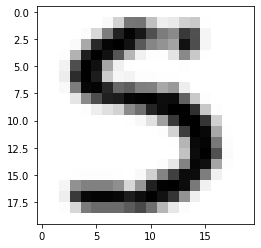

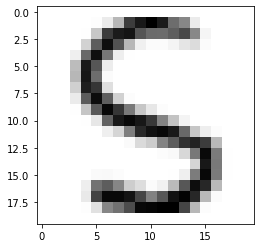

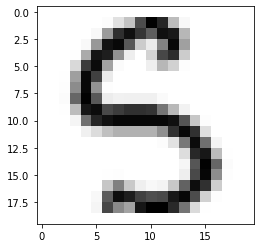

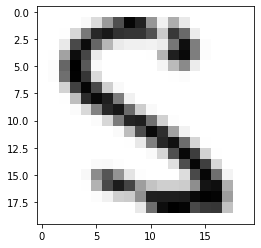

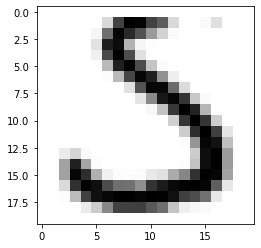

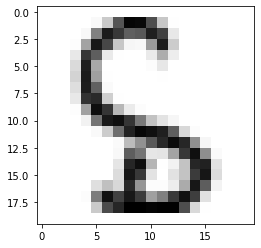

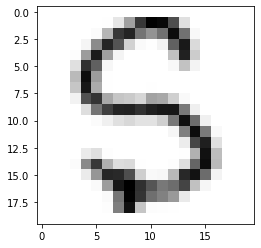

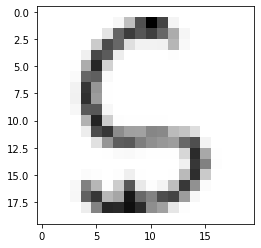

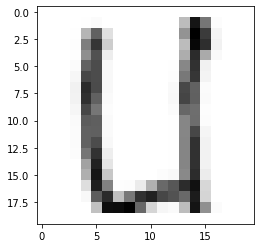

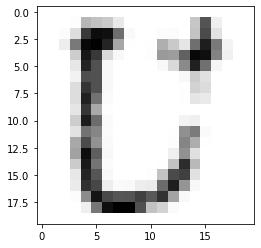

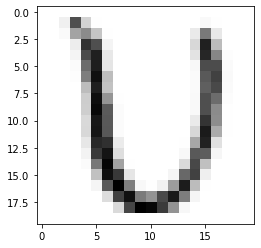

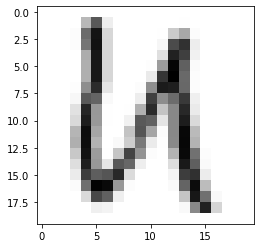

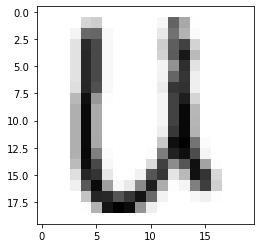

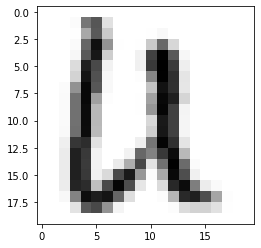

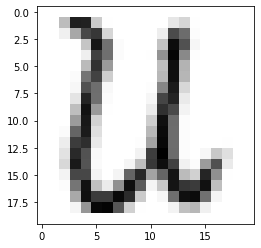

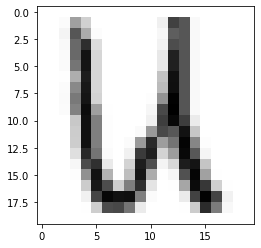

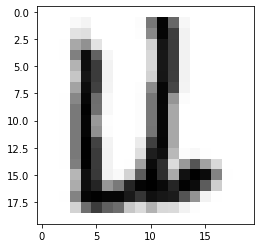

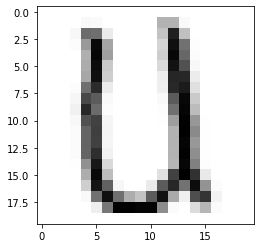

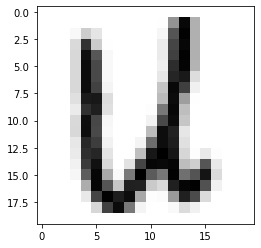

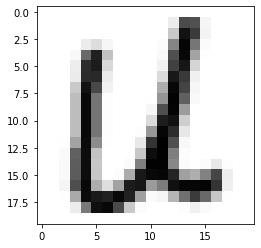

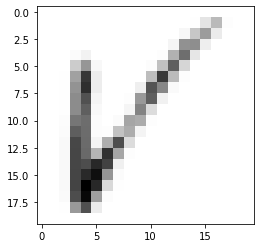

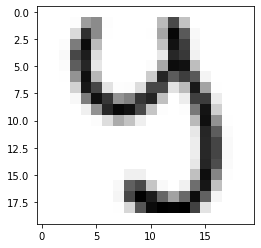

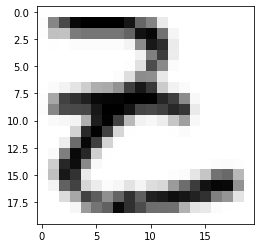

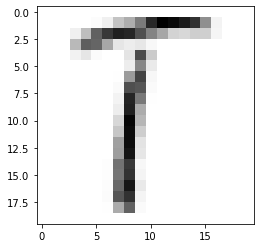

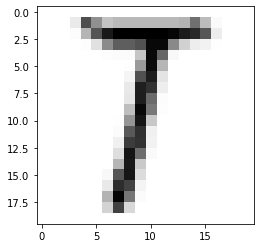

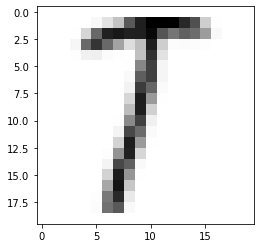

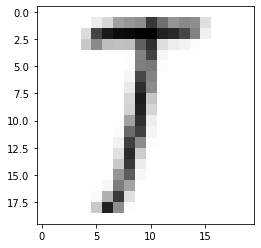

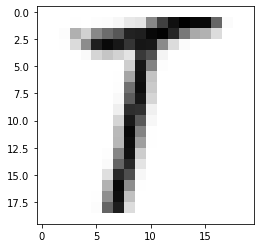

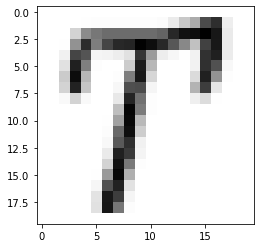

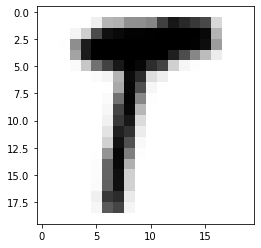

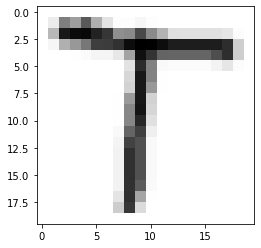

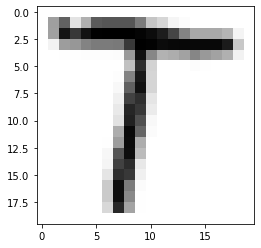

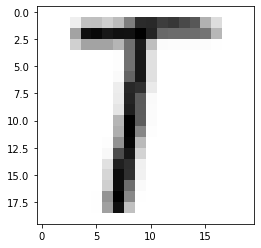

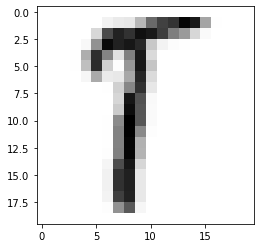

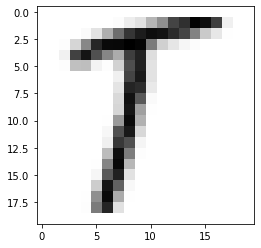

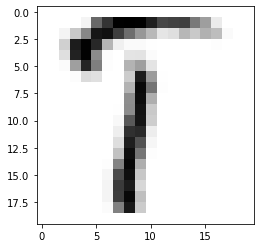

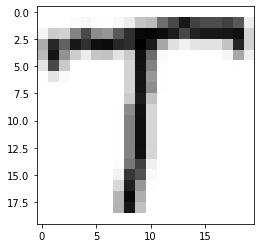

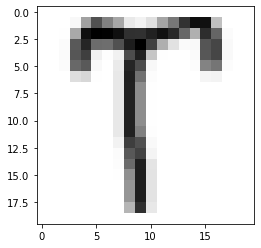

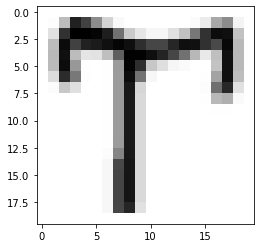

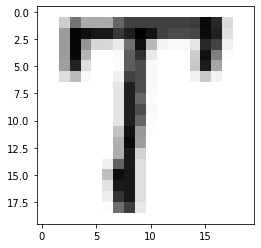

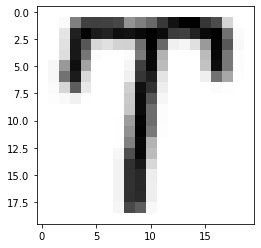

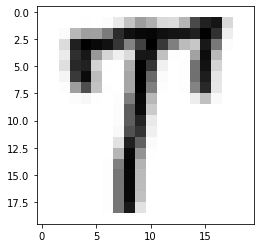

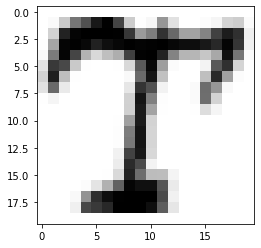

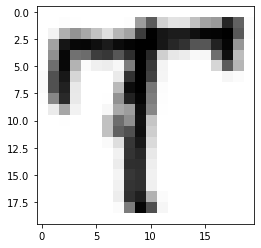

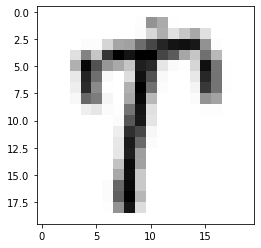

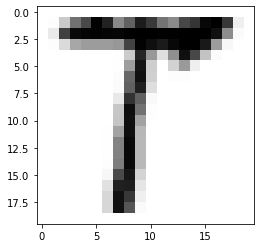

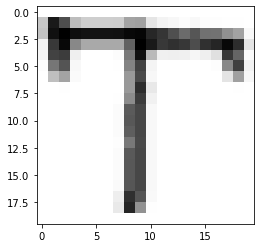

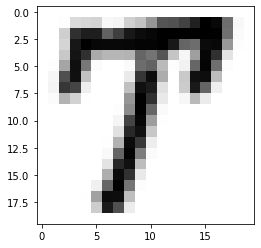

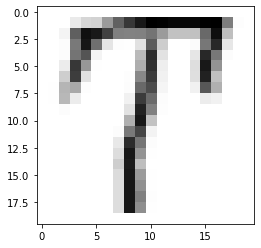

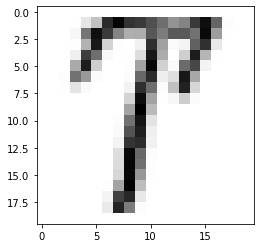

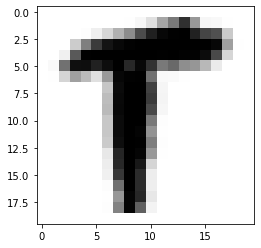

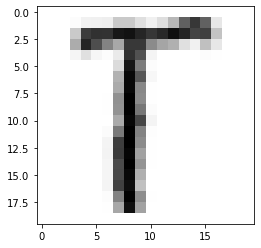

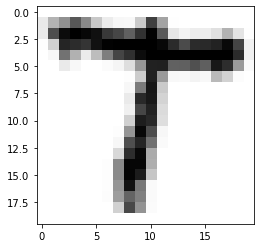

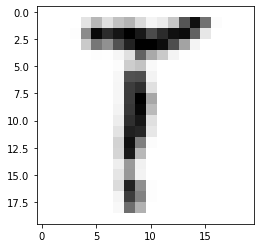

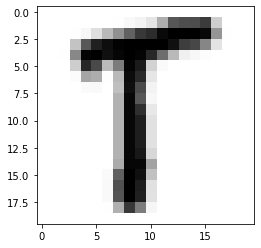

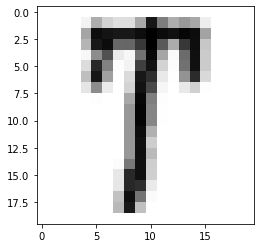

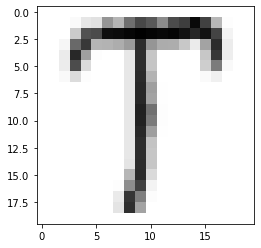

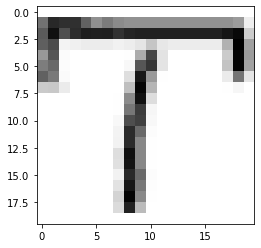

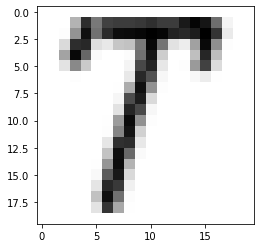

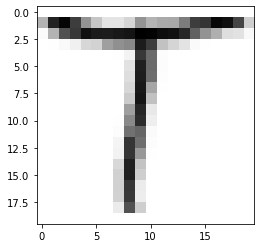

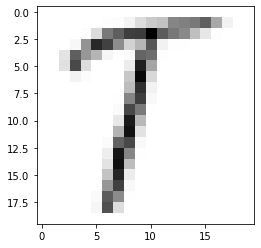

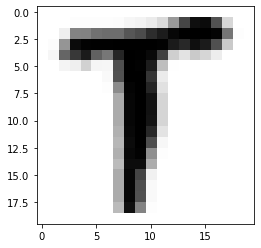

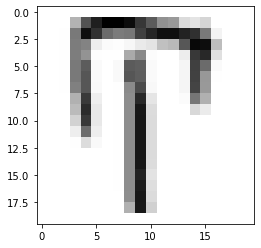

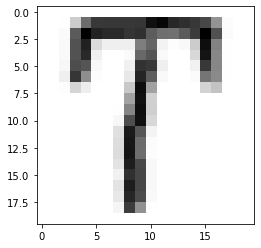

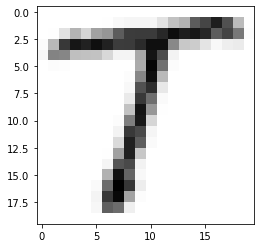

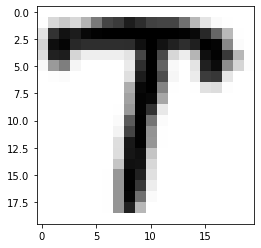

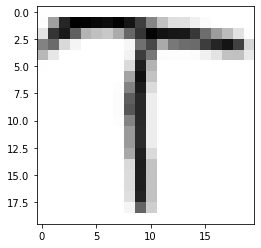

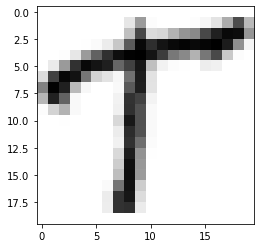

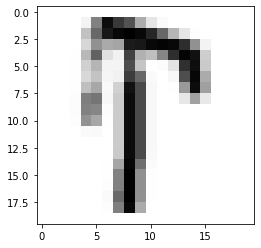

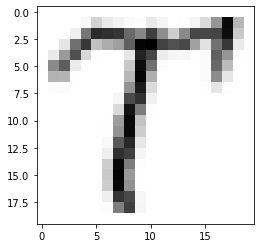

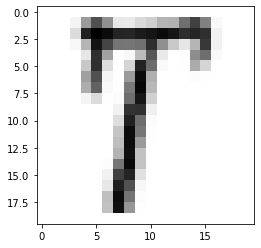

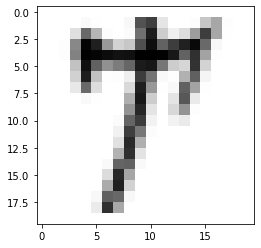

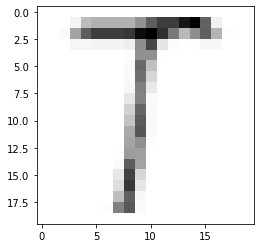

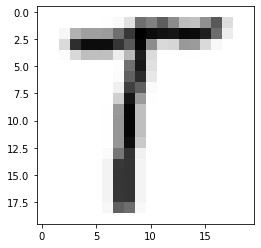

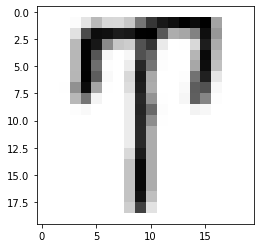

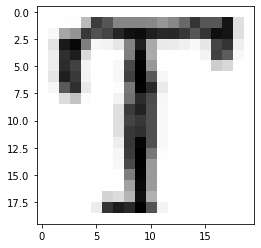

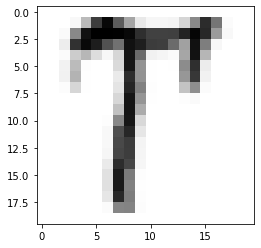

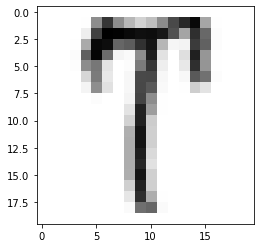

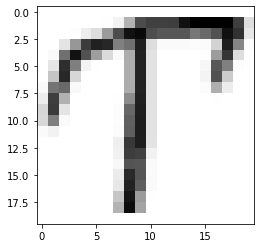

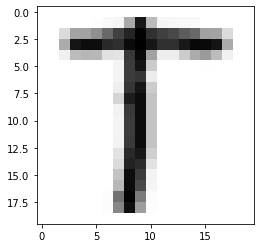

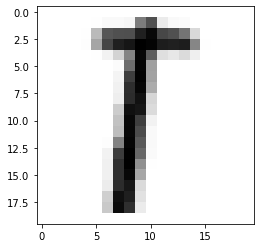

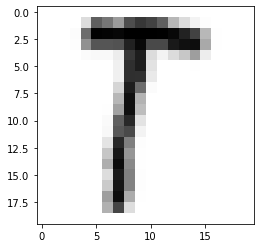

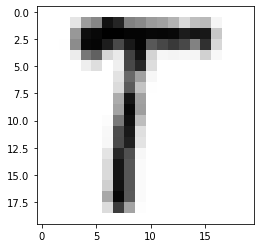

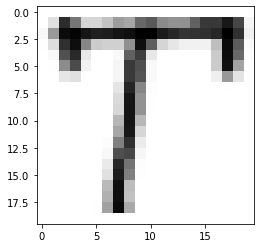

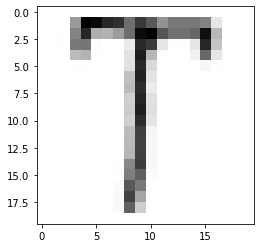

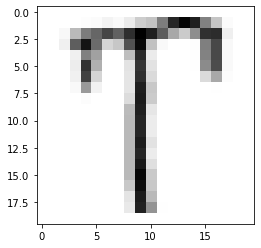

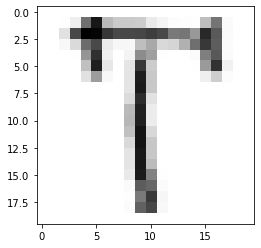

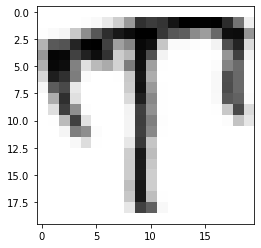

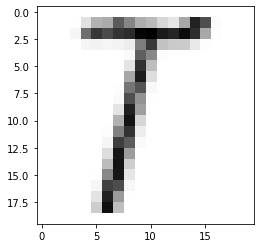

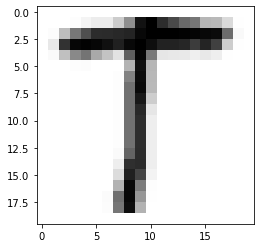

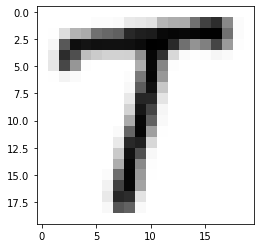

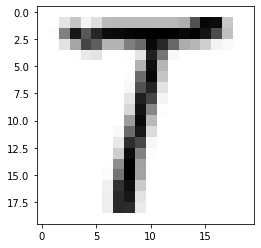

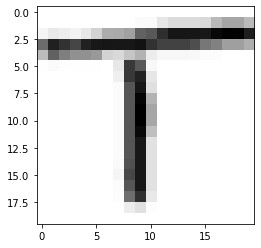

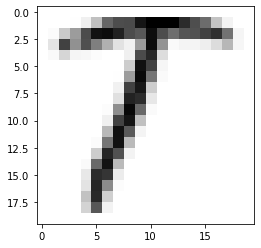

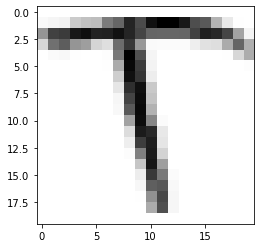

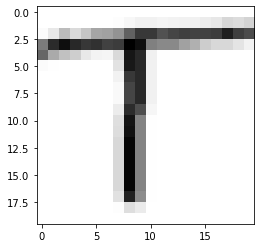

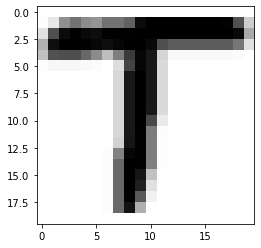

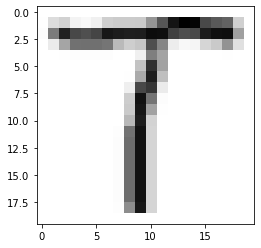

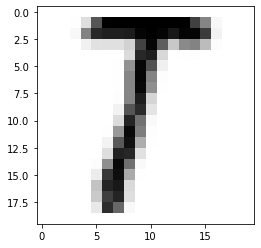

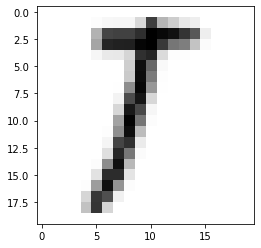

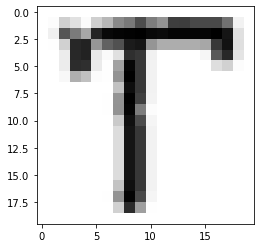

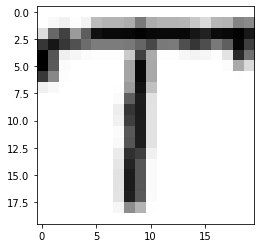

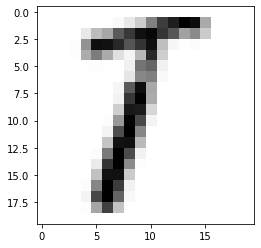

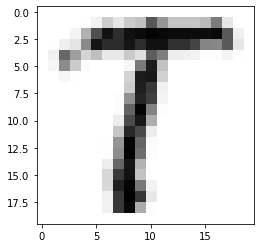

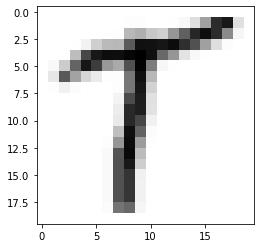

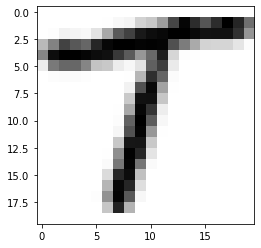

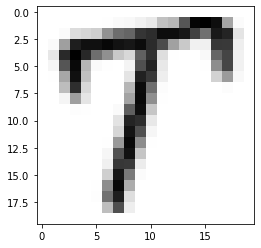

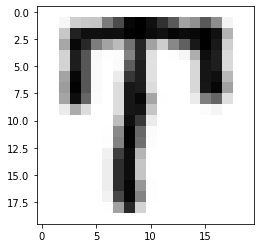

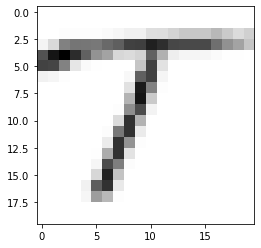

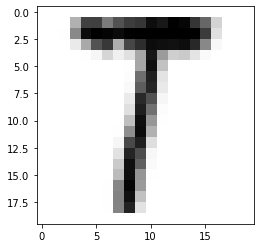

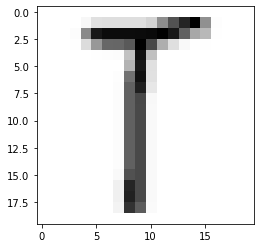

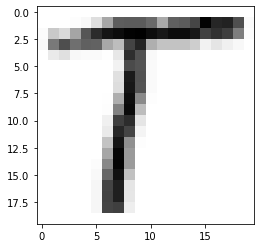

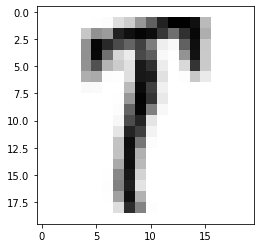

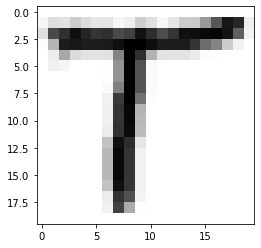

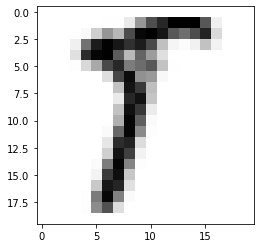

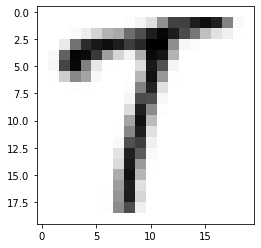

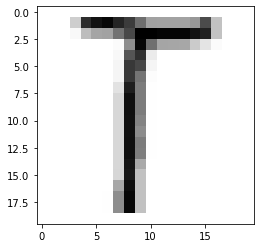

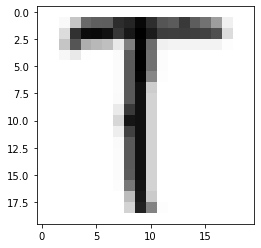

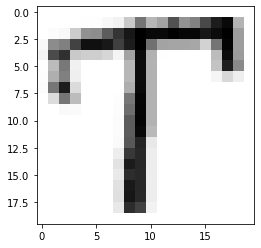

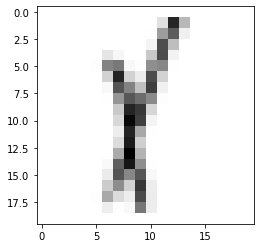

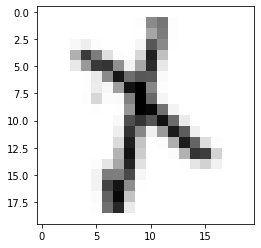

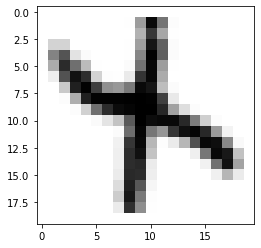

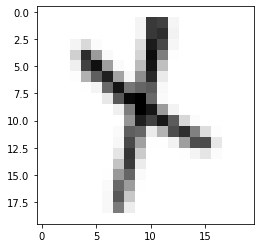

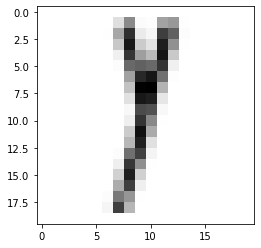

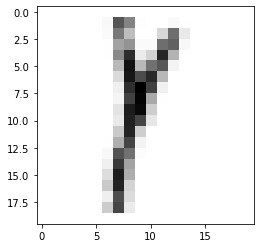

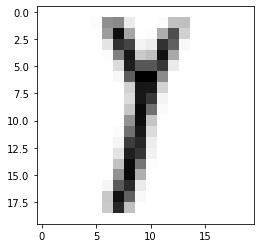

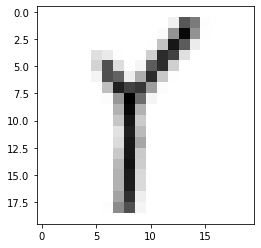

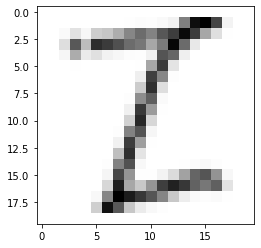

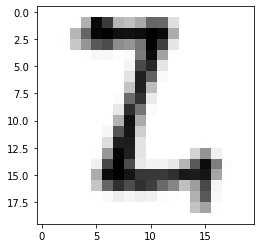

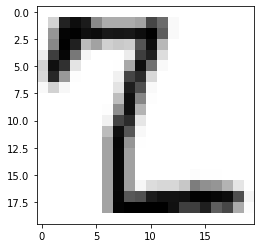

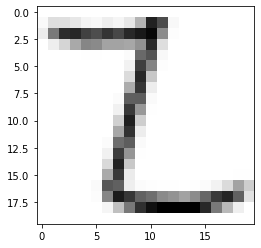

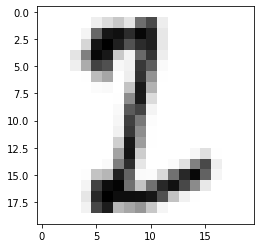

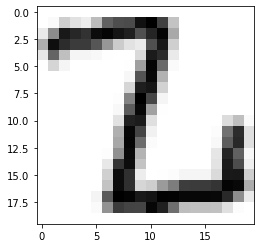

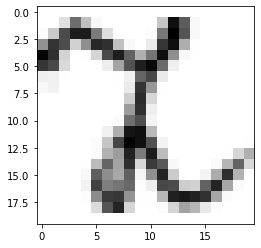

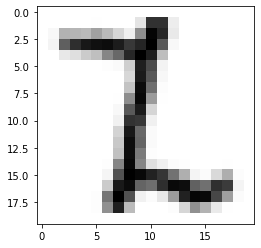

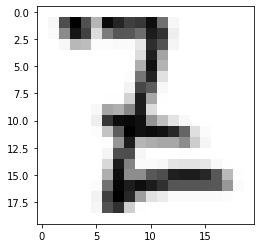

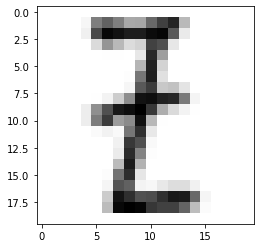

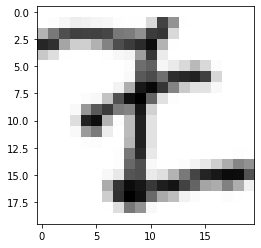

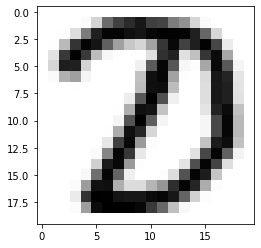

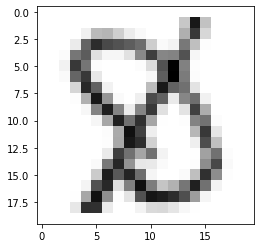

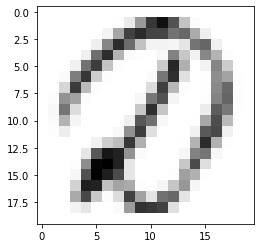

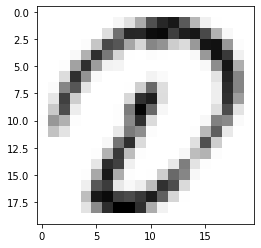

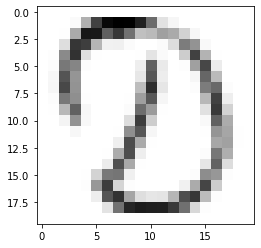

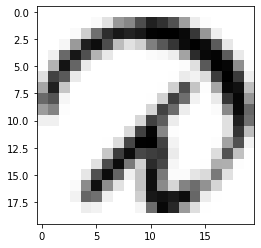

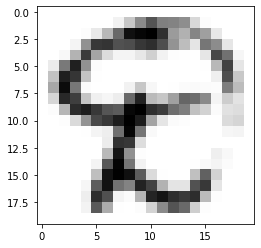

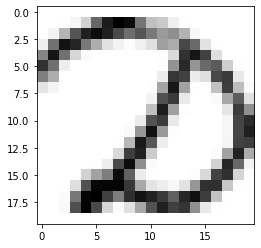

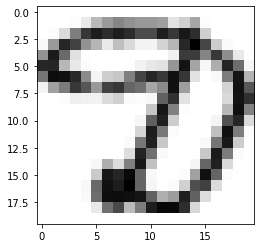

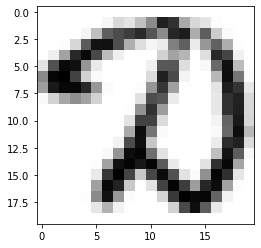

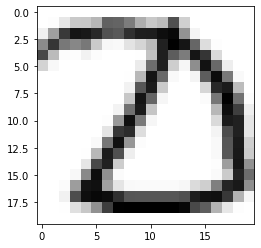

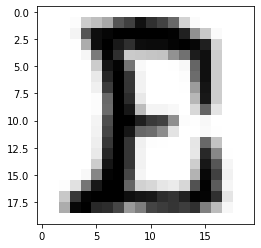

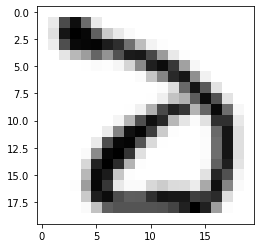

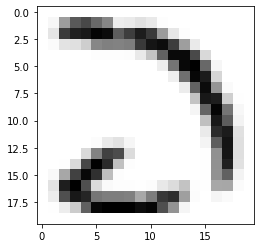

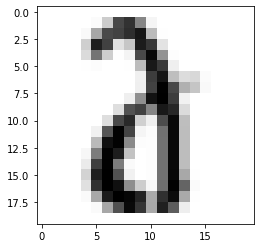

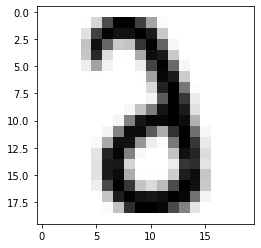

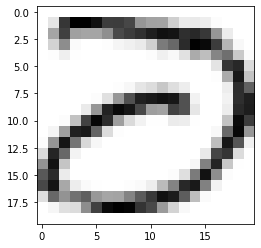

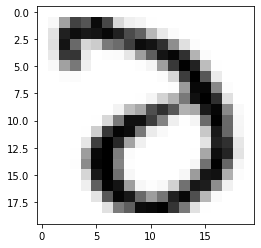

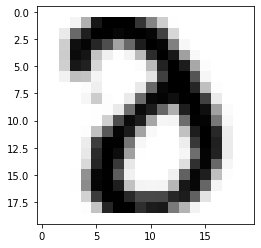

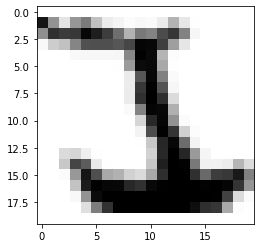

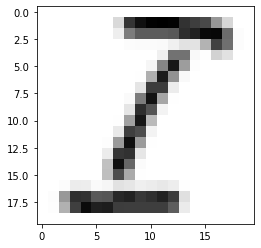

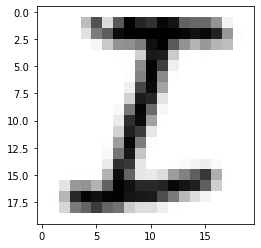

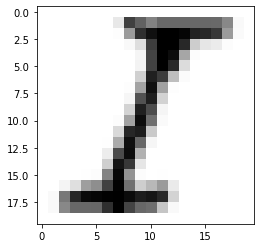

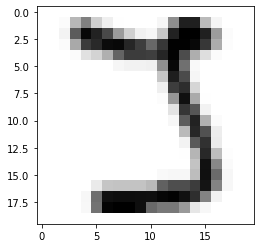

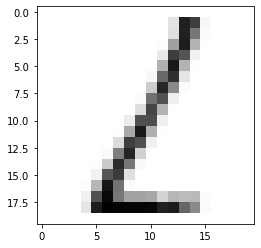

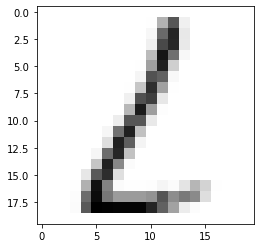

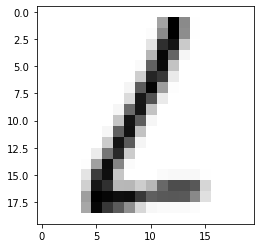

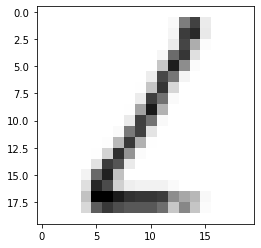

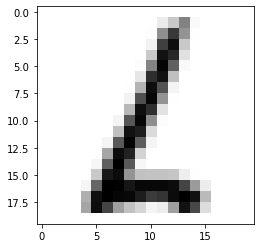

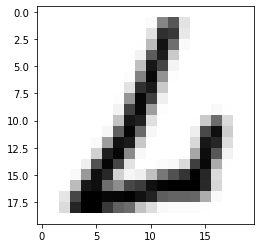

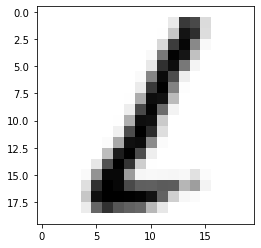

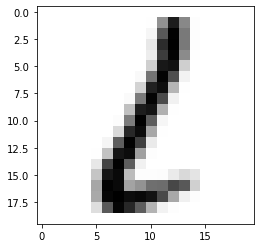

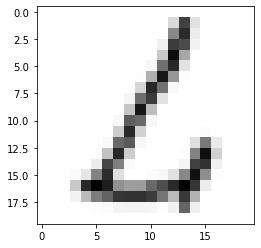

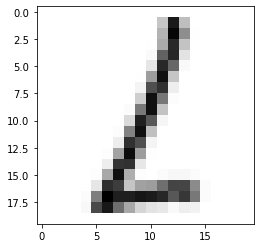

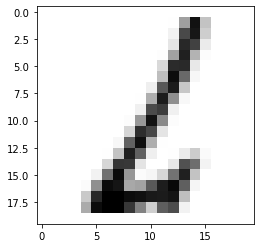

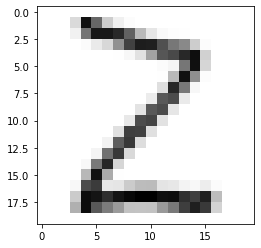

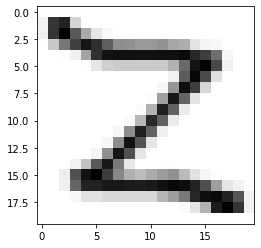

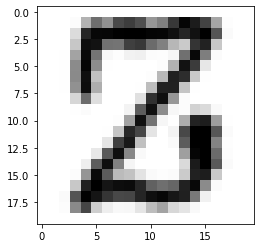

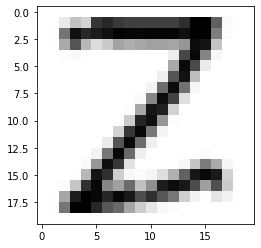

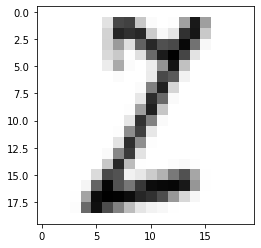

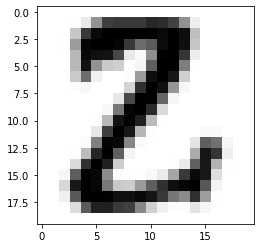

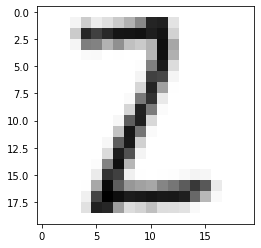

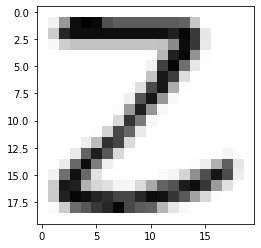

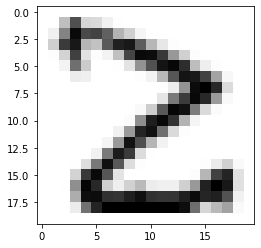

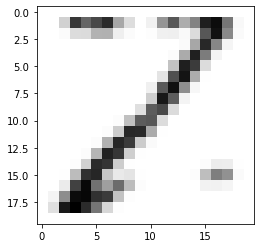

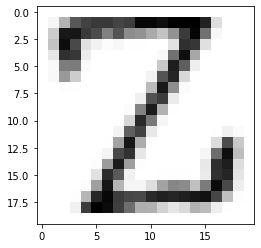

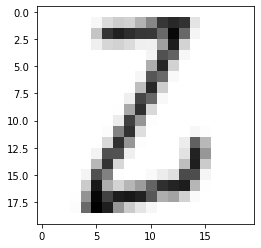

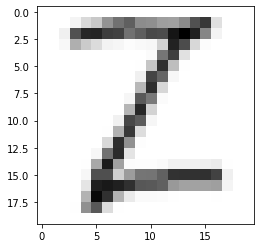

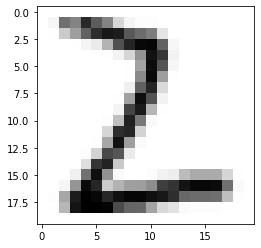

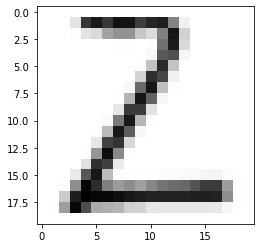

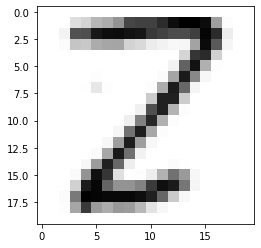

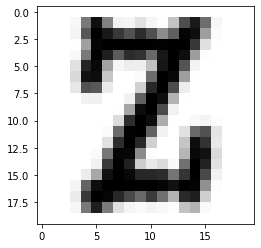

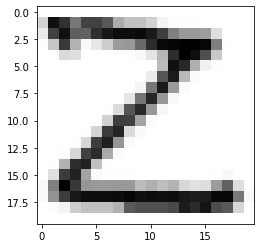

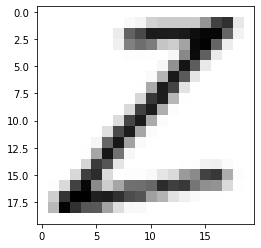

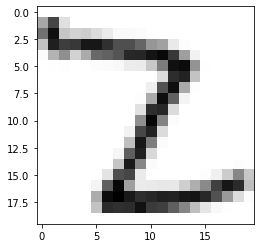

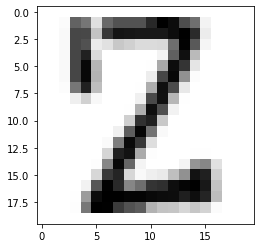

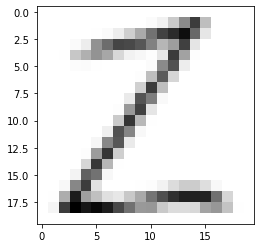

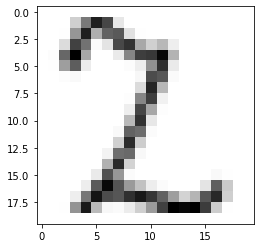

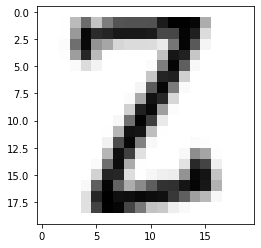

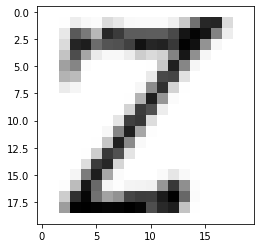

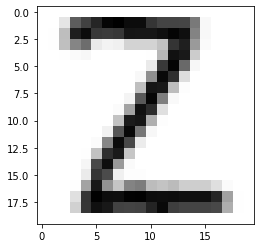

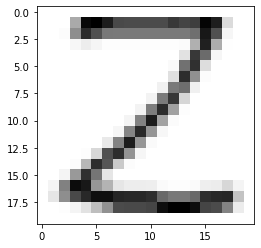

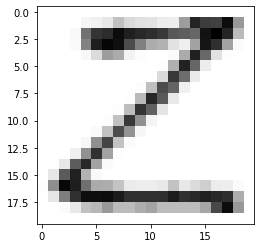

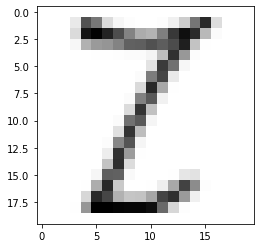

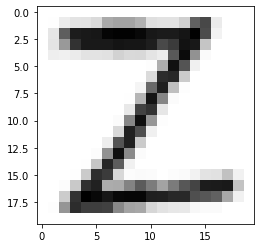

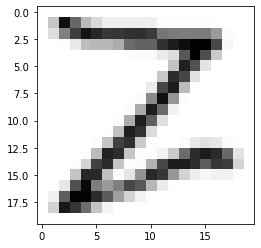

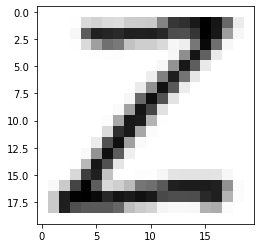

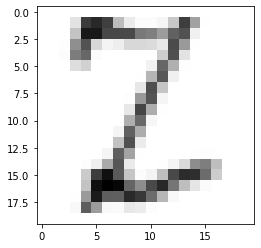

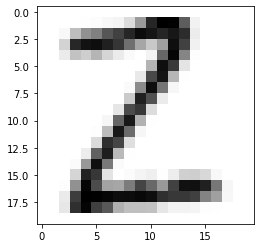

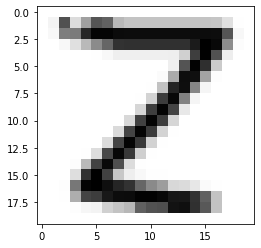

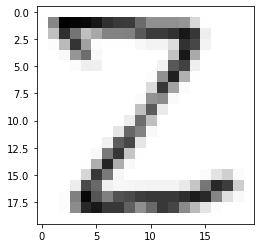

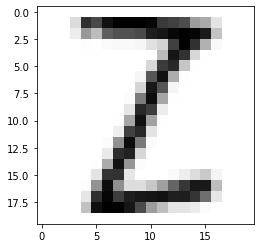

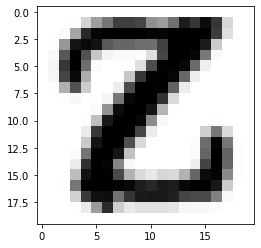

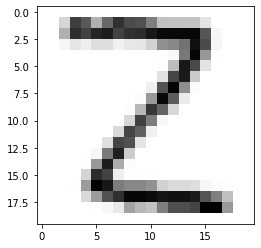

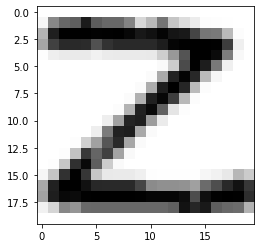

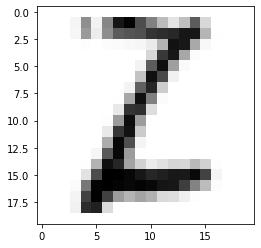

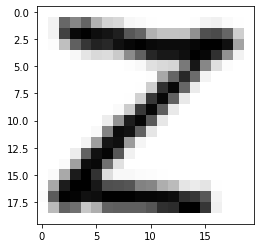

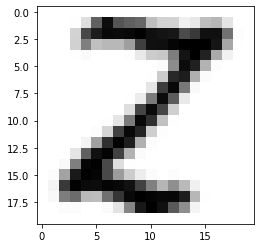

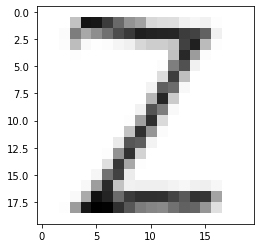

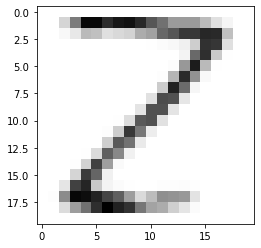

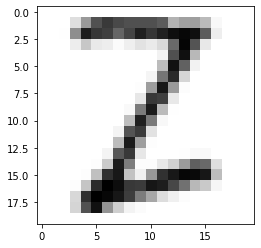

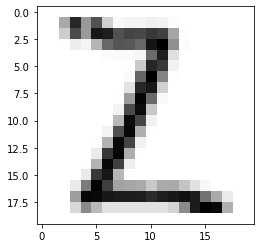

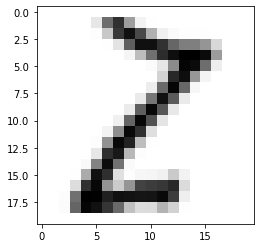

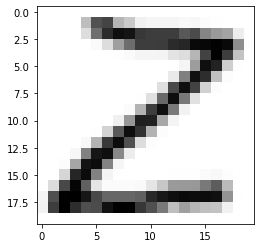

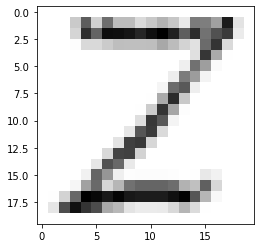

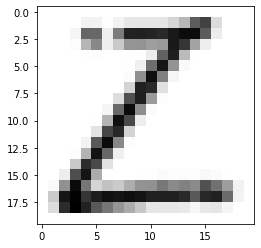

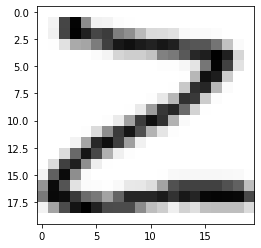

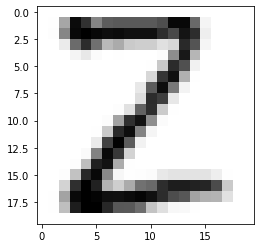

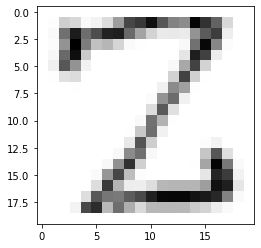

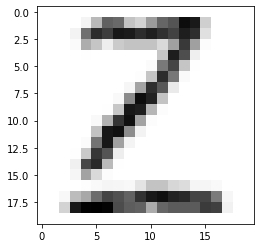

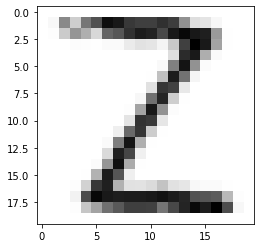

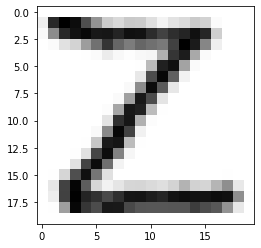

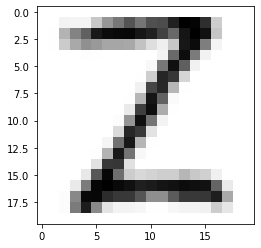

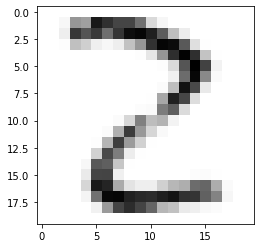

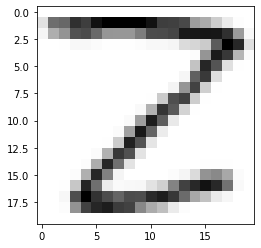

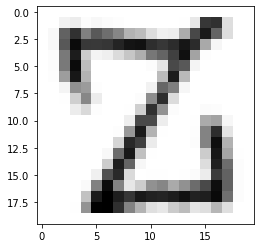

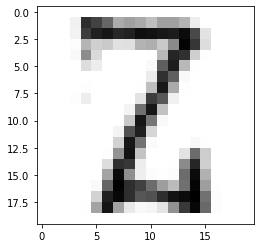

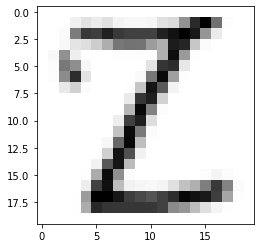

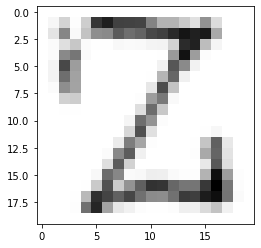

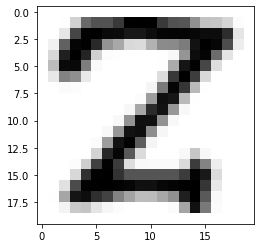

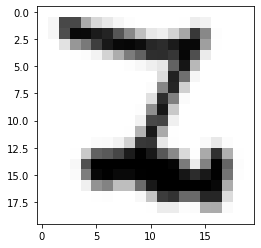

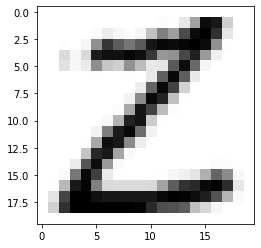

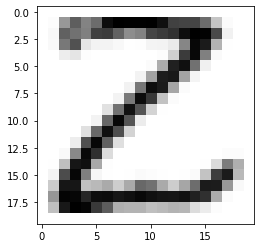

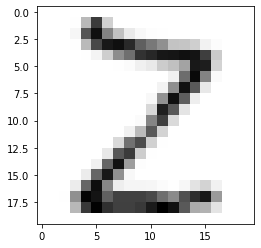

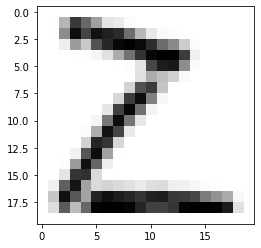

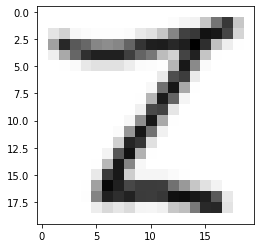

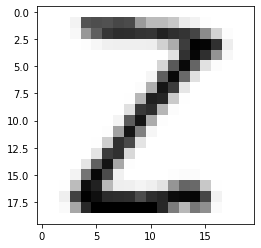

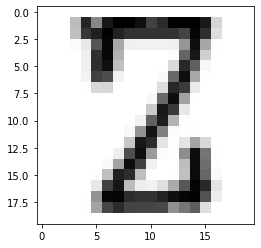

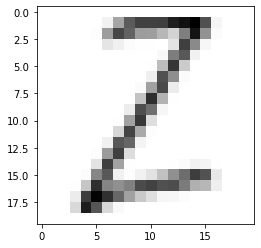

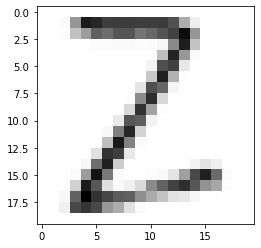

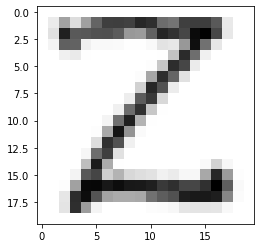

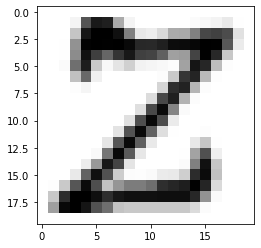

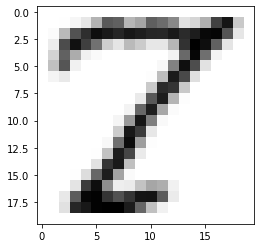

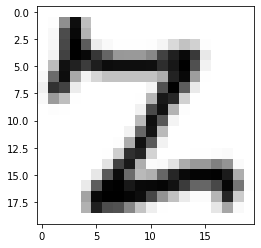

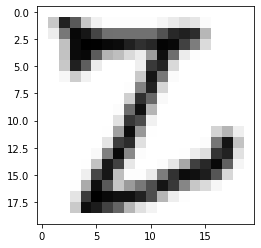

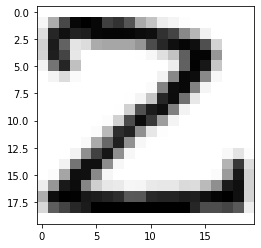

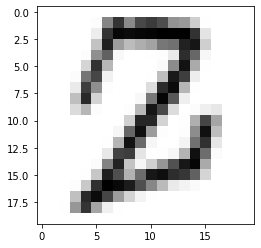

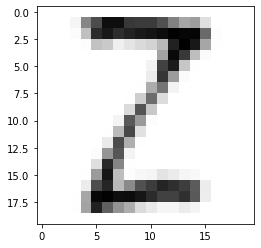

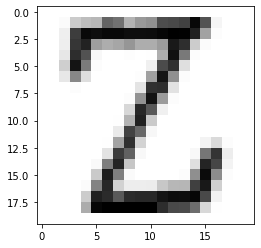

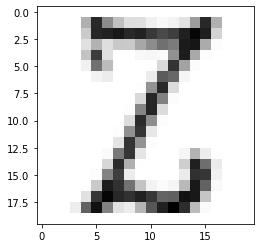

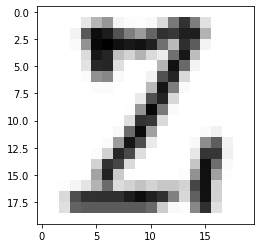

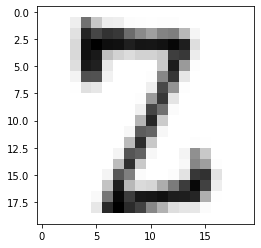

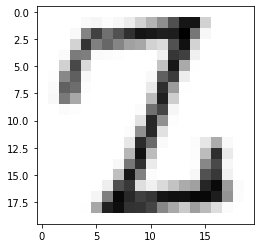

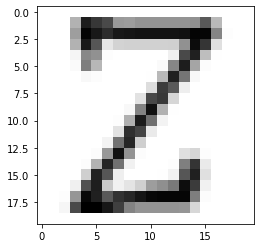

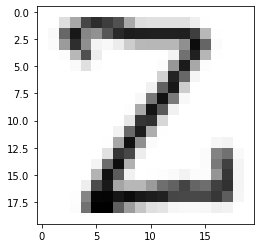

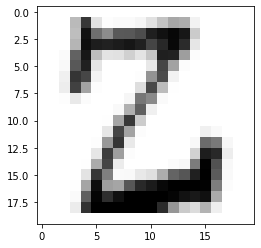

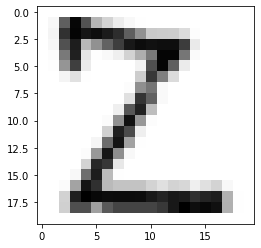

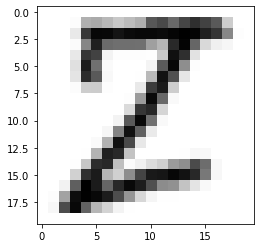

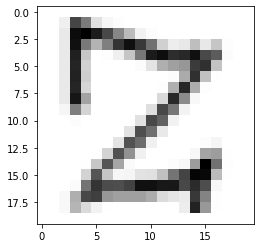

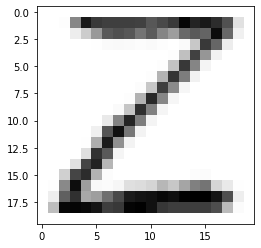

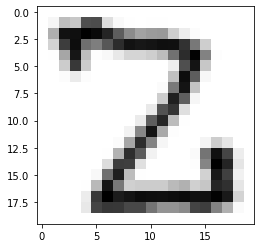

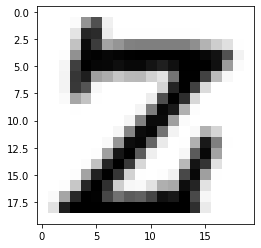

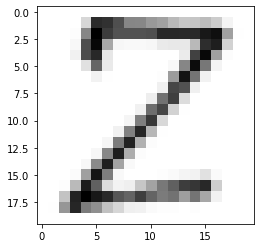

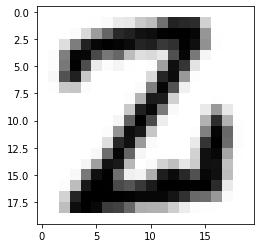

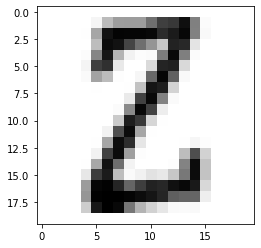

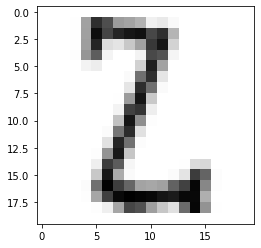

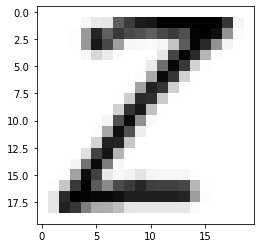

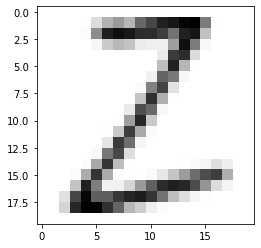

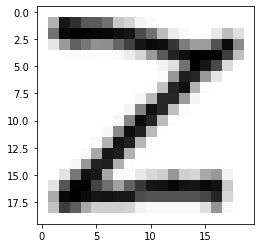

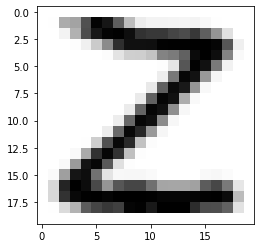

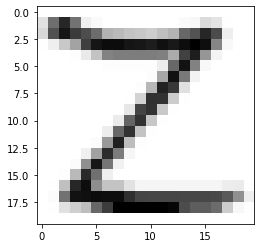

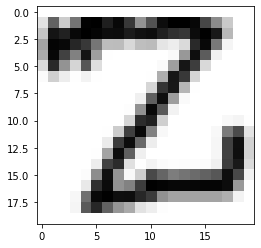

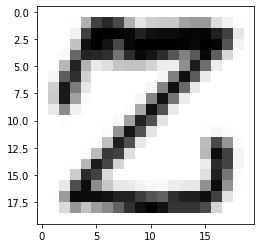

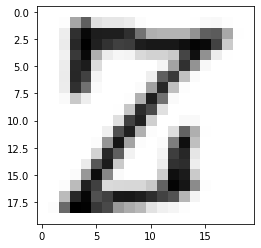

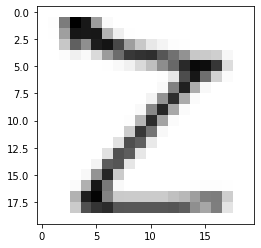

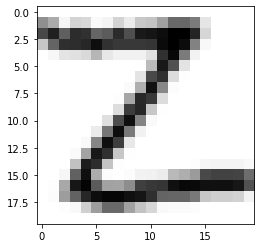

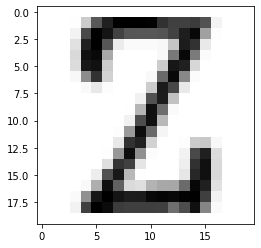

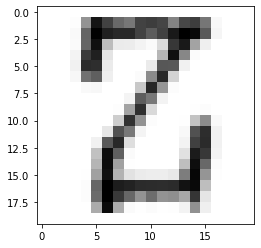

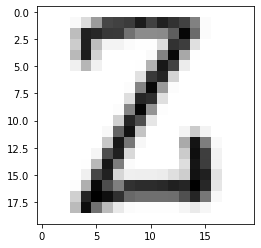

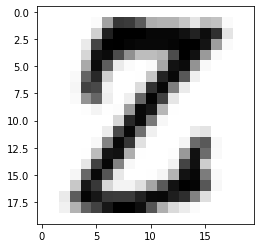

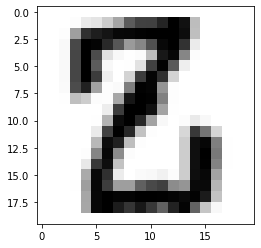

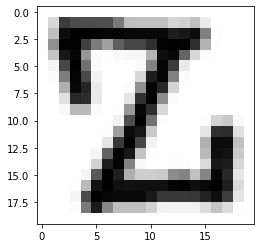

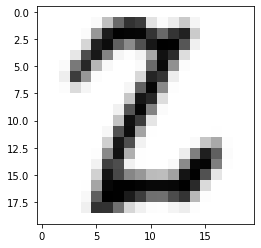

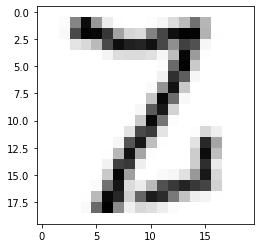

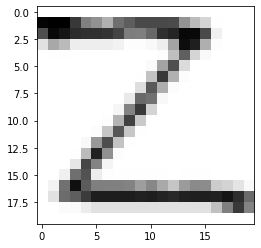

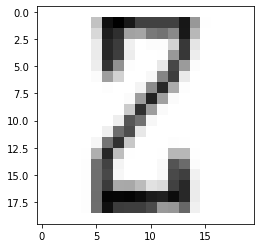

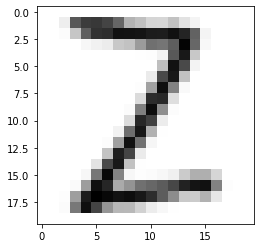

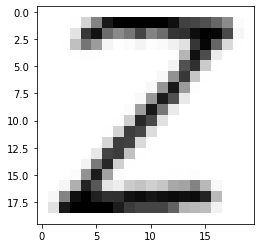

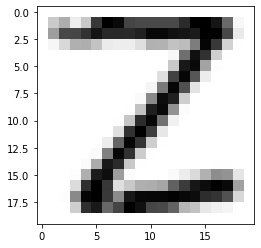

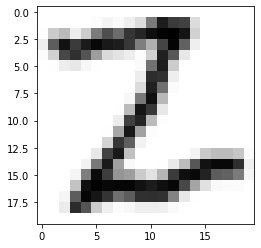

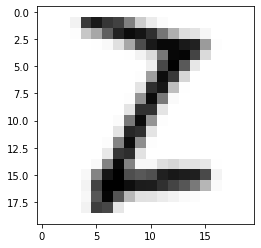

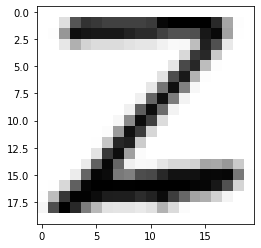

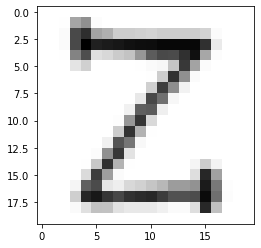

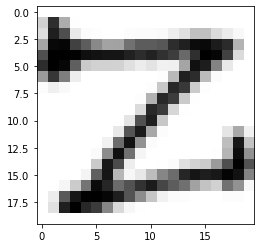

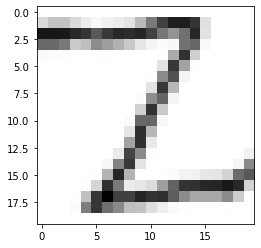

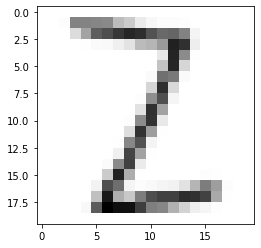

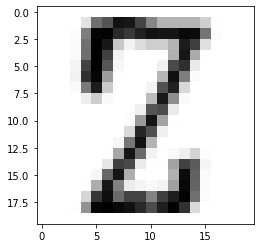

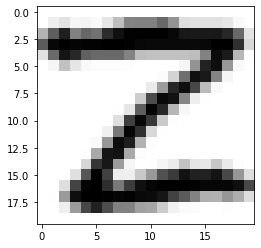

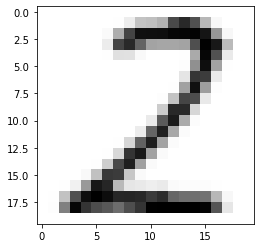

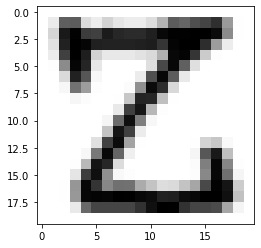

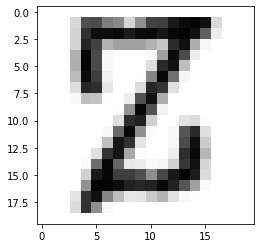

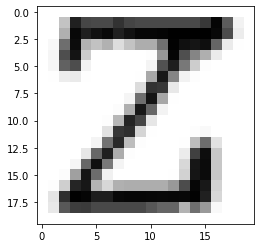

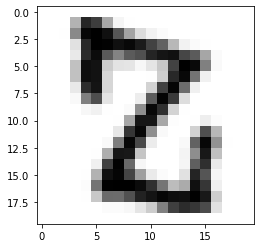

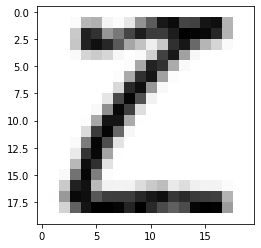

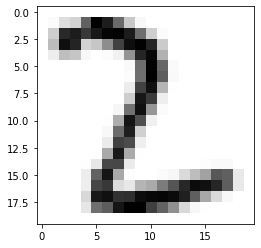

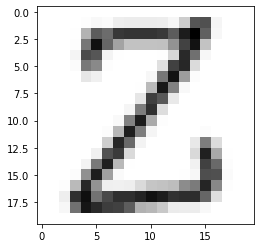

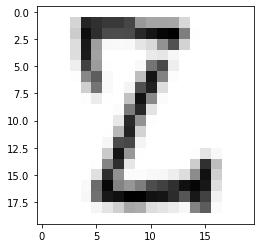

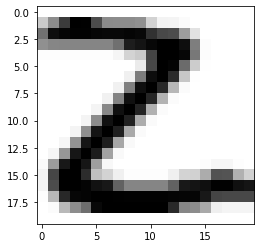

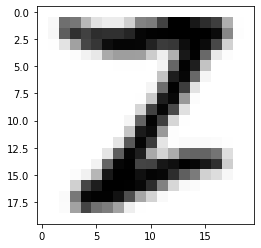

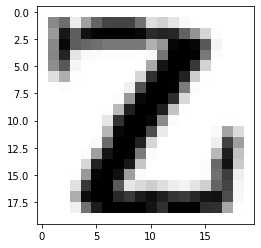

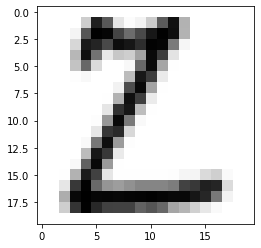

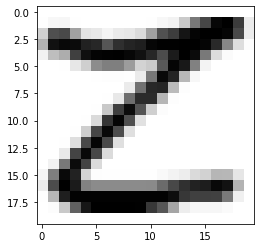

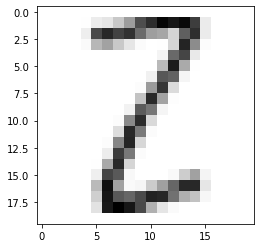

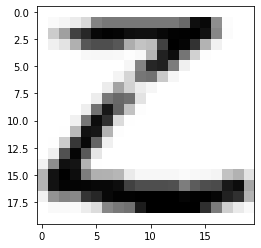

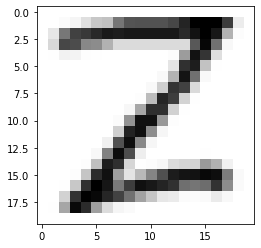

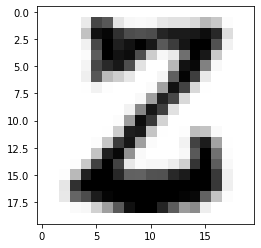

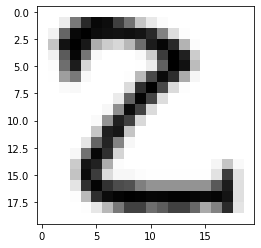

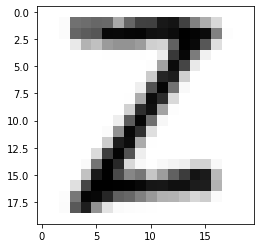

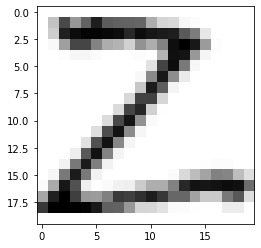

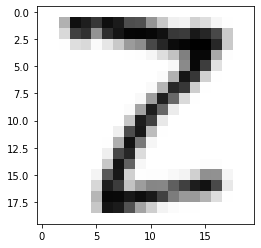

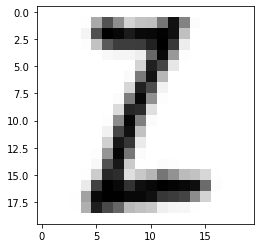

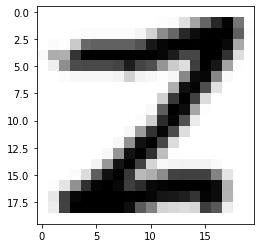

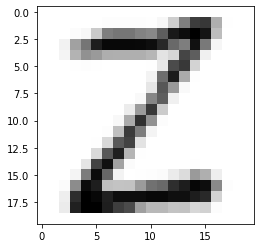

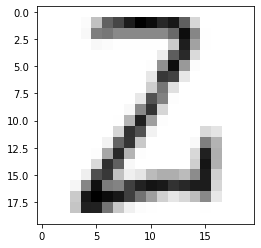

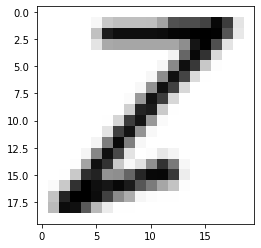

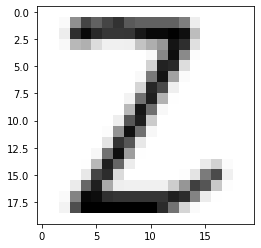

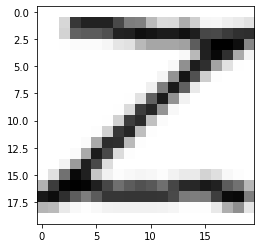

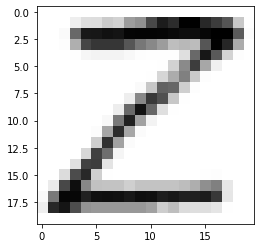

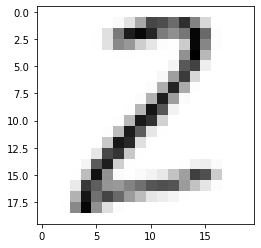

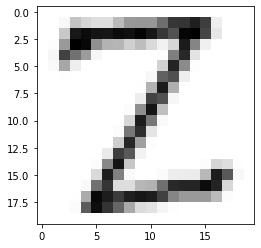

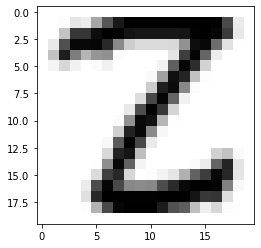

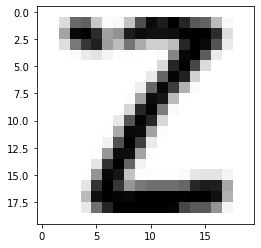

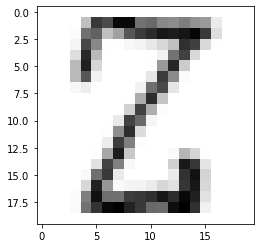

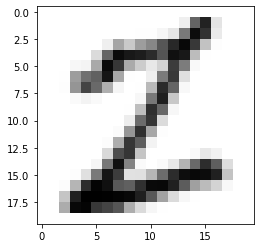

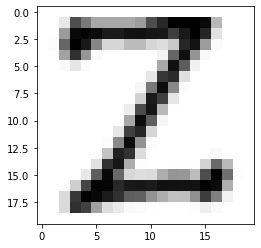

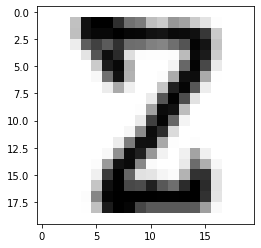

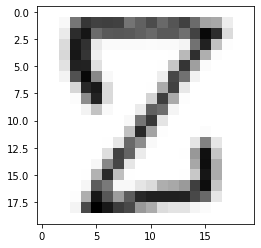

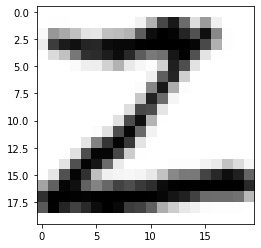

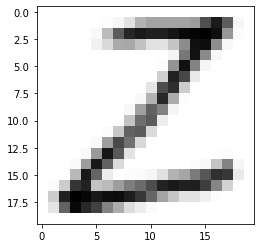

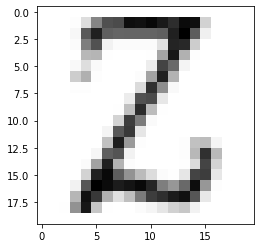

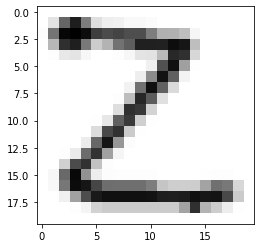

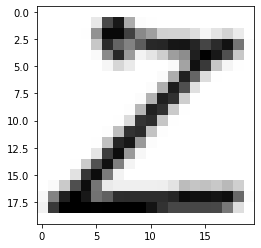

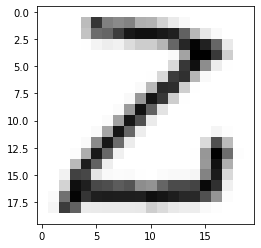

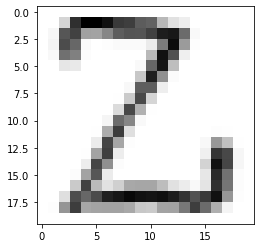

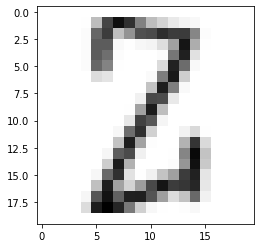

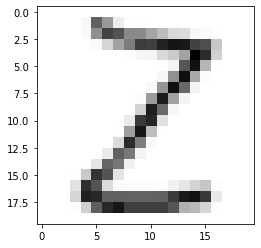

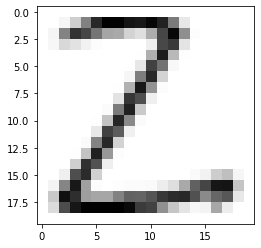

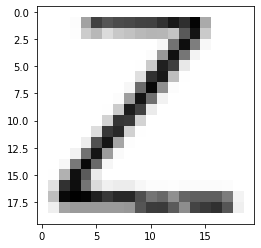

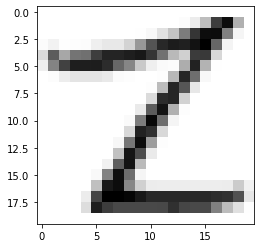

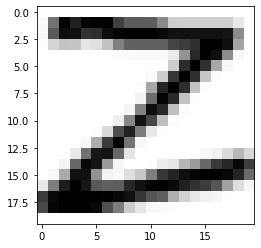

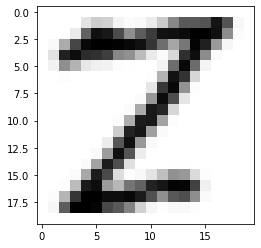

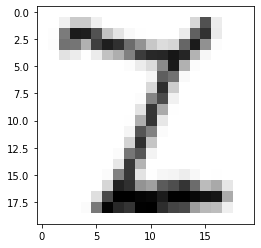

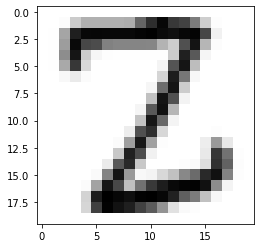

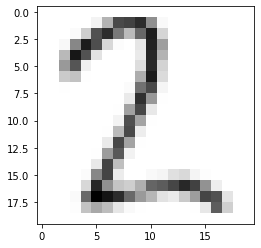

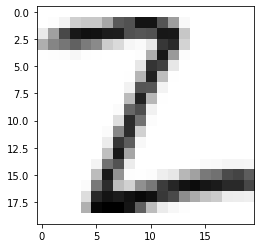

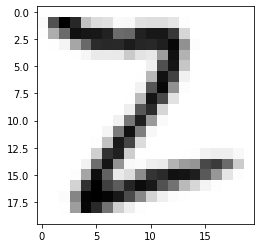

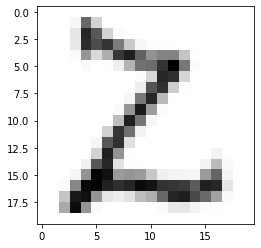

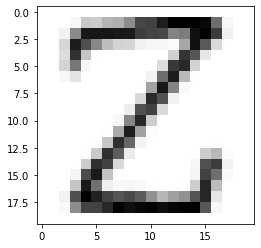

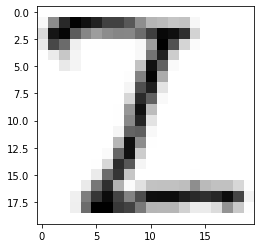

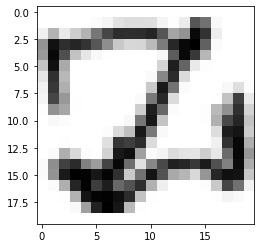

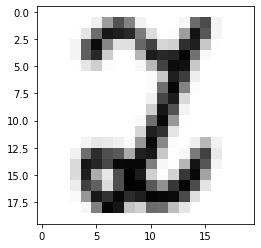

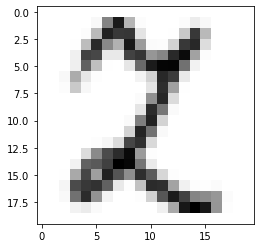

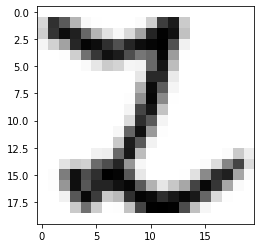

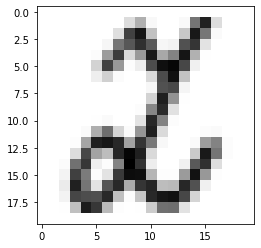

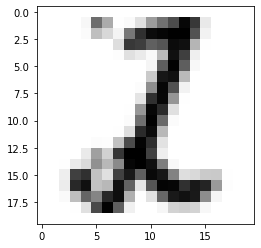

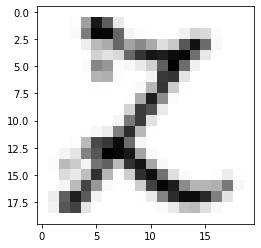

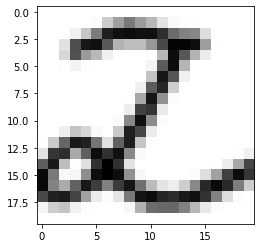

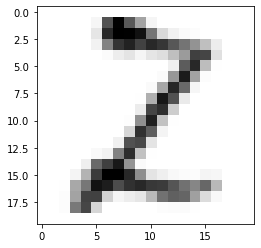

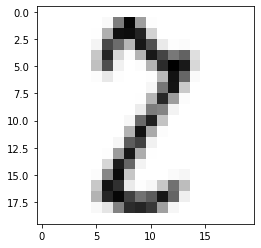

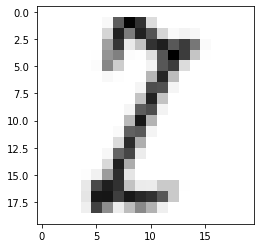

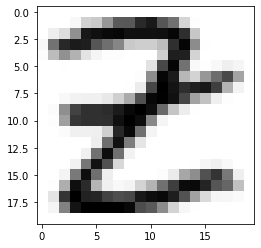

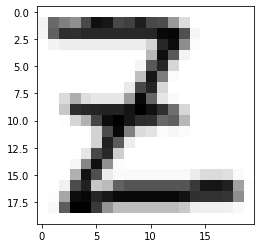

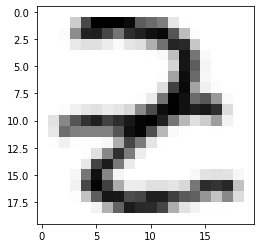

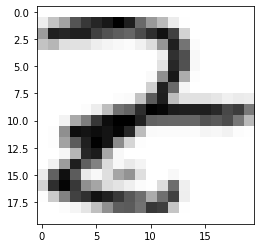

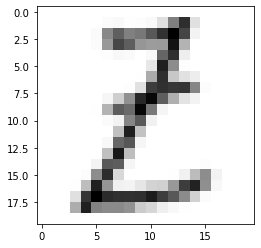

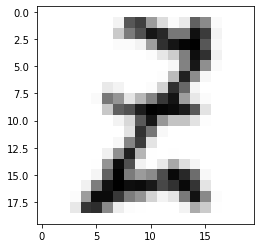

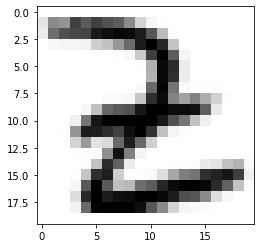

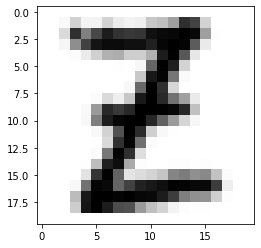

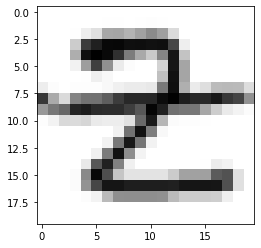

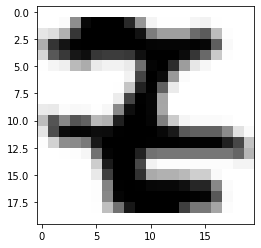

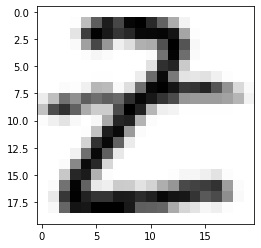

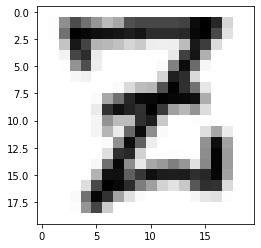

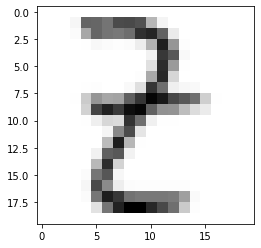

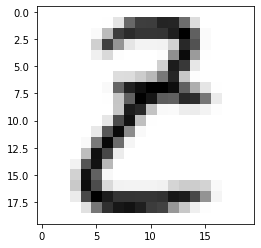

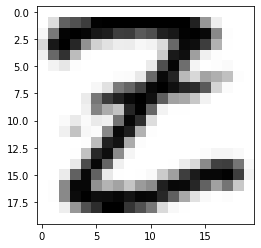

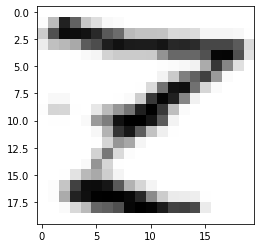

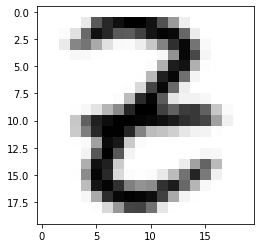

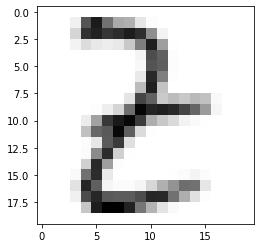

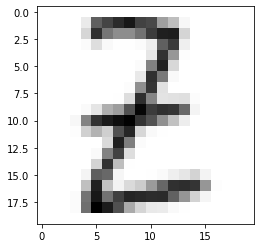

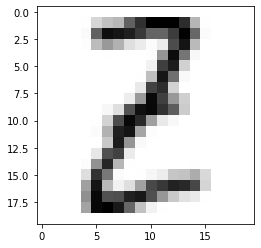

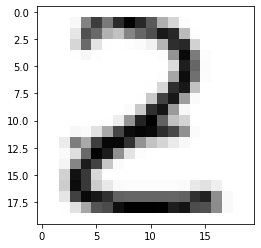

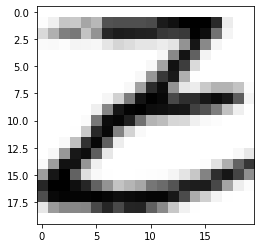

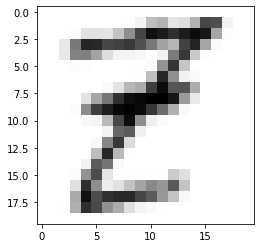

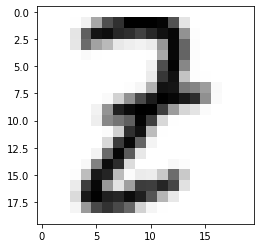

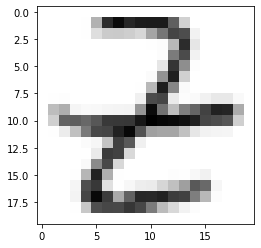

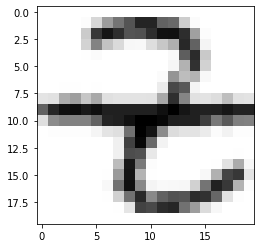

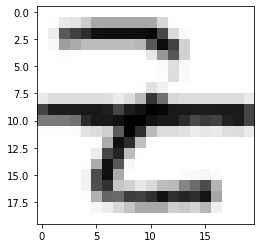

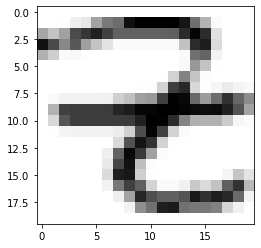

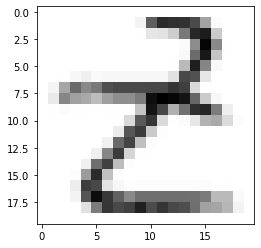

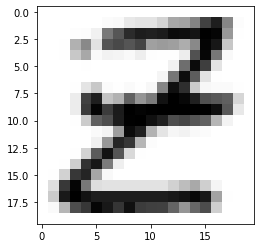

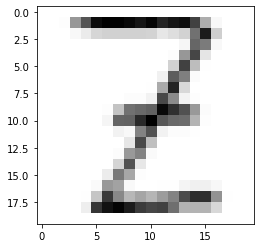

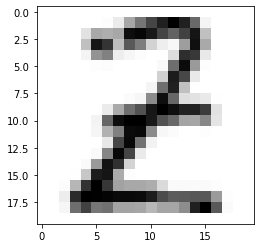

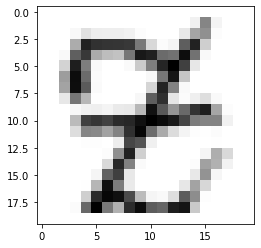

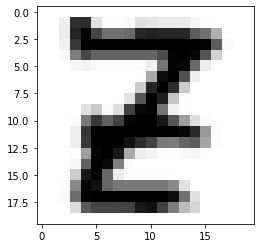

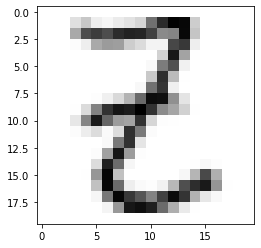

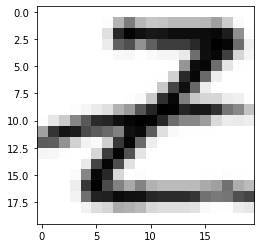

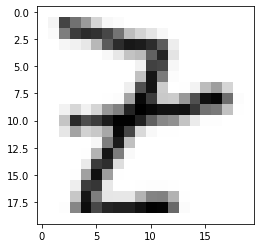

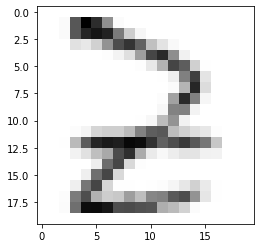

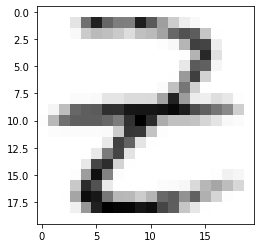

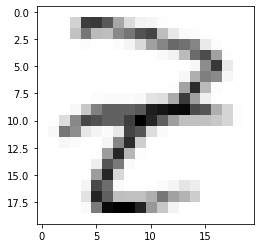

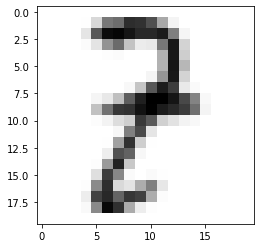

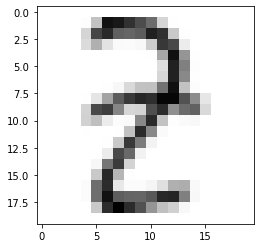

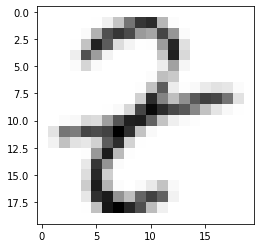

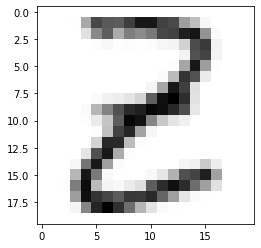

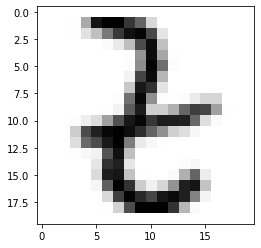

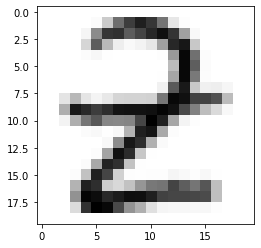

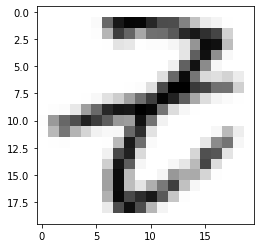

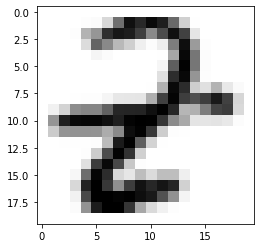

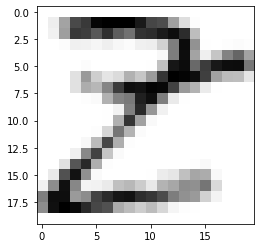

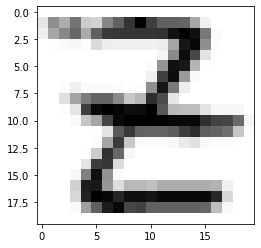

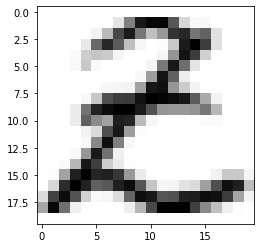

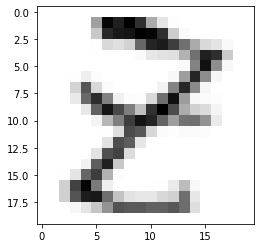

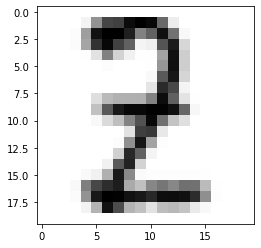

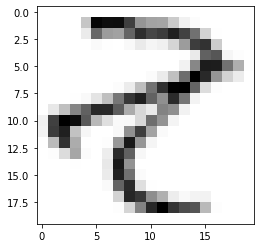

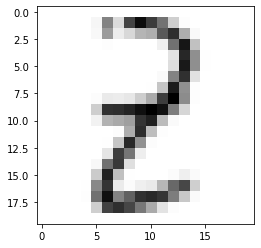

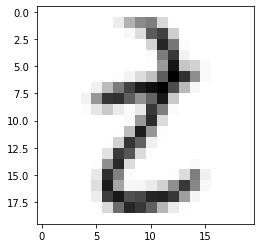

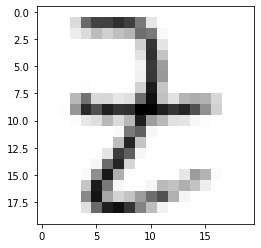

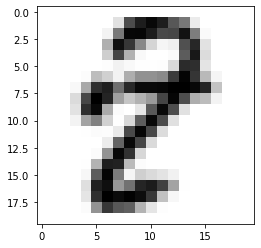

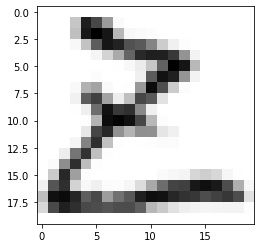

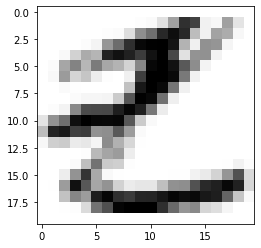

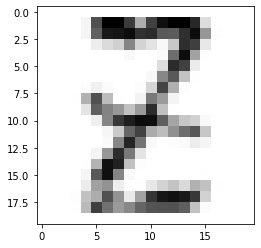

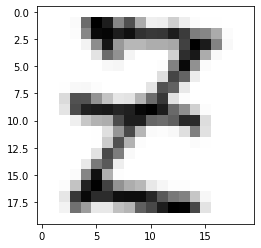

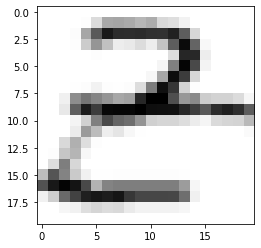

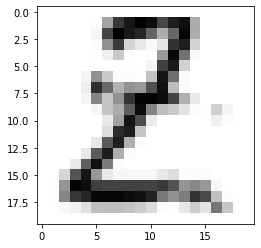

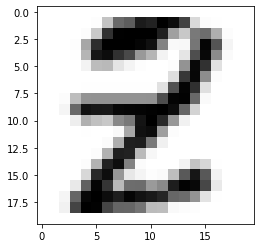

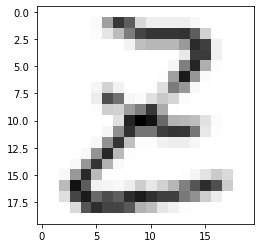

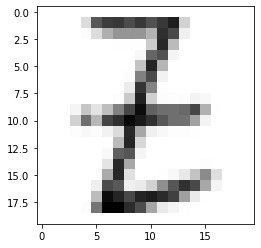

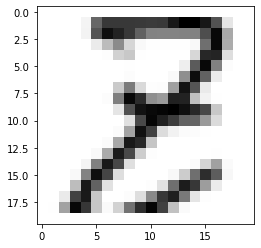

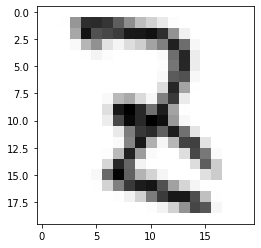

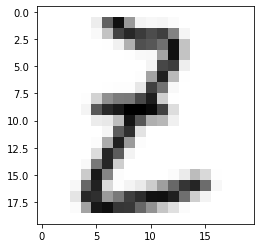

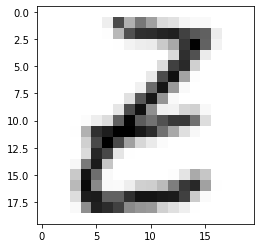

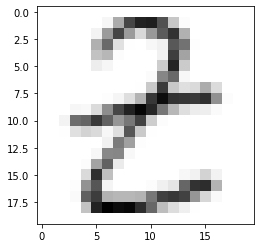

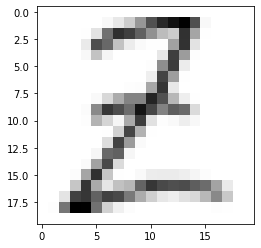

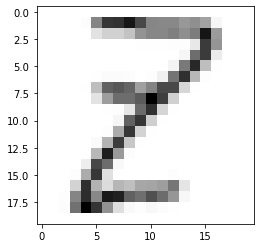

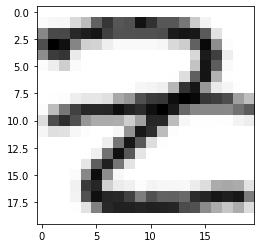

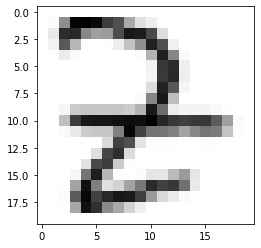

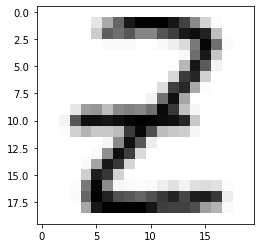

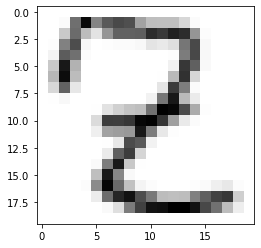

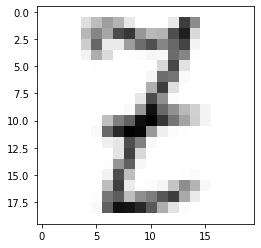

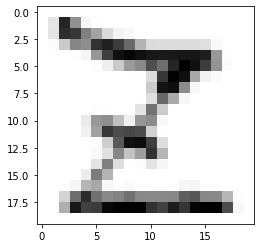

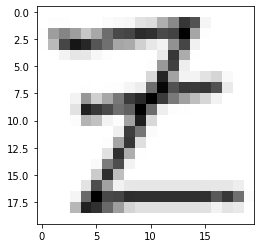

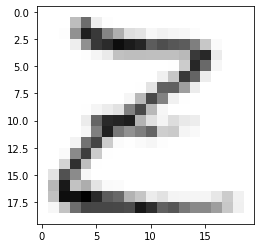

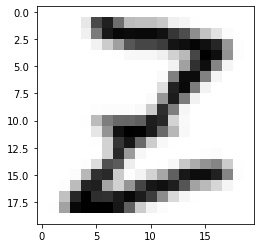

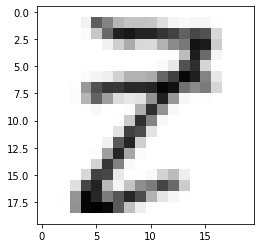

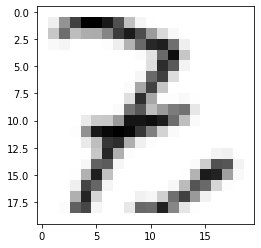

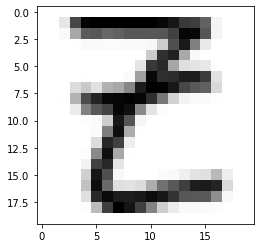

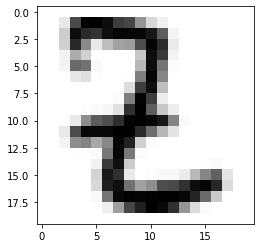

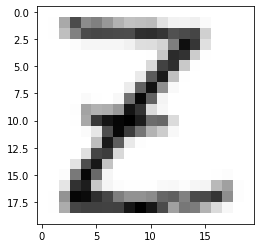

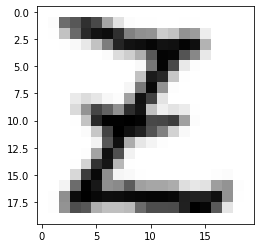

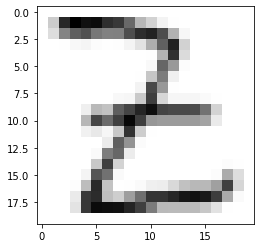

In [37]:
for class_index in range(28):
    reset_image_num_to_display()
    
    showing_images_cluster_i = x_train_20x20[kmeans.labels_ == class_index].reshape(-1, 20, 20)
    for showing_image in showing_images_cluster_i:
        display_image(showing_image, is_saved = False,
                      lb = class_index + 1)
    #len(showing_images_cluster_i)

## HELPERS

In [3]:
# SHOW many letters
import matplotlib as mpl
#mpl.rc('figure', is_saved = False, max_open_warning = 0)
mpl.rc('figure', max_open_warning = 0)
             
image_number = 0
def display_image(image, is_saved = False, lb=None):
    global image_number
    global label_map
    image_number += 1
    
    plt.figure(image_number)
    
    plt.imshow(image.squeeze(), cmap = plt.cm.gray_r)
    if is_saved:
        plt.savefig(DETAILED_OUTPUT_PATH + 'Letter-' + str(lb) + '_' + str(image_number) + '.png')
        print('Letter-' + str(lb) + '_' + str(image_number) + '.png')

#for i in range(28):
#    display_image(x_train_32x32_550[i*550]) #+500

def reset_image_num_to_display():
    global image_number
    image_number = 0

## ARCHIVE

In [1]:
X_digits, y_digits = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

In [14]:
kmeans = KMeans(n_clusters=5, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

In [21]:
kmeans.labels_

array([3, 4, 0, ..., 2, 2, 4])

In [24]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 134, 1: 392, 2: 222, 3: 255, 4: 344}

In [34]:
class_index = 0

X_train[kmeans.labels_ == class_index].shape

(134, 64)